In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from astropy.units import one
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import itertools
import random
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, \
                            precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc, accuracy_score

from IPython.display import clear_output

from tqdm import tqdm_notebook

import pandas as pd
# the distribution of sequence length
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import time
from datetime import datetime

In [2]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data_utils
import torch.optim.lr_scheduler as lr_scheduler 
import matplotlib.pyplot as plt
import copy

In [3]:
np.random.seed(0)
torch.manual_seed(0)

## paths

In [4]:
project_dir = '../../../'

ds_dir = f'{project_dir}data/no_sim_seq/'
snapshot_dir = f'{project_dir}snapshots/'

classes = ['lnc_e_nosim_noN','lnc_p_nosim_noN']
class_names = ["e-lncRNA","p-lncRNA"]

# neg_filename = f'{ds_dir}{classes[0]}.txt'
# pos_filename = f'{ds_dir}{classes[1]}.txt'


neg_filename = f'{ds_dir}trainval_test_files/{classes[0]}_tr_val.csv'
pos_filename = f'{ds_dir}trainval_test_files/{classes[1]}_tr_val.csv'

test_neg_filename = f'{ds_dir}trainval_test_files/{classes[0]}_test.csv'
test_pos_filename = f'{ds_dir}trainval_test_files/{classes[1]}_test.csv'


feature_filenames_class_0 = [f'{ds_dir}trainval_test_files/{classes[0]}_1mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[0]}_2mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[0]}_3mer_features_tr_val.csv']
feature_filenames_class_1 = [f'{ds_dir}trainval_test_files/{classes[1]}_1mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[1]}_2mer_features_tr_val.csv',
                             f'{ds_dir}trainval_test_files/{classes[1]}_3mer_features_tr_val.csv']


test_feature_filenames_class_0 = [f'{ds_dir}trainval_test_files/{classes[0]}_1mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[0]}_2mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[0]}_3mer_features_test.csv']
test_feature_filenames_class_1 = [f'{ds_dir}trainval_test_files/{classes[1]}_1mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[1]}_2mer_features_test.csv',
                                  f'{ds_dir}trainval_test_files/{classes[1]}_3mer_features_test.csv']



In [5]:
use_features = False
use_padding_for_bucketing = False

# hyper-parameters

class_weights = {0: 1., 1: 1.} 
#class_weights = {0: 1./(2.9+1.), 1: 2.9/(2.9+1.)} 

num_classes = 2

val_pct = 0.20
is_testing = True

use_full_DS = True;
class_balance_ratio = 1;

## load data

In [6]:
def get_data(filename):
    with open(filename,'r') as nf:
        examples = [seq.strip() for seq in nf.readlines()]
        num_examples = len(examples) # number of negative examples
        print(num_examples)
    return num_examples, examples


num_neg, neg_examples = get_data(neg_filename)
num_pos, pos_examples = get_data(pos_filename)

test_num_neg, test_neg_examples = get_data(test_neg_filename)
test_num_pos, test_pos_examples = get_data(test_pos_filename)
    

sequences_DS = neg_examples + pos_examples 
labels_DS = np.array([0]*num_neg + [1]*num_pos)   

test_sequences_DS = test_neg_examples + test_pos_examples 
test_labels_DS = np.array([0]*test_num_neg + [1]*test_num_pos)   

len(sequences_DS), len(labels_DS), len(test_sequences_DS), len(test_labels_DS)

2601
6145
290
683


(8746, 8746, 973, 973)

In [7]:
idx_neg =  np.arange(num_neg)
idx_pos =  num_neg + np.arange(num_pos) # negative examples' idx in concatenated array: [neg, pos]

test_idx_neg =  np.arange(test_num_neg)
test_idx_pos =  test_num_neg + np.arange(test_num_pos) # negative examples' idx in concatenated array: [neg, pos]


if(use_features):

    #features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).iloc[:,:-1].to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
    features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
    features_class1 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).to_numpy() for feature_filename in feature_filenames_class_1], axis = 1)

    #features_class0 = np.concatenate([pd.read_csv(feature_filename, header=None, sep="\t", index_col=False).iloc[:,:-1].to_numpy() for feature_filename in feature_filenames_class_0], axis = 1)
    test_features_class0 = np.concatenate([pd.read_csv(test_feature_filename, header=None, sep="\t", index_col=False).to_numpy() for test_feature_filename in test_feature_filenames_class_0], axis = 1)
    test_features_class1 = np.concatenate([pd.read_csv(test_feature_filename, header=None, sep="\t", index_col=False).to_numpy() for test_feature_filename in test_feature_filenames_class_1], axis = 1)
    
    neg_features = features_class0
    pos_features = features_class1

    test_neg_features = test_features_class0
    test_pos_features = test_features_class1
    
    
    features_DS = np.concatenate([features_class0, features_class1], axis = 0)
    print(neg_features.shape, pos_features.shape,features_DS.shape)

    test_features_DS = np.concatenate([test_features_class0, test_features_class1], axis = 0)
    print(test_neg_features.shape, test_pos_features.shape,test_features_DS.shape)
    
print("index size",len(idx_neg), len(idx_pos))
print(len(labels_DS),len(sequences_DS),len(sequences_DS[0]))

print("test index size",len(test_idx_neg), len(test_idx_pos))
print(len(test_labels_DS),len(test_sequences_DS),len(test_sequences_DS[0]))

index size 2601 6145
8746 8746 600
test index size 290 683
973 973 600


In [8]:
# labels_DS[:10],labels_DS[18487-10:18487+10],labels_DS[-10:],len(labels_DS) 

In [9]:
# def compute_kmer_counts(seq, k, do_sliding = True):
#     alphabet = list(set(list(seq)))
#     alphabet.sort()

#     kmers_list = []
#     kmers_list.append(alphabet)
    
#     for k_idx in range(k-1):
#         kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

#     seq_lst = list(seq)
#     subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
#     kmers = kmers_list[k-1]
#     kmers_counts = [subs.count(kmer) for kmer in kmers]
    
#     return kmers_counts

# results = []
# for idx in range(len(sequences_DS)):#np.random.randint(0, len(sequences_DS), size= (20,1) ):
#     #idx = idx.item()
#     seq = sequences_DS[idx]
#     kmer_counts1 = compute_kmer_counts(seq[:1000],3)
#     kmer_counts2 = compute_kmer_counts(seq[1000:],3)
#     #print(kmer_counts1, "||", kmer_counts2, "||",features_DS[idx,:][40:])
#     result = np.all(np.array(kmer_counts1+kmer_counts2) == np.array(features_DS[idx,40:].squeeze())) 
#     if(not result):
#         print(idx)
#         print(kmer_counts1)
#         print(kmer_counts2)
#         print(seq)
#         print(features_DS[idx,40:72].squeeze())
#         print(features_DS[idx,72:].squeeze())
#         print()
#     results.append(result)

In [10]:
# np.all(results)

## subsample dataset (if needed)

In [11]:
# shuffle the positive and negative indices
idx_neg_shuf = np.random.permutation(idx_neg)
idx_pos_shuf = np.random.permutation(idx_pos)

test_idx_neg_shuf = np.random.permutation(test_idx_neg)
test_idx_pos_shuf = np.random.permutation(test_idx_pos)


# cap class size ratio to be used to the class size ratio of the dataset
DS_class_balance_ratio = len(idx_neg_shuf)/len(idx_pos_shuf) 
DS_class_balance_ratio = 1/DS_class_balance_ratio if DS_class_balance_ratio < 1 else DS_class_balance_ratio


print("dataset class balance ratio:",DS_class_balance_ratio)

if DS_class_balance_ratio < class_balance_ratio:
    class_balance_ratio = DS_class_balance_ratio 

# subsample from dataset if needed    
if use_full_DS:
    mergedIndex = np.concatenate([idx_neg_shuf, idx_pos_shuf], axis = 0) ;
    print("After selection, size of neg :", len(idx_neg_shuf))
    print("After selection, size of pos :", len(idx_pos_shuf))
    print( 'len of merged: ' , len(mergedIndex) )
    
    test_mergedIndex = np.concatenate([test_idx_neg_shuf, test_idx_pos_shuf], axis = 0) ;
    print("After selection, size of test_neg :", len(test_idx_neg_shuf))
    print("After selection, size of test_pos :", len(test_idx_pos_shuf))
    print( 'len of test_merged: ' , len(test_mergedIndex) )
    
    
else:
    if(num_neg <= num_pos):
        idx_neg_selected =  idx_neg_shuf
        idx_pos_selected =  idx_pos_shuf[:int(class_balance_ratio*num_neg)]

        test_idx_neg_selected =  test_idx_neg_shuf
        test_idx_pos_selected =  test_idx_pos_shuf[:int(class_balance_ratio*test_num_neg)]
        
    else:
        idx_pos_selected =  idx_pos_shuf
        idx_neg_selected =  idx_neg_shuf[:int(class_balance_ratio*num_pos)]

        test_idx_pos_selected =  test_idx_pos_shuf
        test_idx_neg_selected =  test_idx_neg_shuf[:int(class_balance_ratio*test_num_pos)]
        
    # shift the pos's indices as pos examples come after negative example in the combines data structure
    idx_pos_selected += len(neg_examples)  
    test_idx_pos_selected += len(test_neg_examples)  
        
    mergedIndex = np.concatenate([idx_neg_selected, idx_pos_selected], axis = 0)
    print("After selection, size of neg :", len(idx_pos_selected))
    print("After selection, size of pos :", len(idx_neg_selected))
    print( 'len of merged : ' , len(mergedIndex) )
    
    test_mergedIndex = np.concatenate([test_idx_neg_selected, test_idx_pos_selected], axis = 0)
    print("After selection, size of test_neg :", len(test_idx_pos_selected))
    print("After selection, size of test_pos :", len(test_idx_neg_selected))
    print( 'len of test_merged : ' , len(test_mergedIndex) )
    

print('Total Seq found:' , len(sequences_DS) )
print('Total Seq found:' , len(test_sequences_DS) )

sequences, labels = zip(*[ (sequences_DS[i], labels_DS[i]) for i in mergedIndex ])
labels = np.array(labels)
print('Total Seq found AFTER selection:' , len(sequences) )
print('Total labels found AFTER selection:' , len(labels) )

test_sequences, test_labels = zip(*[ (test_sequences_DS[i], test_labels_DS[i]) for i in test_mergedIndex ])
test_labels = np.array(test_labels)
print('Total test_Seq found AFTER selection:' , len(test_sequences) )
print('Total test_labels found AFTER selection:' , len(test_labels) )



if(use_features):
    features = features_DS[mergedIndex,:]
    print('Total features found AFTER selection:' , len(features) )

    test_features = test_features_DS[test_mergedIndex,:]
    print('Total test_features found AFTER selection:' , len(test_features) )


dataset class balance ratio: 2.3625528642829683
After selection, size of neg : 2601
After selection, size of pos : 6145
len of merged:  8746
After selection, size of test_neg : 290
After selection, size of test_pos : 683
len of test_merged:  973
Total Seq found: 8746
Total Seq found: 973
Total Seq found AFTER selection: 8746
Total labels found AFTER selection: 8746
Total test_Seq found AFTER selection: 973
Total test_labels found AFTER selection: 973


### sanity check: checking whether the selected positive examples are truly from the original positive examples loaded from the disk

In [12]:
# tmp_neg = [sequences[i] for i in range(len(labels)) if labels[i] == 0]
# tmp_pos = [sequences[i] for i in range(len(labels)) if labels[i] == 1]
# print(len(tmp_pos), len(tmp_neg))

# print(np.all([s in neg_examples for s in tmp_neg]))
# print(np.all([s in pos_examples for s in tmp_pos]))

# print()
# test_tmp_neg = [test_sequences[i] for i in range(len(test_labels)) if test_labels[i] == 0]
# test_tmp_pos = [test_sequences[i] for i in range(len(test_labels)) if test_labels[i] == 1]
# print(len(test_tmp_pos), len(test_tmp_neg))

# print(np.all([s in test_neg_examples for s in test_tmp_neg]))
# print(np.all([s in test_pos_examples for s in test_tmp_pos]))


In [13]:
# # Let's print the first few sequences.
# df = pd.DataFrame(sequences_DS, index=np.arange(1, len(sequences_DS) + 1), columns=['Sequences'])

In [14]:
# identify the alphabet of the whole DS

unique_DNAs= set()
for seq in sequences_DS:
    s = set (seq)
    unique_DNAs = unique_DNAs | s

for seq in test_sequences_DS:
    s = set (seq)
    unique_DNAs = unique_DNAs | s
    
    
print("All nucleotides: ")
unique_DNAs = list(unique_DNAs)
unique_DNAs.sort()
num_DNAs = len(unique_DNAs)
print(unique_DNAs)
print(num_DNAs)

All nucleotides: 
['A', 'C', 'G', 'T']
4


In [15]:
# lengths of the sequences
sequence_lens = np.array([len(x) for x in sequences])

print("# of different sample lengths:",len(np.unique(sequence_lens)))
print("number of samples:",len(sequence_lens))
print("length of shortest sample: ",min(sequence_lens))
print("length of longest sample: ",max(sequence_lens))

print()
# lengths of the sequences
test_sequence_lens = np.array([len(x) for x in test_sequences])

print("# of different test_sample lengths:",len(np.unique(test_sequence_lens)))
print("number of test_samples:",len(test_sequence_lens))
print("length of shortest test_sample: ",min(test_sequence_lens))
print("length of longest test_sample: ",max(test_sequence_lens))


# of different sample lengths: 1
number of samples: 8746
length of shortest sample:  600
length of longest sample:  600

# of different test_sample lengths: 1
number of test_samples: 973
length of shortest test_sample:  600
length of longest test_sample:  600


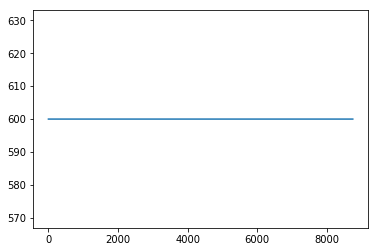

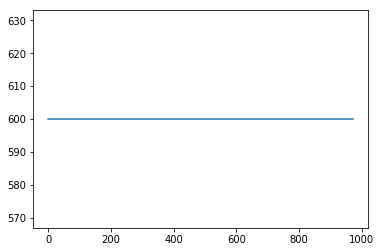

In [16]:


plt.plot(list(sorted(sequence_lens)))
plt.show()
plt.plot(list(sorted(test_sequence_lens)))

In [17]:
# code borrowed from lncNet repository for integer coding and bucketing

class CharacterTable(object): #make encoding table
    '''
    Given a set of characters:
    + Encode them to integer coding representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    #chars : 0 (padding ) + other characters
    '''
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, l):
        X = np.zeros((len(l)),dtype=np.int32)
        for i, c in enumerate(l):
            X[i]= self.char_indices[c]
    
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)
        


def dataset2buckets(sequence_lens, bucket_high_lims):
    
    # bucket of data indices
    buckets = [ [] for _ in bucket_high_lims]

    for i,len_x in enumerate( sequence_lens ):
        for b_id, bucket_len in enumerate(bucket_high_lims):
            if len_x <= bucket_len:
                # append the index of the data instead of the actual data
                buckets[b_id].append(i)  
                break

    return buckets

def seq2intcoding(seqs):
    X=[]
    for seq in seqs:
        enc = ctable.encode(seq)
        X.append(enc)
    
    X = np.array(X)
    
    return X

In [18]:
bucket_high_lims = [500*i for i in range(1,201)]
test_bucket_high_lims = [500*i for i in range(1,201)]


# do not pad if option not enabled
if not use_padding_for_bucketing:
    assert max(sequence_lens) == min(sequence_lens), "Sequence length varies; please enable bucketing"
    bucket_high_lims = [max(sequence_lens)]

    assert max(test_sequence_lens) == min(test_sequence_lens), "test_Sequence length varies; please enable bucketing"
    test_bucket_high_lims = [max(test_sequence_lens)]
    
    
chars= "0" + "".join(unique_DNAs)
ctable = CharacterTable(chars)

# integer coded sequences
seq_int_coded = seq2intcoding(sequences)
test_seq_int_coded = seq2intcoding(test_sequences)

# buckets containing  data indices
idxs_buckets = dataset2buckets(sequence_lens, bucket_high_lims)
used_buckets_idx, idxs_buckets  = zip(*[(i,idxs_buckets[i]) for i,b in enumerate(idxs_buckets) if b])

test_idxs_buckets = dataset2buckets(test_sequence_lens, test_bucket_high_lims)
test_used_buckets_idx, test_idxs_buckets  = zip(*[(i,test_idxs_buckets[i]) for i,b in enumerate(test_idxs_buckets) if b])


In [19]:
def create_seq_buckets(X, Y, idx_buckets, bucket_high_lims, used_buckets_idx, sequence_lens, use_features = False, features = None):    

    X_buckets = []
    X_buckets_padded = []
    Y_buckets = []
    X_buckets_packed = []
    
    sequence_lens = np.array(sequence_lens)
    #all_idxs = np.zeros(0)
    
    for b_id, idx_bucket in enumerate(idx_buckets):
        
        seq_lens_bucket = sequence_lens[idx_bucket]
        
        # ignore empty buckets
        if len(idx_bucket)==0:
            continue

        bucket_sz = len(idx_bucket)
        # indices of the data points in this bucket
        x_idxs = np.array(idx_bucket)
        
        #all_idxs = np.concatenate([all_idxs, x_idxs], axis = 0)
        
        # indices to the bucket contents (which is a set of indices as well - of data points)
        idx_in_bucket = np.arange(bucket_sz)
        
        X_bucket = X[x_idxs[idx_in_bucket]]
        Y_bucket = Y[x_idxs[idx_in_bucket]]
        
        X_bucket_T = [torch.Tensor(x) for x in X_bucket]
        #print(len(X_bucket_T))
        X_bucket_T.append(torch.zeros((bucket_high_lims[used_buckets_idx[b_id]],)))
        X_bucket_padded = pad_sequence(X_bucket_T, batch_first = True, padding_value = 0.0 )
        X_bucket_padded = X_bucket_padded.numpy()
        #print(X_bucket_padded.shape)
        # delete the last dummy row that served as element with padding length 
        X_bucket_padded = np.delete(X_bucket_padded, -1, axis = 0)        
        #print(X_bucket_padded.shape)
        
        X_bucket_padded=(np.arange(X_bucket_padded.max()+1) == X_bucket_padded[:,:,None]).astype(dtype='float32') #one_hot
        X_bucket_padded=np.delete(X_bucket_padded,0, axis=-1)
        #X_bucket = [X_bucket_padded[idx][:seq_lens_bucket[idx],:] for idx in range(X_bucket_padded.shape[0]) ]
        
        #X_buckets.append(X_bucket)
        if(use_features):
            X_bucket_padded = (X_bucket_padded, np.expand_dims(features[x_idxs[idx_in_bucket],:],-1) )  
            print(X_bucket_padded[0].shape, X_bucket_padded[1].shape)
        
        X_buckets_padded.append(X_bucket_padded)        
        Y_buckets.append(Y_bucket)
    
        #print(torch.Tensor(X_bucket_padded).shape)
        #sorted_lens = list(sorted(sequence_lens[idx_buckets[b_id]]))
        #print(sorted_lens[:10])
        
        # returns a packed sequences with #batches equal to the size of the maximum seq length, where a batch size
        # corresponds to how many sequences have a valid input at that time step
        #packed_input = pack_padded_sequence(torch.Tensor(X_bucket_padded), seq_lens_buckets, batch_first=True, enforce_sorted=False)
        #X_buckets_packed.append(packed_input)
        
    return X_buckets_padded,Y_buckets#, X_buckets_packed

In [20]:
if(not use_features):
    X_buckets, Y_buckets = create_seq_buckets(seq_int_coded, labels, idxs_buckets, bucket_high_lims, used_buckets_idx, sequence_lens, use_features)
    test_X_buckets, test_Y_buckets = create_seq_buckets(test_seq_int_coded, test_labels, test_idxs_buckets, test_bucket_high_lims, test_used_buckets_idx, test_sequence_lens, use_features)
else:
    X_buckets, Y_buckets = create_seq_buckets(seq_int_coded, labels, idxs_buckets, bucket_high_lims, used_buckets_idx, sequence_lens, use_features, features)
    test_X_buckets, test_Y_buckets = create_seq_buckets(test_seq_int_coded, test_labels, test_idxs_buckets, test_bucket_high_lims, test_used_buckets_idx, test_sequence_lens, use_features, test_features)
    


In [21]:
# for b_id in range(len(X_buckets)):
#     idxs_bucket = idx_buckets[b_id]
#     for rand_idx in np.random.randint(len(X_buckets[b_id]), size = 10):
#         print(X_buckets[b_id][rand_idx].shape, sequence_lens[idxs_bucket[rand_idx]])
        
#     print()

In [22]:
len(X_buckets), len(test_X_buckets),torch.cuda.is_available()

(1, 1, True)

In [23]:
len(idxs_buckets), len(test_idxs_buckets)

(1, 1)

In [24]:
# X_buckets[0][0][0,:].shape

In [25]:
def get_kmers(alphabet, k):
    kmers_list = []
    kmers_list.append(alphabet)
    
    for k_idx in range(k-1):
        kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

    seq_lst = list(seq)
    subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = kmers_list[k-1]
    
    return kmers

def compute_kmer_counts(seq, k, do_sliding = True):
    alphabet = list(set(list(seq)))
    alphabet.sort()

#     kmers_list = []
#     kmers_list.append(alphabet)
    
#     for k_idx in range(k-1):
#         kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

#     seq_lst = list(seq)
#     subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = get_kmers(alphabet, k)
    kmers_counts = [subs.count(kmer) for kmer in kmers]
    
    return kmers_counts

## sanity check 
[converting one-hot encoded sequences to DNA seq and checking against the corresponding original from the dataset]


In [26]:
# # sanity check [converting one-hot encoded sequences to DNA seq and checking against the corresponding original from the dataset]

def check_onehot_encoding_correctness(X_buckets, Y_buckets, unique_DNAs, sequences, sequence_lens, idxs_buckets):
    
    data_check_arr = []
    feature_check_arr = []
    incorrect_feature_match_indices = []

    for b_idx in range(len(X_buckets)):
        x_bucket_padded = X_buckets[b_idx]

        if(use_features):
            features_bucket = x_bucket_padded[1]
            x_bucket_padded = x_bucket_padded[0]

        y_bucket = Y_buckets[b_idx]
        idx_bucket = idxs_buckets[b_idx]

        for seq_idx in range(x_bucket_padded.shape[0]):
            seq_oh = x_bucket_padded[seq_idx,:,:]

            seq_str = "".join([unique_DNAs[dna_idx] for dna_idx in np.argmax(seq_oh, axis = -1)]) # convert from one-hot to DNA
            seq_str = seq_str[:sequence_lens[idx_bucket[seq_idx]]]  # get rid of the padding

            seq = sequences[idx_bucket[seq_idx]]  # original seq retrieved according to saved indices of the one-hot data

            if(use_features):
                idx_range = [[0,11],[12,59],[60,251]]
                feature_check_acc = []
                #seq = seq[-500:] + seq[:-500]
                for k in range(1,4):
                    kmer_counts1 = compute_kmer_counts(seq_str[:200], k)    
                    kmer_counts2 = compute_kmer_counts(seq_str[200:400], k)    
                    kmer_counts3 = compute_kmer_counts(seq_str[400:], k)    

                    features_computed= np.array(kmer_counts1+kmer_counts2+kmer_counts3)
                    features_from_file = features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze()
                    feature_check = np.all( features_computed == features_from_file)
                    #print(feature_check)
                    #print(features_computed)
                    #print(features_from_file)
                    #print()
                    #print(features_bucket[seq_idx,idx_range[k-1][0]:idx_range[k-1][1]+1].squeeze())
                    #print()
                    feature_check_acc.append(feature_check)
                #print()    
                feature_check_arr.append(np.all(feature_check_acc))

                if not np.all(feature_check_acc):
                    #print(seq_idx)
                    incorrect_feature_match_indices.append(seq_idx)

            data_check_arr.append(seq == seq_str)


    print("One-hot encoding and bucketing is correct:", np.all(np.array(data_check_arr)))

    if(use_features):
        print("feature check is correct:", np.all(np.array(feature_check_arr)))    
    

In [27]:
# check_onehot_encoding_correctness(X_buckets, Y_buckets, unique_DNAs, sequences, sequence_lens, idxs_buckets)
# print("Now test set")
# check_onehot_encoding_correctness(test_X_buckets, test_Y_buckets, unique_DNAs, test_sequences, test_sequence_lens, test_idxs_buckets)


# incorrects = [sequences[idxs_buckets[0][i]] for i in incorrect_feature_match_indices]
# [print(incorrect,"\n\n") for incorrect in incorrects]

In [28]:
def merge_buckets(XY1, XY2, using_features):
    X1, Y1 = XY1[0], XY1[1]
    X2, Y2 = XY2[0], XY2[1]
    
    X_merged, Y_merged = [],[]
    for b_idx in range(len(X1)):
        if(using_features):
            seq1 = X1[b_idx][0]
            num1 = X1[b_idx][1]

            seq2 = X2[b_idx][0]
            num2 = X2[b_idx][1]
            num_bucket = np.concatenate([num1,num2],axis = 0)
        
        else:
            seq1 = X1[b_idx]
            seq2 = X2[b_idx]
        
        seq_bucket = np.concatenate([seq1,seq2],axis = 0)
        
        if(using_features):
            X_merged.append((seq_bucket, num_bucket))
        else:
            X_merged.append(seq_bucket)
        label1 = Y1[b_idx]    
        label2 = Y2[b_idx]    
        label_bucket = np.concatenate([label1, label2], axis =0)
        Y_merged.append(label_bucket)
        
            
    return X_merged, Y_merged

if(is_testing):
    merged_buckets_X, merged_buckets_Y = merge_buckets((X_buckets, Y_buckets), (test_X_buckets, test_Y_buckets), use_features)
    training_example_counts = [X_bucket.shape[0] for X_bucket in X_buckets] 
    test_example_counts = [test_X_bucket.shape[0] for test_X_bucket in test_X_buckets]
    X_buckets = merged_buckets_X
    Y_buckets = merged_buckets_Y
    
len(X_buckets[0]),X_buckets[0].shape, len(test_X_buckets[0]),test_X_buckets[0].shape, merged_buckets_X[0].shape, merged_buckets_Y[0].shape, training_example_counts, test_example_counts


(9719,
 (9719, 600, 4),
 973,
 (973, 600, 4),
 (9719, 600, 4),
 (9719,),
 [8746],
 [973])

In [29]:
len(idxs_buckets), len(test_idxs_buckets)

(1, 1)

In [30]:
## Verify that in a packed seq, batch_size equals the number of sequences having a valid input at (index+1) of the index batch_size in batch_sizes

# sequence_lens_np = np.array(sequence_lens)
# batch_size_idx = random.choice(range(len(X_buckets_packed[0].batch_sizes)))
# batch_size = X_buckets_packed[0].batch_sizes[batch_size_idx]
# batch_size.numpy() == np.sum(sequence_lens_np[idx_buckets[0]]>=(batch_size_idx+1))

In [31]:
# def compute_accuracy_metrics(y_true, y_pred, do_print = False):
#     accuracy = (y_true==y_pred).sum()/len(y_true)
    
#     cm = confusion_matrix(y_true, y_pred)
#     cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#     tn, fp, fn, tp = cm.ravel()

#     specificity = tn/(fp+tn)
#     sensitivity = tp/(tp+fn)
#     f1 = f1_score(y_true, y_pred)
#     recall = recall_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred)
#     auc_roc = roc_auc_score( y_true, y_pred )  

#     results = {'accuracy': accuracy, 'specificity':specificity, 'sensitivity':sensitivity, 'f1_score':f1, 'auc_roc':auc_roc, 'recall':recall, 'precision': precision}

#     if do_print:
#         for metric_name, metric_val in results.items():
#             print(metric_name,f'{metric_val:.2f}')
    
#     return results

class Metrics:
    
    def __init__(self, benchmark_acc = 0.0, benchmark_f1 = 0.0, benchmark_spec = 0.0, benchmark_sen = 0.0, benchmark_auc = 0.0):
        self.b_accuracy = benchmark_acc
        self.b_f1 = benchmark_f1
        self.b_sensitivity = benchmark_sen
        self.b_specificity = benchmark_spec
        self.b_auc_roc = benchmark_auc

    def reset_history(self):
        self.accuracies = []
        self.f1s = []
        self.recalls = []
        self.precisions = []
        self.sensitivity = []
        self.specificity = []
        self.auc_roc = []        
        self.tp_tn_fp_fn = []
        
    def compute_metrics(self, y_true, y_pred, epoch, do_print = False, store_vals = False):
        accuracy = (y_true==y_pred).sum()/len(y_true)
    
        cm = confusion_matrix(y_true, y_pred)
        #cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        tn, fp, fn, tp = cm.ravel()

        specificity = tn/(fp+tn)
        sensitivity = tp/(tp+fn)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        auc_roc = roc_auc_score( y_true, y_pred )  

        if(store_vals):
            self.accuracies.append(accuracy)
            self.specificity.append(specificity)
            self.sensitivity.append(sensitivity)
            self.f1s.append(f1)
            self.auc_roc.append(auc_roc)        
            self.recalls.append(recall)
            self.precisions.append(precision)
            self.tp_tn_fp_fn.append((tp, tn, fp, fn)) 
        
        results = {'accuracy': accuracy, 'specificity':specificity, 'sensitivity':sensitivity, 'f1_score':f1, 'auc_roc':auc_roc, 'recall':recall, 
                   'precision': precision, 'tp_fp_tn_fn':{'tp':tp, 'fp':fp, 'tn':tn, 'fn':fn} }
        
        
        if(do_print):
            is_beaten_acc = False
            is_beaten_f1 = False
            is_beaten_sens = False
            is_beaten_spec = False
            is_beaten_auc = False
            
            if( accuracy > self.b_accuracy ):
                is_beaten_acc = True
            
            if( f1 > self.b_f1 ):
                is_beaten_f1 = True
            
            if( sensitivity > self.b_sensitivity ):
                is_beaten_sens = True

            if( specificity > self.b_specificity ):
                is_beaten_spec = True

            if( auc_roc > self.b_auc_roc ):
                is_beaten_auc = True


            print(f'_________________________________________ METRICS for epoch {epoch} _______________________________________________________')
            print('accuracy '.ljust(16),f':{accuracy:.5f} ',f' bmark:({self.b_accuracy:.4f})',f' accuracy beaten:{is_beaten_acc}')
            print('f1_score '.ljust(16),f':{f1:.5f} ',f' bmark:({self.b_f1:.4f})',f' f1 beaten:{is_beaten_f1}')
            print('sensitivity '.ljust(16),f':{sensitivity:.5f} ',f' bmark:({self.b_sensitivity:.4f})',f' sen.beaten:{is_beaten_sens}')
            print('specificity '.ljust(16),f':{specificity:.5f} ',f' bmark:({self.b_specificity:.4f})',f' spe.beaten:{is_beaten_spec}')
            print('auc_roc '.ljust(16),f':{auc_roc:.5f} ',f' bmark:({self.b_auc_roc:.4f})',f' spe.beaten:{is_beaten_auc}')            
            
            print('precision '.ljust(16),f':{precision} ')
            print('recall '.ljust(16),f':{recall}')
            print( '---------------------') 
            print(f'| tp:{tp} '.ljust(9),f'| fp:{fp}'.ljust(9),'|')
            print(f'| fn:{fn} '.ljust(9),f'| tn:{tn}'.ljust(9),'|')
            print('---------------------') 

            if(is_beaten_acc and is_beaten_f1 and is_beaten_sens and is_beaten_spec and is_beaten_auc):
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                print(f'##############################  BEATEN ALL at epoch:{epoch} ##############################################################')
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
        
        return results
    

In [32]:
# def make_model():
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ sequential definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     def make_seq_cnn():
#         # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

#         model = Sequential()

#         #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
#         model.add(Conv1D(filters=64, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # input = 129 * 32
#         model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=48, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

# #         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
# #         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
# #         model.add(BatchNormalization())    
# #         model.add(Activation('relu'))
# #         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
# #         model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

#     #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#     #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
#     #     #model.add(BatchNormalization())    
#     #     model.add(Activation('relu'))
#     #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#     #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


#         #model.add(Bidirectional(LSTM(16, return_sequences=True)))
#         #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
#         #model.add(Dropout(rate = 0.4))    

#         model.add(Flatten())

#         #model.add(Dense(16))
#         #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
#         # […] The surface is smoother and transitions are more gradual
#         model.add(Dense(32, kernel_regularizer=l2(0.02) ) )
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.6)) 
#         model.add(Dense(2, kernel_regularizer=l2(0.02)))        
#         model.add(Activation('softmax'))
        
#         SGDRScheduler_config = { 'min_lr':2e-4,
#                                  'max_lr':.2e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 5,
#                                  'mult_factor': 1.5}
        
#         config = {'learning_rate':0.001, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]

    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ sequential definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     def make_seq_3mer_cnn():
#         # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

#         model = Sequential()

#         model.add(Conv1D(filters=92, kernel_size=3 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # input = 129 * 32
#         model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=48, kernel_size=3, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

# #         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
# #         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
# #         model.add(BatchNormalization())    
# #         model.add(Activation('relu'))
# #         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
# #         model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

#     #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#     #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
#     #     #model.add(BatchNormalization())    
#     #     model.add(Activation('relu'))
#     #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#     #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


#         #model.add(Bidirectional(LSTM(16, return_sequences=True)))
#         #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
#         #model.add(Dropout(rate = 0.4))    

#         model.add(Flatten())

#         #model.add(Dense(16))
#         #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
#         # […] The surface is smoother and transitions are more gradual
#         model.add(Dense(48, kernel_regularizer=l2(0.02) ) )
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.6)) 
#         model.add(Dense(2, kernel_regularizer=l2(0.02)))        
#         model.add(Activation('softmax'))
        
#         SGDRScheduler_config = { 'min_lr':2e-4,
#                                  'max_lr':5e-4,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 5,
#                                  'mult_factor': 1.5}
        
#         config = {'learning_rate':0.001, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]    
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ sequential definition --------------------------------------------------------------------
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     def make_seq_cnn_blstm():
        
#         # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

#         model = Sequential()

#         #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
#         model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # input = 129 * 32
#         model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(8e-4), bias_regularizer=l2(8e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size =2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

#     #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#     #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
#     #     #model.add(BatchNormalization())    
#     #     model.add(Activation('relu'))
#     #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#     #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


#         #model.add(Bidirectional(LSTM(16, return_sequences=True)))
#         model.add(Bidirectional(CuDNNGRU(240, return_sequences=True, kernel_regularizer=l2(4e-3), recurrent_regularizer=l2(5e-3), bias_regularizer=l2(4e-3)) ))
#         model.add(Dropout(rate = 0.6))    

#         model.add(Flatten())

#         #model.add(Dense(16))
#         #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
#         # […] The surface is smoother and transitions are more gradual
#         model.add(Dense(16, kernel_regularizer=l2(0.01) ) )
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.5)) 
#         model.add(Dense(2, kernel_regularizer=l2(0.01)))        
#         model.add(Activation('softmax'))
        
# #         SGDRScheduler_config = { 'min_lr':2e-4,
# #                                  'max_lr':.2e-3,
# #                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
# #                                  'lr_decay':0.95,
# #                                  'cycle_length': 5,
# #                                  'mult_factor': 1.5}

# #         SGDRScheduler_config = { 'min_lr':5e-4,
# #                                  'max_lr':.5e-3,
# #                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
# #                                  'lr_decay':0.95,
# #                                  'cycle_length': 2,
# #                                  'mult_factor': 1.5}        


#         SGDRScheduler_config = { 'min_lr':1e-4,
#                                  'max_lr': .5e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 2,
#                                  'mult_factor': 1.5}        
        
#         config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]    
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ functional definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
    
#     def make_func_inception():
#         input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

#         def create_inception_module(input_tensor):
#             c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
#             c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
#             c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
#             #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
#             #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
#             inception_module = Concatenate([c3, c5, c8], axis = 2)
            
            
#             #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
#             #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
#             #inception_module = c8

#             return inception_module

#         out = create_inception_module(input_2d)
#         #out = Dropout(rate = 0.1)(out)  # was 0.4
#         out = Dropout(rate = 0.4)(out)  # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)


#         out = create_inception_module(out)
#         #out = Dropout(rate = 0.1)(out) # was 0.4
#         out = Dropout(rate = 0.4)(out) # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)

#         out = Conv1D(filters=32, kernel_size=8)(out)
#         out = Activation('relu')(out)     
#         #out = Dropout(rate = 0.45)(out) # was 0.4
#         out = Dropout(rate = 0.4)(out) # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)

#     #     out = Bidirectional( LSTM(16, return_sequences=True))(out)
#     #     out = Bidirectional( LSTM(16, return_sequences=True))(out)    
#     #     out = Dropout(rate = 0.25)(out)

#         out = Flatten()(out)
#         out = Dense(16)(out)
#         out = Activation('relu')(out)
#         out = Dropout(rate = 0.5)(out)

#         #out = Dense(2, activation='softmax')(out)
#         out = Dense(1, activation='sigmoid')(out)

#         model = Model(inputs = input_2d, outputs = out)        
    
#         SGDRScheduler_config = { 'min_lr':3e-5,
#                                  'max_lr':1e-3,    #0.5e-3, #1e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length':10,
#                                  'mult_factor': 1.0}
        
#         config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]
    
    
    
#     # -------------------------------------------------------------------------------------------------------------------------------------
#     # ------------------------------------------ functional definition --------------------------------------------------------------------        
#     # -------------------------------------------------------------------------------------------------------------------------------------
    
#     def make_func_inception_small():
#         input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

#         def create_inception_module(input_tensor):
#             c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
#             c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
#             c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
#             #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
#             #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
#             inception_module = Concatenate([c3, c5, c8], axis = 2)
            
            
#             #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
#             #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
#             #inception_module = c8

#             return inception_module

#         def create_resnet_module(input_tensor):
#             c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
#             c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
#             c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
#             #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
#             #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
#             inception_module = Concatenate([c3, c5, c8, input_tensor], axis = 2)
            
            
#             #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
#             #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
#             #inception_module = c8

#             return inception_module        
        
#         out = create_inception_module(input_2d)
#         #out = Dropout(rate = 0.1)(out)  # was 0.4
#         out = Dropout(rate = 0.4)(out)  # was 0.4
#         out = MaxPooling1D(pool_size = 2)(out)
        
#         out = create_inception_module(out)
#         #out = Dropout(rate = 0.1)(out) # was 0.4
#         out = Dropout(rate = 0.5)(out) # was 0.4
#         out = MaxPooling1D(pool_size = 2)(out)   

# #         out = create_resnet_module(out)
# #         #out = Dropout(rate = 0.1)(out) # was 0.4
# #         out = Dropout(rate = 0.4)(out) # was 0.4
# #         out = MaxPooling1D(pool_size = totalNuclType)(out)   
        
#         out = Conv1D(filters=64, kernel_size=8, kernel_regularizer=l2(8e-4), bias_regularizer=l2(8e-4))(out)
#         #out = BatchNormalization()(out)
#         out = Activation('relu')(out)     
#         #out = Dropout(rate = 0.45)(out) # was 0.4
#         out = Dropout(rate = 0.6)(out) # was 0.5, and 0.4 before
#         out = MaxPooling1D(pool_size = 2)(out)

        
#         out = Bidirectional( LSTM(16, return_sequences=True))(out)
#         out = Bidirectional( LSTM(16, return_sequences=True))(out)    
#         out = Dropout(rate = 0.25)(out)

#         out = Flatten()(out)
#         out = Dense(16, kernel_regularizer=l2(0.02))(out)
#         out = BatchNormalization()(out)
#         out = Activation('relu')(out)
#         out = Dropout(rate = 0.7)(out) # was 0.5

#         #out = Dense(2, activation='softmax')(out)
#         out = Dense(1, activation='sigmoid')(out)

#         model = Model(inputs = input_2d, outputs = out)        
    
#         SGDRScheduler_config = { 'min_lr':3e-5,
#                                  'max_lr':0.5e-3,    #0.5e-3, #1e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length':10,
#                                  'mult_factor': 1.0}
        
#         config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
#         return [model, config]    
    
    
#     return make_func_inception_small()

In [33]:
# https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797

class OneCycleCosineAnnealing:
    
    def __init__(self, optim, steps_per_cycle, cycles_per_round, max_lr = 1e-3, start_lr = None, end_lr = None, half_cycle_len_pct = .3, decay_rate = 1.0):
        init_div_factor, last_div_factor = 25.0, 1e4
        self.optim = optim
        self.max_lr = max_lr
        self.decay_rate = decay_rate
        self.cycles_per_round = cycles_per_round
        self.start_lr = self.max_lr/init_div_factor if start_lr is None else start_lr
        self.end_lr = self.max_lr/(init_div_factor*last_div_factor) if end_lr is None else end_lr
        for param_group in self.optim.param_groups:
            param_group['lr'] = self.start_lr
        self.steps_per_cycle = steps_per_cycle
        self.half_cycle_len_pct = half_cycle_len_pct
        self.peak_step_idx = int(self.steps_per_cycle*self.half_cycle_len_pct)
        print("self.start_lr",self.start_lr)
        print("self.max_lr",self.max_lr)
        print("self.end_lr",self.end_lr)
        
        self.coslr1 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.peak_step_idx, eta_min = self.max_lr)        
        self.coslr2 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.steps_per_cycle - self.peak_step_idx, eta_min = self.end_lr)
        self.step_idx = 0
        self.cycle_idx = 0
        self.lrs = []
        self.lrs.append(self.optim.param_groups[0]['lr'])
        
    def step(self):
        self.step_idx+=1
        if(self.step_idx < self.peak_step_idx):
            self.coslr1.step()  
        elif(self.step_idx <= self.steps_per_cycle):
            self.coslr2.step()
        else:
            self.cycle_idx +=1
            if(self.cycle_idx%self.cycles_per_round==0):
                self.max_lr*=self.decay_rate
            self.coslr1 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.peak_step_idx, eta_min = self.max_lr)  
            self.coslr2 = lr_scheduler.CosineAnnealingLR(self.optim, T_max = self.steps_per_cycle - self.peak_step_idx, eta_min = self.end_lr)
            self.coslr1.step()           
            self.step_idx = 1
            
        self.lrs.append(self.optim.param_groups[0]['lr'])
        
            
# model = torch.nn.Linear(1, 1)

# max_lr = 1e-3
# init_lr = max_lr/25.0
# last_lr = max_lr/25e4


# num_epochs = 50

# optimizer = torch.optim.SGD(model.parameters(), lr = init_lr)

# for param_group in optimizer.param_groups:
#         param_group['lr'] = init_lr

# scheduler = OneCycleCosineAnnealing(optimizer, num_epochs, 5, max_lr = 1e-3, decay_rate = .95)

# lrs = []

# lrs.append(optimizer.param_groups[0]['lr'])    

# for _ in range(10*num_epochs):
#     #print("-", l.last_epoch, optim.param_groups[0]['lr'])
#     scheduler.step()    
#     lrs.append(optimizer.param_groups[0]['lr'])
# print("min:",min(lrs))        
# plt.plot(lrs)
# plt.show()

In [34]:
# class ListDataset(torch.utils.data.Dataset):
    
#     def __init__(self, data, label) -> None:
#         super().__init__()
#         self.data = data
#         self.label = label
        
#         assert len(self.data) == len(self.label)
    
#     def __getitem__(self, index):
#         return (self.data[index], self.label[index])
    
#     def __len__(self):
#         return len(self.data)
    

# The network
class RNA_Net(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(RNA_Net, self).__init__()
        
        self.num_features = num_features
        self.hidden_sz = hidden_sz
        self.lstm = nn.LSTM(input_size = num_features, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.batchnrm = nn.BatchNorm1d(hidden_sz)
        #self.linear = nn.Linear(in_features = hidden_sz, out_features= 2)
        self.linear2 = nn.Linear(in_features = 2*hidden_sz, out_features= 2)
        
#         for name, param in self.lstm.named_parameters():
#             if 'bias' in name:
#                 nn.init.constant_(param, 0.0)
#             elif 'weight' in name:
#                 nn.init.xavier_normal_(param)
        
    def forward(self, x, seq_lengths):
#         x_packed = pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
#         packed_out, (hn, cn) = self.lstm(x_packed)        
#         out, input_sizes = pad_packed_sequence(packed_out, batch_first=True)

        out, (hn, cn) = self.lstm(x)        
        l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        #l2allstates = self.batchnrm(l2allstates)
        net_out = self.linear2(l2allstates.view(-1, 2*self.hidden_sz))
        #net_out = self.linear2(last_state_cmbnd.view(-1, 2*self.hidden_sz))
        
        
        
        return net_out

    
class CNPPNet(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(CNPPNet, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        # inception layer 1
        self.conv11 = nn.Conv1d(num_features,64, kernel_size= 3, padding=1)
        self.conv12 = nn.Conv1d(num_features,64, kernel_size= 5, padding=2)
        self.conv13 = nn.Conv1d(num_features,32, kernel_size= 7, padding=3)
        
        # inception layer 2
        self.conv21 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv22 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv23 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
        self.maxpool1d = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(160,32, kernel_size= 7)
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.linear1 = nn.Linear(in_features = 32*7, out_features= 16)
        self.linear2 = nn.Linear(in_features = 16, out_features= 2)
 
        
    def forward(self,x):
        x = x.permute(0,2,1)
        
        #print(x.shape)
        out1 = self.conv11(x)
        out1 = F.relu(out1)
        out2 = self.conv12(x)
        out2 = F.relu(out2)
        out3 = self.conv13(x)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        
        out1 = self.conv21(out)
        out1 = F.relu(out1)
        out2 = self.conv22(out)
        out2 = F.relu(out2)
        out3 = self.conv23(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        out = self.conv3(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        #print(out.shape)
        
        out = self.linear1(out.view(-1, 32*7))
        out = F.dropout(out, p = 0.5)
        out = self.linear2(out)

        return out

    
class CNPPNet_Hybrid(nn.Module):
    
    def __init__(self, num_features, hidden_sz):
        super(CNPPNet_Hybrid, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        # inception layer 1
        self.conv11 = nn.Conv1d(num_features,64, kernel_size= 3, padding=1)
        self.conv12 = nn.Conv1d(num_features,64, kernel_size= 5, padding=2)
        self.conv13 = nn.Conv1d(num_features,32, kernel_size= 7, padding=3)
        
        # inception layer 2
        self.conv21 = nn.Conv1d(160,64, kernel_size= 3, padding=1)
        self.conv22 = nn.Conv1d(160,64, kernel_size= 5, padding=2)
        self.conv23 = nn.Conv1d(160,32, kernel_size= 7, padding=3)
        
        self.maxpool1d = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(160,32, kernel_size= 7)
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        #self.linear1 = nn.Linear(in_features = 32*29 , out_features= 16)
        
        self.linear1 = nn.Linear(in_features = 32*29 + 64, out_features= 16)
        self.linear2 = nn.Linear(in_features = 16, out_features= 2)
 
        self.feature_linear1 = nn.Linear(in_features = 168, out_features= 128)
        self.feature_linear2 = nn.Linear(in_features = 128, out_features= 64)
        
        layers = [nn.BatchNorm1d(n_in)]
        layers.append(nn.Dropout(p))
        layers.append(nn.Linear(n_in, n_out))
        layers.append(actn)
        layers

        
    def forward(self,seq, features):
        x = seq.permute(0,2,1)
        features = features.permute(0,2,1)
#         print(x.type())
        
        out1 = self.conv11(x)
        out1 = F.relu(out1)
        out2 = self.conv12(x)
        out2 = F.relu(out2)
        out3 = self.conv13(x)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        
        out1 = self.conv21(out)
        out1 = F.relu(out1)
        out2 = self.conv22(out)
        out2 = F.relu(out2)
        out3 = self.conv23(out)
        out3 = F.relu(out3)
        out = torch.cat((out1,out2,out3),1)
        #out = F.relu(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        out = self.conv3(out)
        out = F.dropout(out, p = 0.4)
        out = self.maxpool1d(out)
        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        
        #print(features.shape)
        feature_out = self.feature_linear1(features.view(-1,168))
        feature_out = self.feature_linear2(feature_out)
        
        
        combined_out = torch.cat((out.view(-1, 32*29),feature_out),1)
        #combined_out = torch.cat(out.view(-1, 32*29),1)
        out = self.linear1(combined_out)
        
        #out = self.linear1(out.view(-1, 32*29))
        out = F.dropout(out, p = 0.5)
        out = self.linear2(out)

        return out    
    
    
class CNNNet(nn.Module):
    # https://peltarion.com/static/vgg_pa03.jpg
    
    def __init__(self, num_features, hidden_sz):
        super(CNNNet, self).__init__()
        #super().__init__()
        
        self.hidden_sz = hidden_sz
        self.conv1 = nn.Conv1d(in_channels = num_features, out_channels = 32, kernel_size= 7)        
        self.conv2 = nn.Conv1d(in_channels = self.conv1.out_channels, out_channels = 64, kernel_size= 5)
        self.maxpool1d_2 = torch.nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(in_channels = self.conv2.out_channels,out_channels = 128, kernel_size= 3)        
        self.maxpool1d_4 = torch.nn.MaxPool1d(kernel_size=4)
        
        
        #self.lstm = nn.LSTM(input_size = 64, hidden_size = hidden_sz, batch_first = True, bidirectional = True)
        self.linear1 = nn.Linear(in_features = 128*36, out_features= 64)
        self.linear2 = nn.Linear(in_features = 64, out_features= 16)
        self.linear3 = nn.Linear(in_features = 16, out_features= 2)        
 
        self.dropout = nn.Dropout(p =0.5)
    
    def forward(self,x):
        x = x.permute(0,2,1)
        
        #print(x.shape)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.maxpool1d_2(out)

        out = self.conv3(out)
        out = self.maxpool1d_4(out)        
        
        out = self.linear1(out.view(-1, 128*36))
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear3(out)

        #out = out.permute(0,2,1)
        
        #out, (hn, cn)  = self.lstm(out)
        
        #l2allstates = torch.sqrt(torch.sum(out**2, dim = 1))
        #last_state_cmbnd = torch.cat([hn, cn], dim = -1)
        
        #l2allstates = self.batchnrm(l2allstates)
        #print(out.shape)
        #print(out.shape)
        
        

        return out

In [35]:
# import torch
# from matplotlib import pyplot as plt

# print("torch version: ", torch.__version__)

        
# model = torch.nn.Linear(1, 1)

# max_lr = 1e-3
# init_lr = max_lr/25.0
# last_lr = max_lr/25e4
# print("init_lr",init_lr)
# print("max_lr",max_lr)
# print("last_lr",last_lr)

# num_epochs = 20

# optim = torch.optim.SGD(model.parameters(), lr = init_lr)

# for param_group in optim.param_groups:
#         param_group['lr'] = init_lr

        

# l1 = lr_scheduler.CosineAnnealingLR(optim, T_max = num_epochs//3, eta_min = max_lr)
# lr2 = lr_scheduler.CosineAnnealingLR(optim, T_max = 2*num_epochs//3, eta_min = last_lr)
# #lr2 = lr_scheduler.StepLR(optim, gamma = 0.9, step_size = 2)
# lrs = []


# lrs.append(optim.param_groups[0]['lr'])    

# for _ in range(num_epochs):
#     #print("-", l.last_epoch, optim.param_groups[0]['lr'])
#     if(l1.last_epoch<num_epochs//3):
#         l1.step()        
#     else:
#         lr2.step()
#     lrs.append(optim.param_groups[0]['lr'])
# plt.plot(lrs)
# plt.show()

In [36]:
# tr_idxs = bucket_train_test_idxs[0][0]
# test_idxs = bucket_train_test_idxs[0][1]

# len(bucket_train_test_idxs[0][0]), len(bucket_train_test_idxs[0][1]), max(tr_idxs), min(test_idxs), max(test_idxs)

In [37]:
###### Setup K-fold X-validation

xval_fold_count =  10 
num_epochs =  100
batch_sz = 512

skf = StratifiedKFold( n_splits= xval_fold_count , random_state = 23, shuffle=True)

num_buckets = len(X_buckets)

bucket_train_test_idxs = []

use_xfolding = False

if(is_testing): 
    xval_fold_count = 1

# generating train_test indices for all k folds, for each bucket
for bucket_idx in range(num_buckets):
    #bucket_input_features = X_buckets[bucket_idx]
    
    #if(use_features):
    #    bucket_input_features = bucket_input_features[0]
        
    bucket_labels = Y_buckets[bucket_idx]
    
    train_test_idxs = list(skf.split(np.zeros(len(bucket_labels)), bucket_labels))
    if(not is_testing):
        bucket_train_test_idxs.append(train_test_idxs)
    else:
        bucket_train_test_idxs.append( np.expand_dims([list(range(training_example_counts[bucket_idx])), 
                                        list(range(training_example_counts[bucket_idx],training_example_counts[bucket_idx]+test_example_counts[bucket_idx]))],axis =0 ) )

In [38]:
# len(bucket_train_test_idxs[0][0])

Fold 0
CNNNet(
  (conv1): Conv1d(4, 32, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (maxpool1d_2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (maxpool1d_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4608, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
)
self.start_lr 0.0002
self.max_lr 0.005
self.end_lr 2e-08
18
Epoch 0 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 0 completed.
Validation metrics
_________________________________________ METRICS for epoch 0 _______________________________________________________
accuracy         :0.70195   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.82488   bmark:(1.0000)  f1 beaten:False
sensitivity      :1.00000   bmark:(0.8277)  sen.beaten:True
specificity      :0.00000   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.50000   bmark:(1.0000)  spe.beaten:False
precision        :0.7019527235354573 
recall           :1.0
---------------------
| tp:683  | fp:290  |
| fn:0    | tn:0    |
---------------------


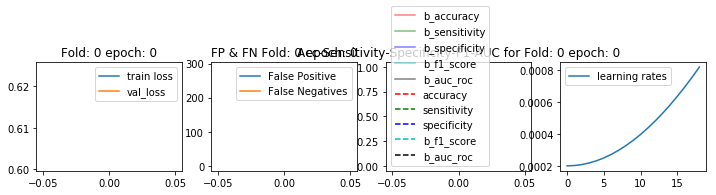

Epoch 1 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 1 completed.
Validation metrics
_________________________________________ METRICS for epoch 1 _______________________________________________________
accuracy         :0.70195   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.82488   bmark:(1.0000)  f1 beaten:False
sensitivity      :1.00000   bmark:(0.8277)  sen.beaten:True
specificity      :0.00000   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.50000   bmark:(1.0000)  spe.beaten:False
precision        :0.7019527235354573 
recall           :1.0
---------------------
| tp:683  | fp:290  |
| fn:0    | tn:0    |
---------------------


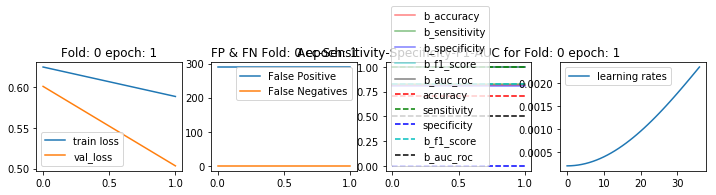

Epoch 2 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 2 completed.
Validation metrics
_________________________________________ METRICS for epoch 2 _______________________________________________________
accuracy         :0.79342   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.84989   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83309   bmark:(0.8277)  sen.beaten:True
specificity      :0.70000   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.76654   bmark:(1.0000)  spe.beaten:False
precision        :0.8673780487804879 
recall           :0.8330893118594437
---------------------
| tp:569  | fp:87   |
| fn:114  | tn:203  |
---------------------


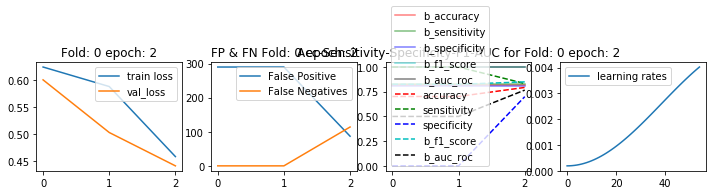

Epoch 3 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 3 completed.
Validation metrics
_________________________________________ METRICS for epoch 3 _______________________________________________________
accuracy         :0.76053   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.80502   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.70425   bmark:(0.8277)  sen.beaten:False
specificity      :0.89310   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.79867   bmark:(1.0000)  spe.beaten:False
precision        :0.939453125 
recall           :0.7042459736456809
---------------------
| tp:481  | fp:31   |
| fn:202  | tn:259  |
---------------------


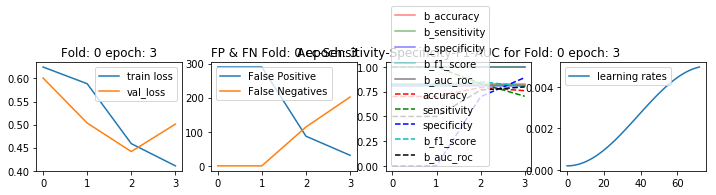

Epoch 4 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 4 completed.
Validation metrics
_________________________________________ METRICS for epoch 4 _______________________________________________________
accuracy         :0.79856   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.84244   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.76720   bmark:(0.8277)  sen.beaten:False
specificity      :0.87241   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.81981   bmark:(1.0000)  spe.beaten:False
precision        :0.9340463458110517 
recall           :0.767203513909224
---------------------
| tp:524  | fp:37   |
| fn:159  | tn:253  |
---------------------


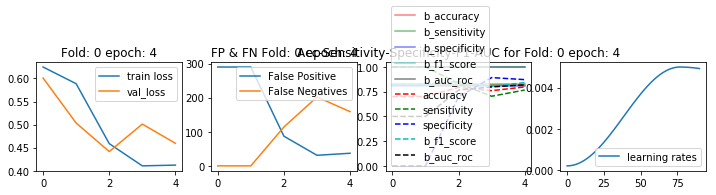

Epoch 5 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 5 completed.
Validation metrics
_________________________________________ METRICS for epoch 5 _______________________________________________________
accuracy         :0.81706   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.86716   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.85066   bmark:(0.8277)  sen.beaten:True
specificity      :0.73793   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.79429   bmark:(1.0000)  spe.beaten:False
precision        :0.8843226788432268 
recall           :0.8506588579795022
---------------------
| tp:581  | fp:76   |
| fn:102  | tn:214  |
---------------------


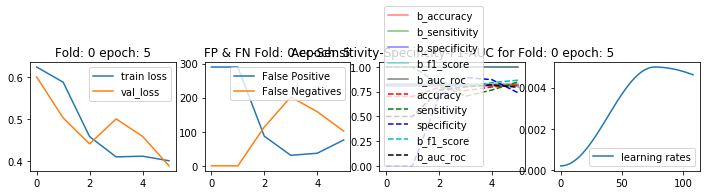

Epoch 6 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 6 completed.
Validation metrics
_________________________________________ METRICS for epoch 6 _______________________________________________________
accuracy         :0.78931   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.85949   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.91801   bmark:(0.8277)  sen.beaten:True
specificity      :0.48621   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.70211   bmark:(1.0000)  spe.beaten:False
precision        :0.8079896907216495 
recall           :0.91800878477306
---------------------
| tp:627  | fp:149  |
| fn:56   | tn:141  |
---------------------


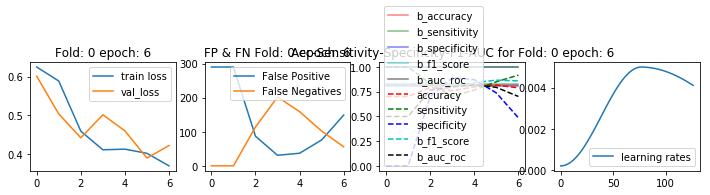

Epoch 7 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 7 completed.
Validation metrics
_________________________________________ METRICS for epoch 7 _______________________________________________________
accuracy         :0.83248   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.87355   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.82430   bmark:(0.8277)  sen.beaten:False
specificity      :0.85172   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.83801   bmark:(1.0000)  spe.beaten:False
precision        :0.929042904290429 
recall           :0.8243045387994143
---------------------
| tp:563  | fp:43   |
| fn:120  | tn:247  |
---------------------


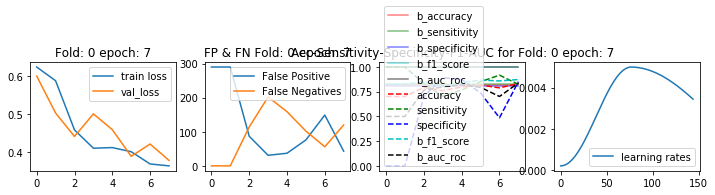

Epoch 8 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 8 completed.
Validation metrics
_________________________________________ METRICS for epoch 8 _______________________________________________________
accuracy         :0.83248   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.87881   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86530   bmark:(0.8277)  sen.beaten:True
specificity      :0.75517   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81024   bmark:(1.0000)  spe.beaten:False
precision        :0.8927492447129909 
recall           :0.8653001464128843
---------------------
| tp:591  | fp:71   |
| fn:92   | tn:219  |
---------------------


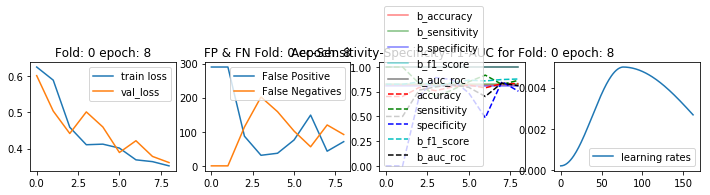

Epoch 9 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 9 completed.
Validation metrics
_________________________________________ METRICS for epoch 9 _______________________________________________________
accuracy         :0.84481   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88249   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83016   bmark:(0.8277)  sen.beaten:True
specificity      :0.87931   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85474   bmark:(1.0000)  spe.beaten:False
precision        :0.9418604651162791 
recall           :0.8301610541727672
---------------------
| tp:567  | fp:35   |
| fn:116  | tn:255  |
---------------------


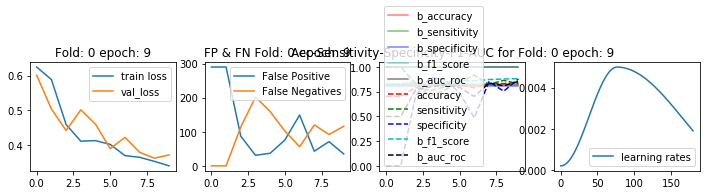

Epoch 10 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 10 completed.
Validation metrics
_________________________________________ METRICS for epoch 10 _______________________________________________________
accuracy         :0.84378   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88606   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86530   bmark:(0.8277)  sen.beaten:True
specificity      :0.79310   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82920   bmark:(1.0000)  spe.beaten:False
precision        :0.9078341013824884 
recall           :0.8653001464128843
---------------------
| tp:591  | fp:60   |
| fn:92   | tn:230  |
---------------------


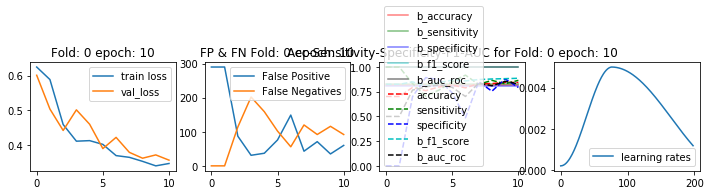

Epoch 11 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 11 completed.
Validation metrics
_________________________________________ METRICS for epoch 11 _______________________________________________________
accuracy         :0.84584   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88739   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86530   bmark:(0.8277)  sen.beaten:True
specificity      :0.80000   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83265   bmark:(1.0000)  spe.beaten:False
precision        :0.9106317411402157 
recall           :0.8653001464128843
---------------------
| tp:591  | fp:58   |
| fn:92   | tn:232  |
---------------------


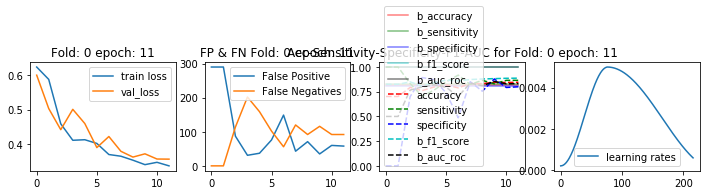

Epoch 12 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 12 completed.
Validation metrics
_________________________________________ METRICS for epoch 12 _______________________________________________________
accuracy         :0.84173   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88490   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.78276   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82476   bmark:(1.0000)  spe.beaten:False
precision        :0.9038167938931297 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:63   |
| fn:91   | tn:227  |
---------------------


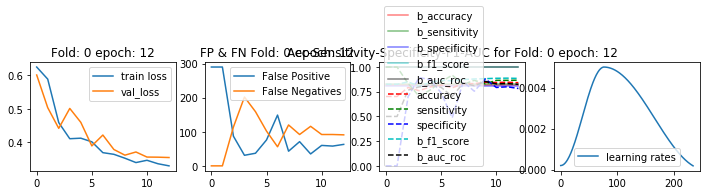

Epoch 13 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 13 completed.
Validation metrics
_________________________________________ METRICS for epoch 13 _______________________________________________________
accuracy         :0.84687   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88805   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86530   bmark:(0.8277)  sen.beaten:True
specificity      :0.80345   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83437   bmark:(1.0000)  spe.beaten:False
precision        :0.9120370370370371 
recall           :0.8653001464128843
---------------------
| tp:591  | fp:57   |
| fn:92   | tn:233  |
---------------------


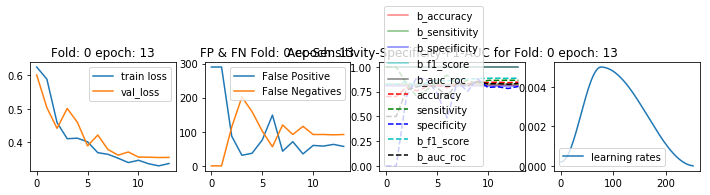

Epoch 14 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 14 completed.
Validation metrics
_________________________________________ METRICS for epoch 14 _______________________________________________________
accuracy         :0.84378   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88623   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.78966   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82821   bmark:(1.0000)  spe.beaten:False
precision        :0.9065849923430321 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:61   |
| fn:91   | tn:229  |
---------------------


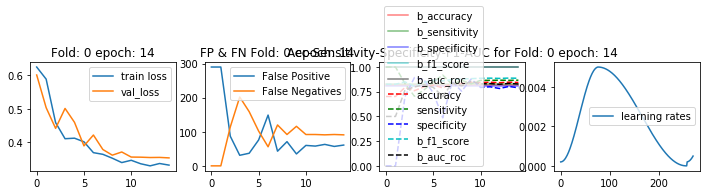

Epoch 15 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 15 completed.
Validation metrics
_________________________________________ METRICS for epoch 15 _______________________________________________________
accuracy         :0.85200   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89074   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.85944   bmark:(0.8277)  sen.beaten:True
specificity      :0.83448   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84696   bmark:(1.0000)  spe.beaten:False
precision        :0.9244094488188976 
recall           :0.8594436310395315
---------------------
| tp:587  | fp:48   |
| fn:96   | tn:242  |
---------------------


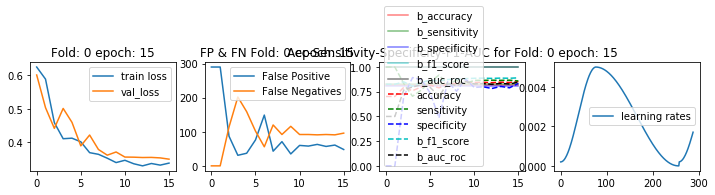

Epoch 16 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 16 completed.
Validation metrics
_________________________________________ METRICS for epoch 16 _______________________________________________________
accuracy         :0.78314   bmark:(0.8169)  accuracy beaten:False
f1_score         :0.86109   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.95754   bmark:(0.8277)  sen.beaten:True
specificity      :0.37241   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.66498   bmark:(1.0000)  spe.beaten:False
precision        :0.7822966507177034 
recall           :0.9575402635431918
---------------------
| tp:654  | fp:182  |
| fn:29   | tn:108  |
---------------------


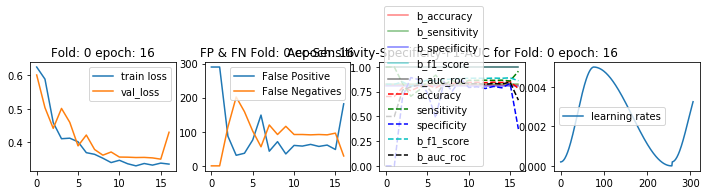

Epoch 17 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 17 completed.
Validation metrics
_________________________________________ METRICS for epoch 17 _______________________________________________________
accuracy         :0.83762   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.87598   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.81698   bmark:(0.8277)  sen.beaten:False
specificity      :0.88621   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85160   bmark:(1.0000)  spe.beaten:False
precision        :0.9441624365482234 
recall           :0.8169838945827232
---------------------
| tp:558  | fp:33   |
| fn:125  | tn:257  |
---------------------


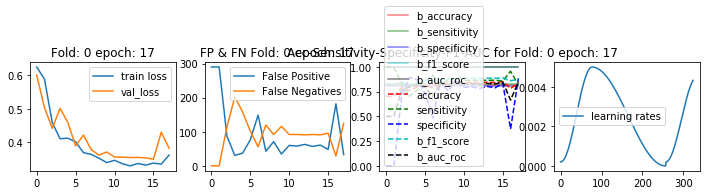

Epoch 18 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 18 completed.
Validation metrics
_________________________________________ METRICS for epoch 18 _______________________________________________________
accuracy         :0.83350   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88175   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88433   bmark:(0.8277)  sen.beaten:True
specificity      :0.71379   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.79906   bmark:(1.0000)  spe.beaten:False
precision        :0.8791848617176128 
recall           :0.8843338213762811
---------------------
| tp:604  | fp:83   |
| fn:79   | tn:207  |
---------------------


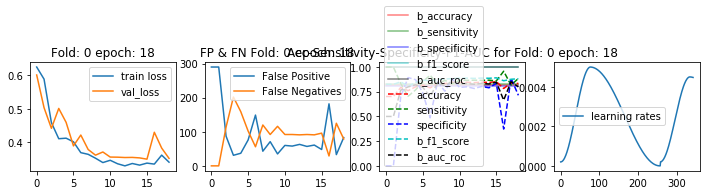

Epoch 19 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 19 completed.
Validation metrics
_________________________________________ METRICS for epoch 19 _______________________________________________________
accuracy         :0.84275   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88742   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88287   bmark:(0.8277)  sen.beaten:True
specificity      :0.74828   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81557   bmark:(1.0000)  spe.beaten:False
precision        :0.8920118343195266 
recall           :0.8828696925329429
---------------------
| tp:603  | fp:73   |
| fn:80   | tn:217  |
---------------------


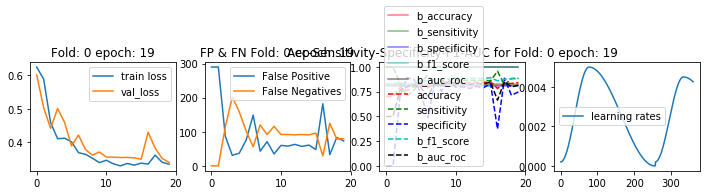

Epoch 20 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 20 completed.
Validation metrics
_________________________________________ METRICS for epoch 20 _______________________________________________________
accuracy         :0.85200   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89205   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87116   bmark:(0.8277)  sen.beaten:True
specificity      :0.80690   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.83903   bmark:(1.0000)  spe.beaten:False
precision        :0.9139784946236559 
recall           :0.8711566617862372
---------------------
| tp:595  | fp:56   |
| fn:88   | tn:234  |
---------------------


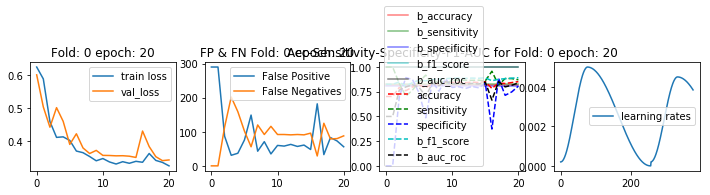

Epoch 21 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 21 completed.
Validation metrics
_________________________________________ METRICS for epoch 21 _______________________________________________________
accuracy         :0.84275   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88641   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87408   bmark:(0.8277)  sen.beaten:True
specificity      :0.76897   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82153   bmark:(1.0000)  spe.beaten:False
precision        :0.8990963855421686 
recall           :0.8740849194729137
---------------------
| tp:597  | fp:67   |
| fn:86   | tn:223  |
---------------------


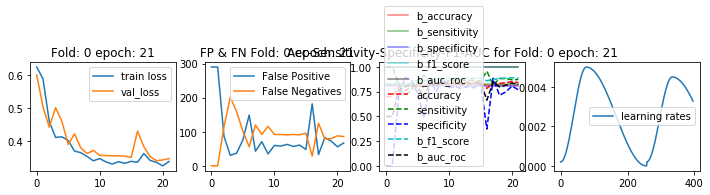

Epoch 22 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 22 completed.
Validation metrics
_________________________________________ METRICS for epoch 22 _______________________________________________________
accuracy         :0.84995   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89088   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87262   bmark:(0.8277)  sen.beaten:True
specificity      :0.79655   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83459   bmark:(1.0000)  spe.beaten:False
precision        :0.9099236641221374 
recall           :0.8726207906295754
---------------------
| tp:596  | fp:59   |
| fn:87   | tn:231  |
---------------------


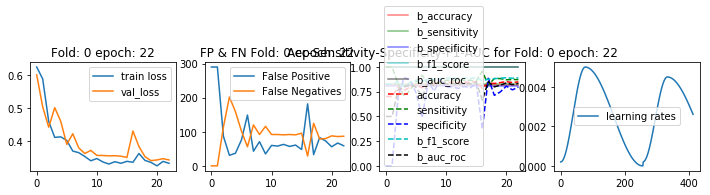

Epoch 23 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 23 completed.
Validation metrics
_________________________________________ METRICS for epoch 23 _______________________________________________________
accuracy         :0.84275   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88742   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88287   bmark:(0.8277)  sen.beaten:True
specificity      :0.74828   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81557   bmark:(1.0000)  spe.beaten:False
precision        :0.8920118343195266 
recall           :0.8828696925329429
---------------------
| tp:603  | fp:73   |
| fn:80   | tn:217  |
---------------------


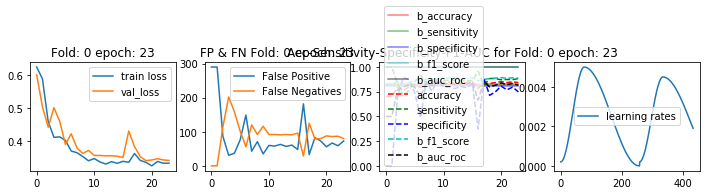

Epoch 24 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 24 completed.
Validation metrics
_________________________________________ METRICS for epoch 24 _______________________________________________________
accuracy         :0.84481   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88856   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88141   bmark:(0.8277)  sen.beaten:True
specificity      :0.75862   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82001   bmark:(1.0000)  spe.beaten:False
precision        :0.8958333333333334 
recall           :0.8814055636896047
---------------------
| tp:602  | fp:70   |
| fn:81   | tn:220  |
---------------------


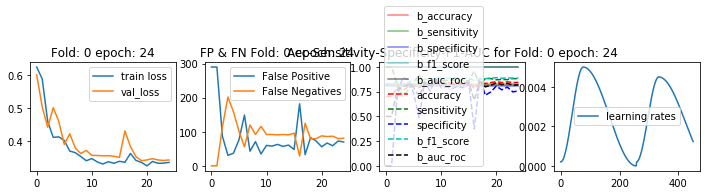

Epoch 25 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 25 completed.
Validation metrics
_________________________________________ METRICS for epoch 25 _______________________________________________________
accuracy         :0.85714   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89494   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.83448   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85062   bmark:(1.0000)  spe.beaten:False
precision        :0.925 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:48   |
| fn:91   | tn:242  |
---------------------


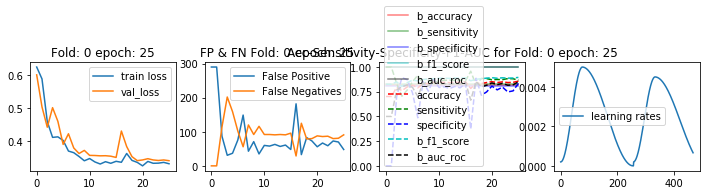

Epoch 26 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 26 completed.
Validation metrics
_________________________________________ METRICS for epoch 26 _______________________________________________________
accuracy         :0.86023   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89728   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86969   bmark:(0.8277)  sen.beaten:True
specificity      :0.83793   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85381   bmark:(1.0000)  spe.beaten:False
precision        :0.9266770670826833 
recall           :0.8696925329428989
---------------------
| tp:594  | fp:47   |
| fn:89   | tn:243  |
---------------------


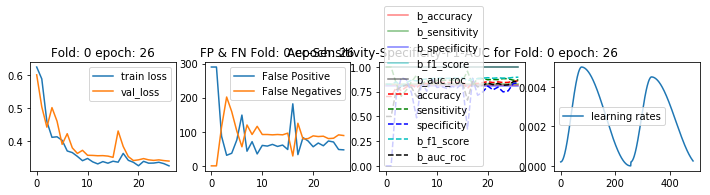

Epoch 27 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 27 completed.
Validation metrics
_________________________________________ METRICS for epoch 27 _______________________________________________________
accuracy         :0.86023   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89774   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87408   bmark:(0.8277)  sen.beaten:True
specificity      :0.82759   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85084   bmark:(1.0000)  spe.beaten:False
precision        :0.9227202472952086 
recall           :0.8740849194729137
---------------------
| tp:597  | fp:50   |
| fn:86   | tn:240  |
---------------------


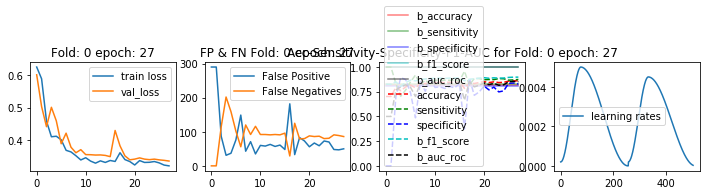

Epoch 28 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 28 completed.
Validation metrics
_________________________________________ METRICS for epoch 28 _______________________________________________________
accuracy         :0.86023   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89744   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87116   bmark:(0.8277)  sen.beaten:True
specificity      :0.83448   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85282   bmark:(1.0000)  spe.beaten:False
precision        :0.9253499222395023 
recall           :0.8711566617862372
---------------------
| tp:595  | fp:48   |
| fn:88   | tn:242  |
---------------------


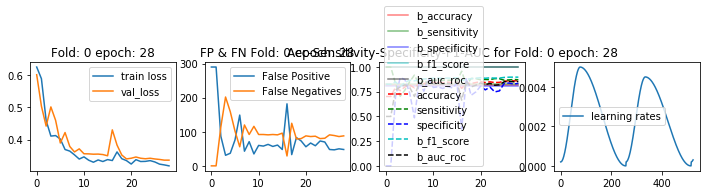

Epoch 29 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 29 completed.
Validation metrics
_________________________________________ METRICS for epoch 29 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89561   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.83793   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85235   bmark:(1.0000)  spe.beaten:False
precision        :0.9264475743348983 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:47   |
| fn:91   | tn:243  |
---------------------


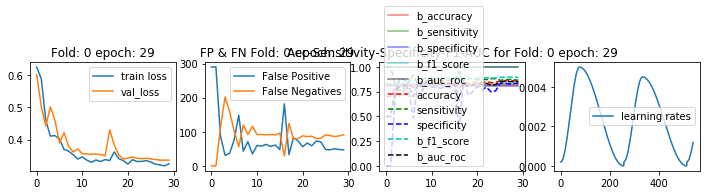

Epoch 30 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 30 completed.
Validation metrics
_________________________________________ METRICS for epoch 30 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89419   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87848   bmark:(0.8277)  sen.beaten:True
specificity      :0.79655   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83751   bmark:(1.0000)  spe.beaten:False
precision        :0.9104704097116844 
recall           :0.8784773060029283
---------------------
| tp:600  | fp:59   |
| fn:83   | tn:231  |
---------------------


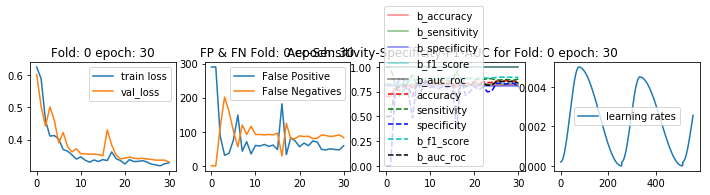

Epoch 31 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 31 completed.
Validation metrics
_________________________________________ METRICS for epoch 31 _______________________________________________________
accuracy         :0.83762   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.87340   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.79795   bmark:(0.8277)  sen.beaten:False
specificity      :0.93103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86449   bmark:(1.0000)  spe.beaten:False
precision        :0.9646017699115044 
recall           :0.7979502196193266
---------------------
| tp:545  | fp:20   |
| fn:138  | tn:270  |
---------------------


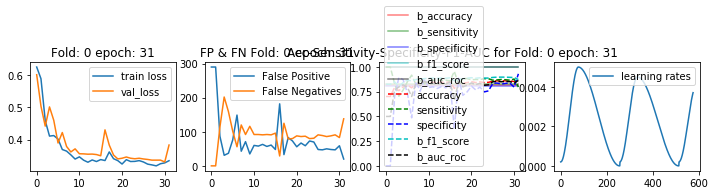

Epoch 32 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 32 completed.
Validation metrics
_________________________________________ METRICS for epoch 32 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89242   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86237   bmark:(0.8277)  sen.beaten:True
specificity      :0.83448   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84843   bmark:(1.0000)  spe.beaten:False
precision        :0.9246467817896389 
recall           :0.862371888726208
---------------------
| tp:589  | fp:48   |
| fn:94   | tn:242  |
---------------------


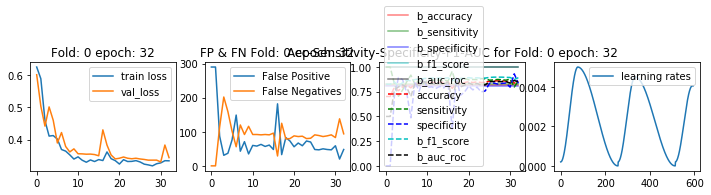

Epoch 33 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 33 completed.
Validation metrics
_________________________________________ METRICS for epoch 33 _______________________________________________________
accuracy         :0.83762   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88517   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.89165   bmark:(0.8277)  sen.beaten:True
specificity      :0.71034   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.80100   bmark:(1.0000)  spe.beaten:False
precision        :0.8787878787878788 
recall           :0.8916544655929722
---------------------
| tp:609  | fp:84   |
| fn:74   | tn:206  |
---------------------


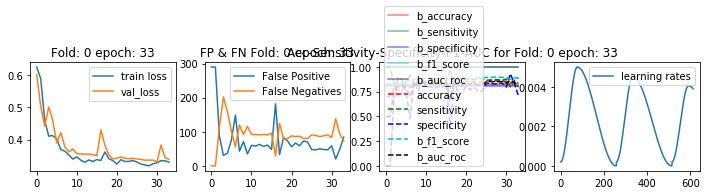

Epoch 34 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 34 completed.
Validation metrics
_________________________________________ METRICS for epoch 34 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89162   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.84919   bmark:(0.8277)  sen.beaten:True
specificity      :0.86897   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85908   bmark:(1.0000)  spe.beaten:False
precision        :0.9385113268608414 
recall           :0.849194729136164
---------------------
| tp:580  | fp:38   |
| fn:103  | tn:252  |
---------------------


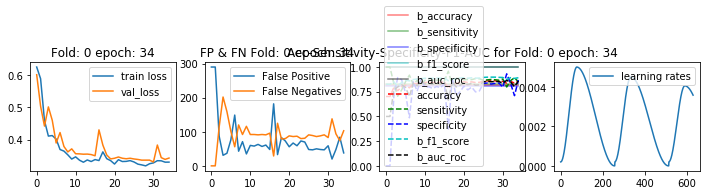

Epoch 35 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 35 completed.
Validation metrics
_________________________________________ METRICS for epoch 35 _______________________________________________________
accuracy         :0.84687   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88295   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.82284   bmark:(0.8277)  sen.beaten:False
specificity      :0.90345   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86314   bmark:(1.0000)  spe.beaten:False
precision        :0.9525423728813559 
recall           :0.8228404099560761
---------------------
| tp:562  | fp:28   |
| fn:121  | tn:262  |
---------------------


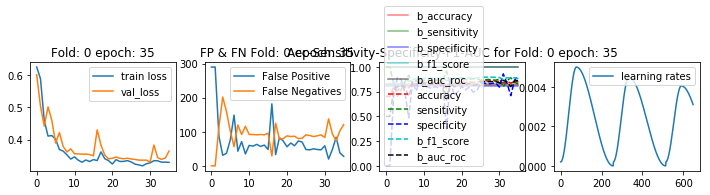

Epoch 36 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 36 completed.
Validation metrics
_________________________________________ METRICS for epoch 36 _______________________________________________________
accuracy         :0.83864   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88515   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88580   bmark:(0.8277)  sen.beaten:True
specificity      :0.72759   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.80669   bmark:(1.0000)  spe.beaten:False
precision        :0.8845029239766082 
recall           :0.8857979502196194
---------------------
| tp:605  | fp:79   |
| fn:78   | tn:211  |
---------------------


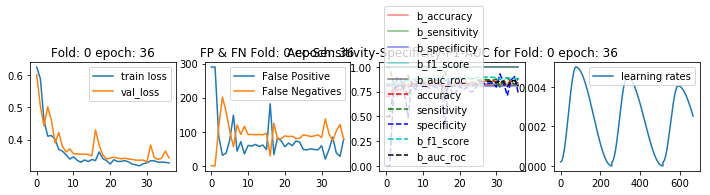

Epoch 37 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 37 completed.
Validation metrics
_________________________________________ METRICS for epoch 37 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89426   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.83103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84890   bmark:(1.0000)  spe.beaten:False
precision        :0.9235569422776911 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:49   |
| fn:91   | tn:241  |
---------------------


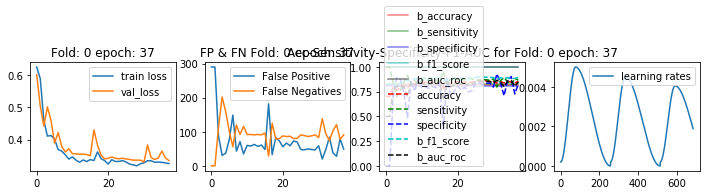

Epoch 38 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 38 completed.
Validation metrics
_________________________________________ METRICS for epoch 38 _______________________________________________________
accuracy         :0.86023   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89713   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86823   bmark:(0.8277)  sen.beaten:True
specificity      :0.84138   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85480   bmark:(1.0000)  spe.beaten:False
precision        :0.9280125195618153 
recall           :0.8682284040995608
---------------------
| tp:593  | fp:46   |
| fn:90   | tn:244  |
---------------------


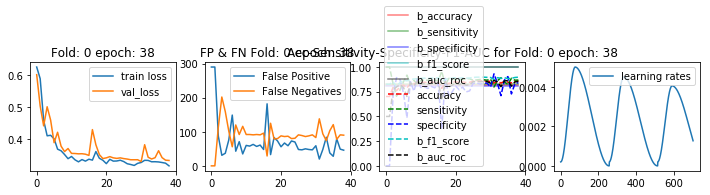

Epoch 39 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 39 completed.
Validation metrics
_________________________________________ METRICS for epoch 39 _______________________________________________________
accuracy         :0.85714   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89397   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.85798   bmark:(0.8277)  sen.beaten:True
specificity      :0.85517   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85658   bmark:(1.0000)  spe.beaten:False
precision        :0.9331210191082803 
recall           :0.8579795021961932
---------------------
| tp:586  | fp:42   |
| fn:97   | tn:248  |
---------------------


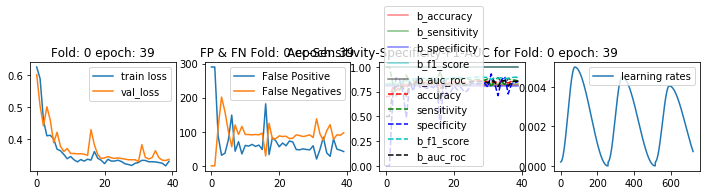

Epoch 40 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 40 completed.
Validation metrics
_________________________________________ METRICS for epoch 40 _______________________________________________________
accuracy         :0.85714   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89446   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86237   bmark:(0.8277)  sen.beaten:True
specificity      :0.84483   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85360   bmark:(1.0000)  spe.beaten:False
precision        :0.9290220820189274 
recall           :0.862371888726208
---------------------
| tp:589  | fp:45   |
| fn:94   | tn:245  |
---------------------


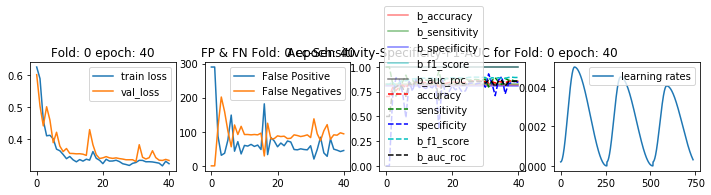

Epoch 41 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 41 completed.
Validation metrics
_________________________________________ METRICS for epoch 41 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89561   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.83793   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85235   bmark:(1.0000)  spe.beaten:False
precision        :0.9264475743348983 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:47   |
| fn:91   | tn:243  |
---------------------


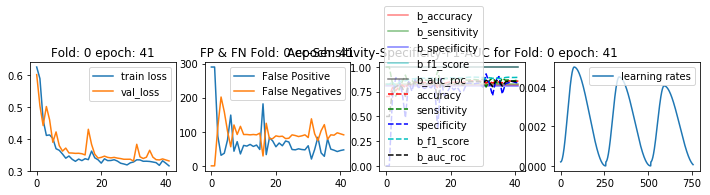

Epoch 42 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 42 completed.
Validation metrics
_________________________________________ METRICS for epoch 42 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89378   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86237   bmark:(0.8277)  sen.beaten:True
specificity      :0.84138   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85188   bmark:(1.0000)  spe.beaten:False
precision        :0.9275590551181102 
recall           :0.862371888726208
---------------------
| tp:589  | fp:46   |
| fn:94   | tn:244  |
---------------------


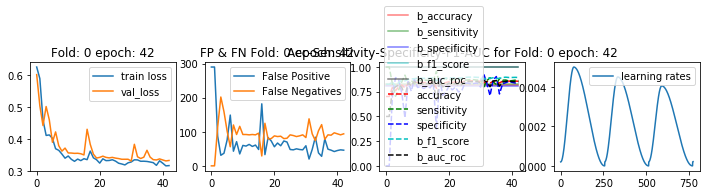

Epoch 43 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 43 completed.
Validation metrics
_________________________________________ METRICS for epoch 43 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89561   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.83793   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85235   bmark:(1.0000)  spe.beaten:False
precision        :0.9264475743348983 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:47   |
| fn:91   | tn:243  |
---------------------


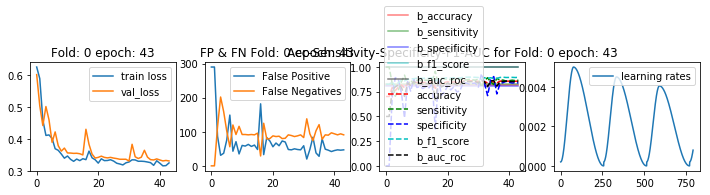

Epoch 44 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 44 completed.
Validation metrics
_________________________________________ METRICS for epoch 44 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88975   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83895   bmark:(0.8277)  sen.beaten:True
specificity      :0.88966   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86430   bmark:(1.0000)  spe.beaten:False
precision        :0.947107438016529 
recall           :0.8389458272327965
---------------------
| tp:573  | fp:32   |
| fn:110  | tn:258  |
---------------------


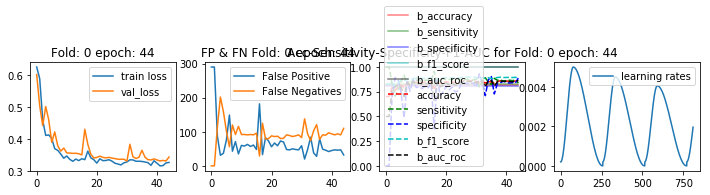

Epoch 45 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 45 completed.
Validation metrics
_________________________________________ METRICS for epoch 45 _______________________________________________________
accuracy         :0.85098   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88681   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83163   bmark:(0.8277)  sen.beaten:True
specificity      :0.89655   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86409   bmark:(1.0000)  spe.beaten:False
precision        :0.9498327759197325 
recall           :0.8316251830161054
---------------------
| tp:568  | fp:30   |
| fn:115  | tn:260  |
---------------------


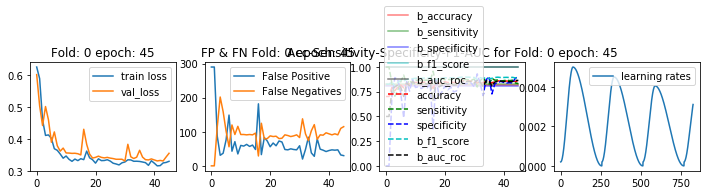

Epoch 46 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 46 completed.
Validation metrics
_________________________________________ METRICS for epoch 46 _______________________________________________________
accuracy         :0.85714   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89557   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87262   bmark:(0.8277)  sen.beaten:True
specificity      :0.82069   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84666   bmark:(1.0000)  spe.beaten:False
precision        :0.9197530864197531 
recall           :0.8726207906295754
---------------------
| tp:596  | fp:52   |
| fn:87   | tn:238  |
---------------------


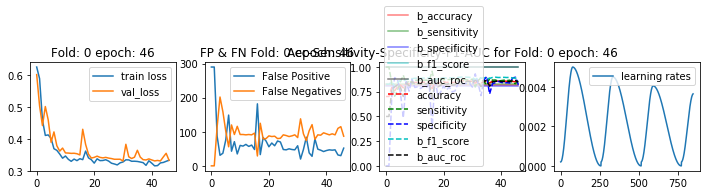

Epoch 47 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 47 completed.
Validation metrics
_________________________________________ METRICS for epoch 47 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89027   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83748   bmark:(0.8277)  sen.beaten:True
specificity      :0.89655   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86702   bmark:(1.0000)  spe.beaten:False
precision        :0.9501661129568106 
recall           :0.8374816983894583
---------------------
| tp:572  | fp:30   |
| fn:111  | tn:260  |
---------------------


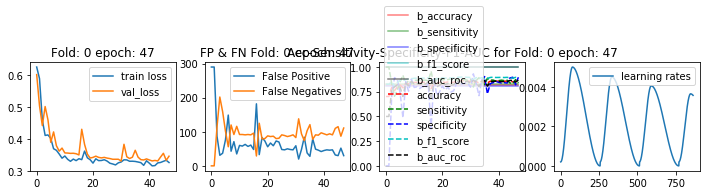

Epoch 48 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 48 completed.
Validation metrics
_________________________________________ METRICS for epoch 48 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88889   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83163   bmark:(0.8277)  sen.beaten:True
specificity      :0.90690   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86926   bmark:(1.0000)  spe.beaten:False
precision        :0.9546218487394958 
recall           :0.8316251830161054
---------------------
| tp:568  | fp:27   |
| fn:115  | tn:263  |
---------------------


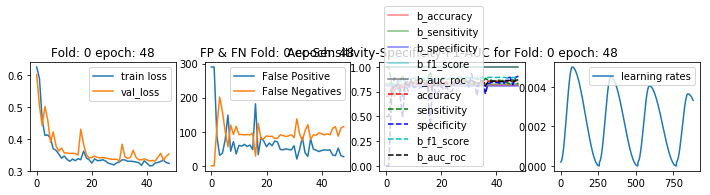

Epoch 49 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 49 completed.
Validation metrics
_________________________________________ METRICS for epoch 49 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89329   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.85798   bmark:(0.8277)  sen.beaten:True
specificity      :0.85172   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85485   bmark:(1.0000)  spe.beaten:False
precision        :0.931637519872814 
recall           :0.8579795021961932
---------------------
| tp:586  | fp:43   |
| fn:97   | tn:247  |
---------------------


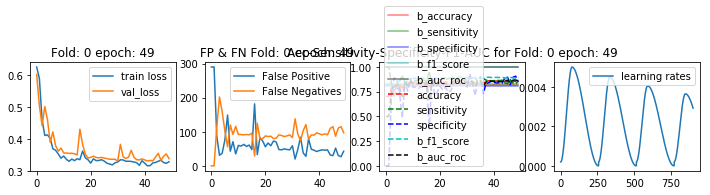

Epoch 50 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 50 completed.
Validation metrics
_________________________________________ METRICS for epoch 50 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89043   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.84480   bmark:(0.8277)  sen.beaten:True
specificity      :0.87586   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86033   bmark:(1.0000)  spe.beaten:False
precision        :0.9412724306688418 
recall           :0.8448023426061494
---------------------
| tp:577  | fp:36   |
| fn:106  | tn:254  |
---------------------


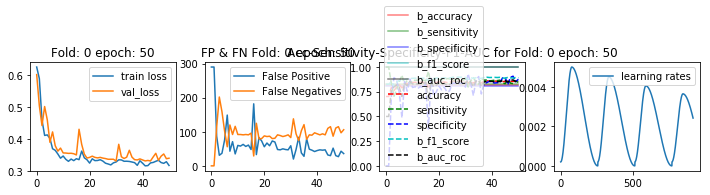

Epoch 51 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 51 completed.
Validation metrics
_________________________________________ METRICS for epoch 51 _______________________________________________________
accuracy         :0.85714   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89696   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88580   bmark:(0.8277)  sen.beaten:True
specificity      :0.78966   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83773   bmark:(1.0000)  spe.beaten:False
precision        :0.9084084084084084 
recall           :0.8857979502196194
---------------------
| tp:605  | fp:61   |
| fn:78   | tn:229  |
---------------------


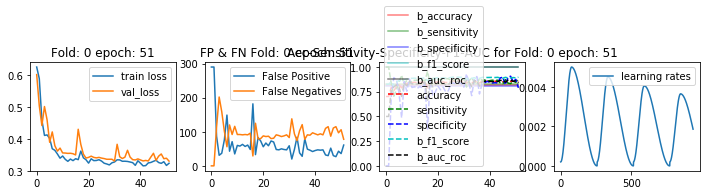

Epoch 52 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 52 completed.
Validation metrics
_________________________________________ METRICS for epoch 52 _______________________________________________________
accuracy         :0.85303   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89352   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87848   bmark:(0.8277)  sen.beaten:True
specificity      :0.79310   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83579   bmark:(1.0000)  spe.beaten:False
precision        :0.9090909090909091 
recall           :0.8784773060029283
---------------------
| tp:600  | fp:60   |
| fn:83   | tn:230  |
---------------------


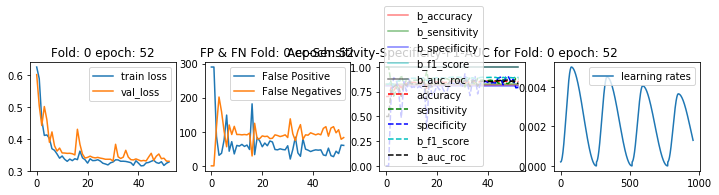

Epoch 53 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 53 completed.
Validation metrics
_________________________________________ METRICS for epoch 53 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89450   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88141   bmark:(0.8277)  sen.beaten:True
specificity      :0.78966   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83553   bmark:(1.0000)  spe.beaten:False
precision        :0.9079939668174962 
recall           :0.8814055636896047
---------------------
| tp:602  | fp:61   |
| fn:81   | tn:229  |
---------------------


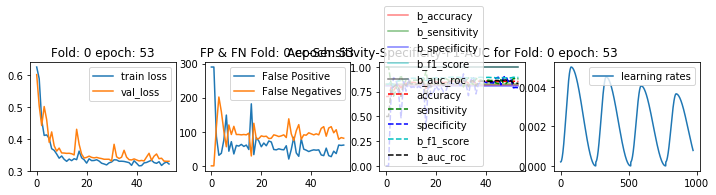

Epoch 54 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 54 completed.
Validation metrics
_________________________________________ METRICS for epoch 54 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89358   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.82759   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84718   bmark:(1.0000)  spe.beaten:False
precision        :0.9221183800623053 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:50   |
| fn:91   | tn:240  |
---------------------


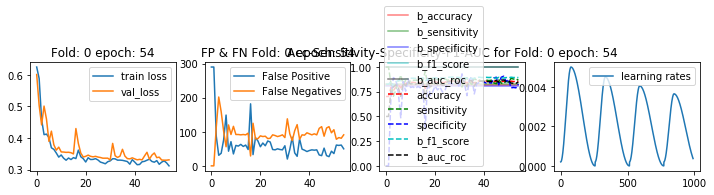

Epoch 55 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 55 completed.
Validation metrics
_________________________________________ METRICS for epoch 55 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89339   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87116   bmark:(0.8277)  sen.beaten:True
specificity      :0.81379   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84247   bmark:(1.0000)  spe.beaten:False
precision        :0.9167950693374423 
recall           :0.8711566617862372
---------------------
| tp:595  | fp:54   |
| fn:88   | tn:236  |
---------------------


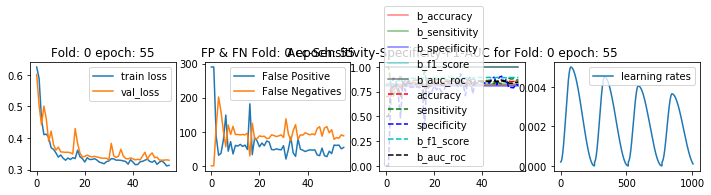

Epoch 56 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 56 completed.
Validation metrics
_________________________________________ METRICS for epoch 56 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89307   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86823   bmark:(0.8277)  sen.beaten:True
specificity      :0.82069   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84446   bmark:(1.0000)  spe.beaten:False
precision        :0.9193798449612403 
recall           :0.8682284040995608
---------------------
| tp:593  | fp:52   |
| fn:90   | tn:238  |
---------------------


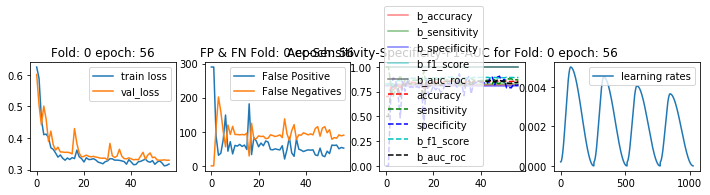

Epoch 57 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 57 completed.
Validation metrics
_________________________________________ METRICS for epoch 57 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89537   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87701   bmark:(0.8277)  sen.beaten:True
specificity      :0.80690   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84195   bmark:(1.0000)  spe.beaten:False
precision        :0.9145038167938931 
recall           :0.87701317715959
---------------------
| tp:599  | fp:56   |
| fn:84   | tn:234  |
---------------------


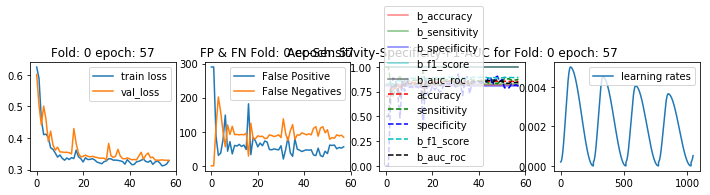

Epoch 58 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 58 completed.
Validation metrics
_________________________________________ METRICS for epoch 58 _______________________________________________________
accuracy         :0.85098   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88610   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.82577   bmark:(0.8277)  sen.beaten:False
specificity      :0.91034   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86806   bmark:(1.0000)  spe.beaten:False
precision        :0.9559322033898305 
recall           :0.8257686676427526
---------------------
| tp:564  | fp:26   |
| fn:119  | tn:264  |
---------------------


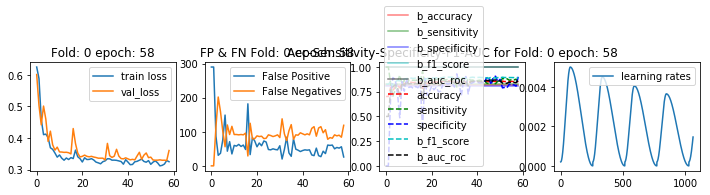

Epoch 59 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 59 completed.
Validation metrics
_________________________________________ METRICS for epoch 59 _______________________________________________________
accuracy         :0.82425   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.86154   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.77892   bmark:(0.8277)  sen.beaten:False
specificity      :0.93103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85498   bmark:(1.0000)  spe.beaten:False
precision        :0.9637681159420289 
recall           :0.7789165446559297
---------------------
| tp:532  | fp:20   |
| fn:151  | tn:270  |
---------------------


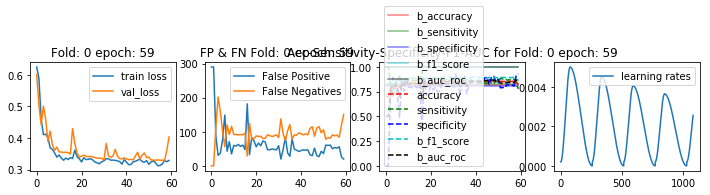

Epoch 60 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 60 completed.
Validation metrics
_________________________________________ METRICS for epoch 60 _______________________________________________________
accuracy         :0.84892   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88578   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83455   bmark:(0.8277)  sen.beaten:True
specificity      :0.88276   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85866   bmark:(1.0000)  spe.beaten:False
precision        :0.9437086092715232 
recall           :0.8345534407027818
---------------------
| tp:570  | fp:34   |
| fn:113  | tn:256  |
---------------------


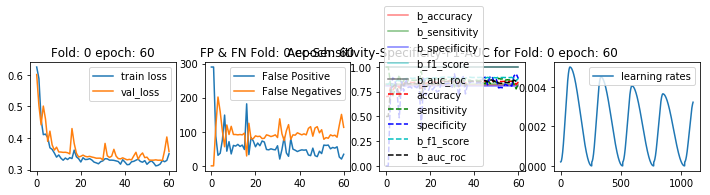

Epoch 61 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 61 completed.
Validation metrics
_________________________________________ METRICS for epoch 61 _______________________________________________________
accuracy         :0.84481   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88889   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88433   bmark:(0.8277)  sen.beaten:True
specificity      :0.75172   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81803   bmark:(1.0000)  spe.beaten:False
precision        :0.893491124260355 
recall           :0.8843338213762811
---------------------
| tp:604  | fp:72   |
| fn:79   | tn:218  |
---------------------


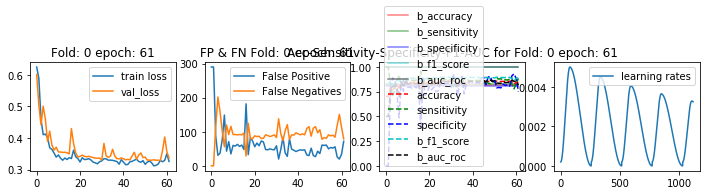

Epoch 62 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 62 completed.
Validation metrics
_________________________________________ METRICS for epoch 62 _______________________________________________________
accuracy         :0.84789   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89197   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.89458   bmark:(0.8277)  sen.beaten:True
specificity      :0.73793   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81626   bmark:(1.0000)  spe.beaten:False
precision        :0.8893740902474527 
recall           :0.8945827232796486
---------------------
| tp:611  | fp:76   |
| fn:72   | tn:214  |
---------------------


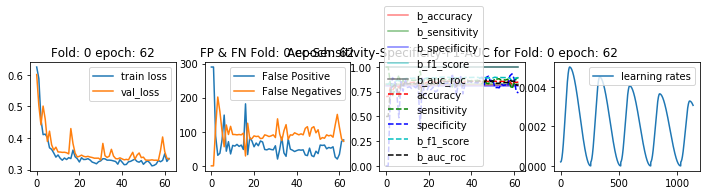

Epoch 63 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 63 completed.
Validation metrics
_________________________________________ METRICS for epoch 63 _______________________________________________________
accuracy         :0.82528   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.86246   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.78038   bmark:(0.8277)  sen.beaten:False
specificity      :0.93103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85571   bmark:(1.0000)  spe.beaten:False
precision        :0.9638336347197106 
recall           :0.780380673499268
---------------------
| tp:533  | fp:20   |
| fn:150  | tn:270  |
---------------------


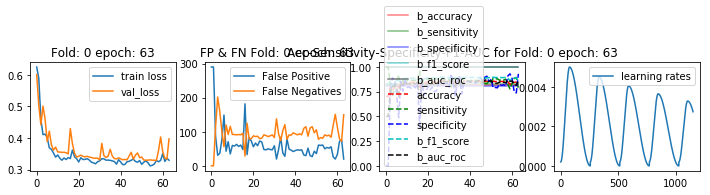

Epoch 64 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 64 completed.
Validation metrics
_________________________________________ METRICS for epoch 64 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89026   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.84334   bmark:(0.8277)  sen.beaten:True
specificity      :0.87931   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86132   bmark:(1.0000)  spe.beaten:False
precision        :0.9427168576104746 
recall           :0.8433382137628112
---------------------
| tp:576  | fp:35   |
| fn:107  | tn:255  |
---------------------


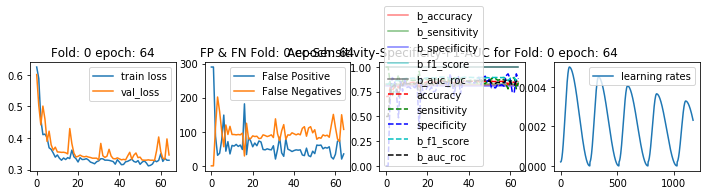

Epoch 65 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 65 completed.
Validation metrics
_________________________________________ METRICS for epoch 65 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89474   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87116   bmark:(0.8277)  sen.beaten:True
specificity      :0.82069   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84592   bmark:(1.0000)  spe.beaten:False
precision        :0.919629057187017 
recall           :0.8711566617862372
---------------------
| tp:595  | fp:52   |
| fn:88   | tn:238  |
---------------------


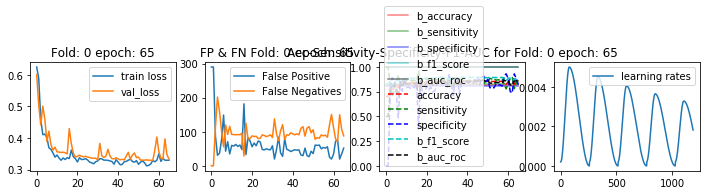

Epoch 66 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 66 completed.
Validation metrics
_________________________________________ METRICS for epoch 66 _______________________________________________________
accuracy         :0.84687   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89116   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.89312   bmark:(0.8277)  sen.beaten:True
specificity      :0.73793   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81552   bmark:(1.0000)  spe.beaten:False
precision        :0.8892128279883382 
recall           :0.8931185944363104
---------------------
| tp:610  | fp:76   |
| fn:73   | tn:214  |
---------------------


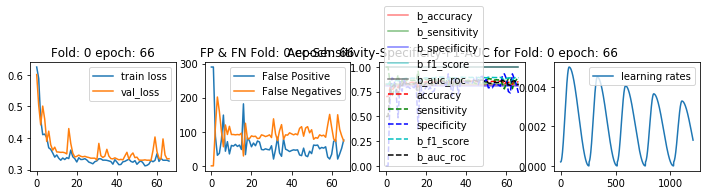

Epoch 67 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 67 completed.
Validation metrics
_________________________________________ METRICS for epoch 67 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89732   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88287   bmark:(0.8277)  sen.beaten:True
specificity      :0.80000   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.84143   bmark:(1.0000)  spe.beaten:False
precision        :0.9122541603630863 
recall           :0.8828696925329429
---------------------
| tp:603  | fp:58   |
| fn:80   | tn:232  |
---------------------


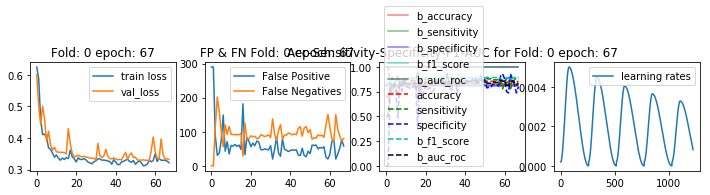

Epoch 68 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 68 completed.
Validation metrics
_________________________________________ METRICS for epoch 68 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89307   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86823   bmark:(0.8277)  sen.beaten:True
specificity      :0.82069   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84446   bmark:(1.0000)  spe.beaten:False
precision        :0.9193798449612403 
recall           :0.8682284040995608
---------------------
| tp:593  | fp:52   |
| fn:90   | tn:238  |
---------------------


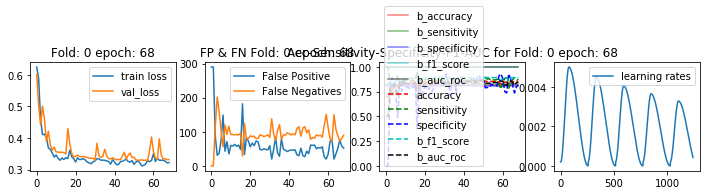

Epoch 69 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 69 completed.
Validation metrics
_________________________________________ METRICS for epoch 69 _______________________________________________________
accuracy         :0.85920   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89722   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87555   bmark:(0.8277)  sen.beaten:True
specificity      :0.82069   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84812   bmark:(1.0000)  spe.beaten:False
precision        :0.92 
recall           :0.8755490483162518
---------------------
| tp:598  | fp:52   |
| fn:85   | tn:238  |
---------------------


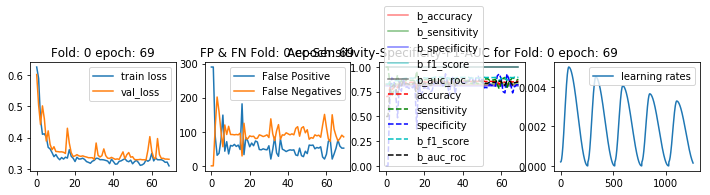

Epoch 70 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 70 completed.
Validation metrics
_________________________________________ METRICS for epoch 70 _______________________________________________________
accuracy         :0.86023   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89805   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87701   bmark:(0.8277)  sen.beaten:True
specificity      :0.82069   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84885   bmark:(1.0000)  spe.beaten:False
precision        :0.9201228878648233 
recall           :0.87701317715959
---------------------
| tp:599  | fp:52   |
| fn:84   | tn:238  |
---------------------


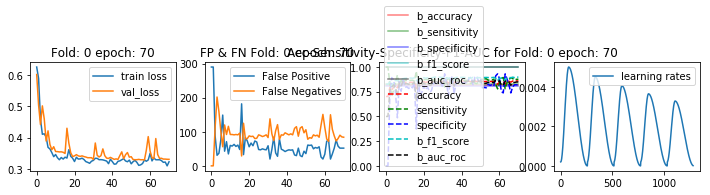

Epoch 71 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 71 completed.
Validation metrics
_________________________________________ METRICS for epoch 71 _______________________________________________________
accuracy         :0.85920   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89784   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88141   bmark:(0.8277)  sen.beaten:True
specificity      :0.80690   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84415   bmark:(1.0000)  spe.beaten:False
precision        :0.9148936170212766 
recall           :0.8814055636896047
---------------------
| tp:602  | fp:56   |
| fn:81   | tn:234  |
---------------------


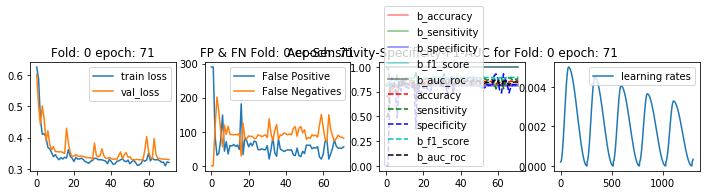

Epoch 72 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 72 completed.
Validation metrics
_________________________________________ METRICS for epoch 72 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89579   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88726   bmark:(0.8277)  sen.beaten:True
specificity      :0.77931   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83329   bmark:(1.0000)  spe.beaten:False
precision        :0.9044776119402985 
recall           :0.8872620790629575
---------------------
| tp:606  | fp:64   |
| fn:77   | tn:226  |
---------------------


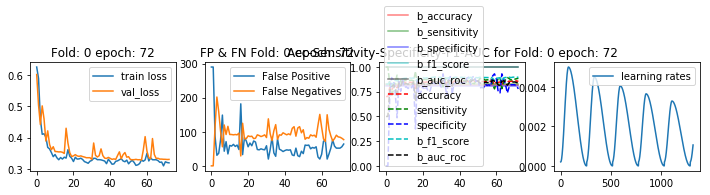

Epoch 73 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 73 completed.
Validation metrics
_________________________________________ METRICS for epoch 73 _______________________________________________________
accuracy         :0.83659   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88618   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.90630   bmark:(0.8277)  sen.beaten:True
specificity      :0.67241   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.78935   bmark:(1.0000)  spe.beaten:False
precision        :0.8669467787114846 
recall           :0.9062957540263543
---------------------
| tp:619  | fp:95   |
| fn:64   | tn:195  |
---------------------


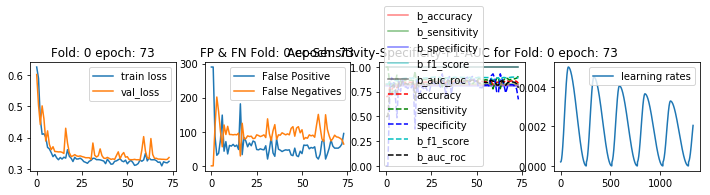

Epoch 74 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 74 completed.
Validation metrics
_________________________________________ METRICS for epoch 74 _______________________________________________________
accuracy         :0.83864   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88615   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.89458   bmark:(0.8277)  sen.beaten:True
specificity      :0.70690   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.80074   bmark:(1.0000)  spe.beaten:False
precision        :0.8778735632183908 
recall           :0.8945827232796486
---------------------
| tp:611  | fp:85   |
| fn:72   | tn:205  |
---------------------


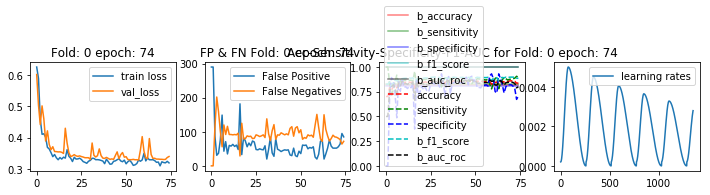

Epoch 75 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 75 completed.
Validation metrics
_________________________________________ METRICS for epoch 75 _______________________________________________________
accuracy         :0.86023   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89759   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87262   bmark:(0.8277)  sen.beaten:True
specificity      :0.83103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85183   bmark:(1.0000)  spe.beaten:False
precision        :0.924031007751938 
recall           :0.8726207906295754
---------------------
| tp:596  | fp:49   |
| fn:87   | tn:241  |
---------------------


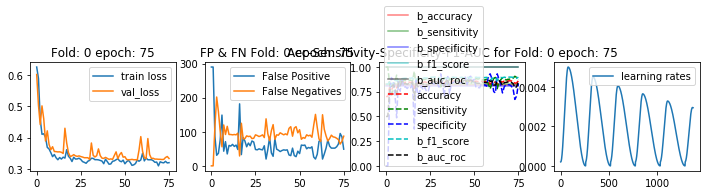

Epoch 76 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 76 completed.
Validation metrics
_________________________________________ METRICS for epoch 76 _______________________________________________________
accuracy         :0.84687   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89036   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88580   bmark:(0.8277)  sen.beaten:True
specificity      :0.75517   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82049   bmark:(1.0000)  spe.beaten:False
precision        :0.8949704142011834 
recall           :0.8857979502196194
---------------------
| tp:605  | fp:71   |
| fn:78   | tn:219  |
---------------------


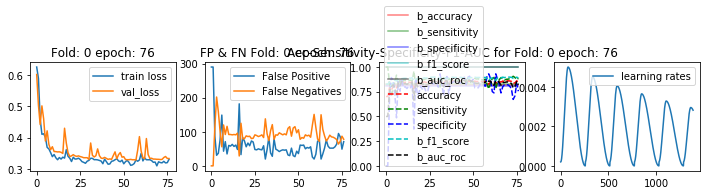

Epoch 77 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 77 completed.
Validation metrics
_________________________________________ METRICS for epoch 77 _______________________________________________________
accuracy         :0.85200   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88732   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.83016   bmark:(0.8277)  sen.beaten:True
specificity      :0.90345   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86680   bmark:(1.0000)  spe.beaten:False
precision        :0.9529411764705882 
recall           :0.8301610541727672
---------------------
| tp:567  | fp:28   |
| fn:116  | tn:262  |
---------------------


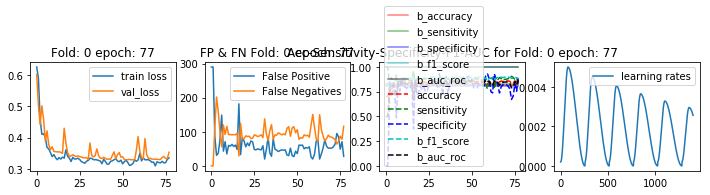

Epoch 78 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 78 completed.
Validation metrics
_________________________________________ METRICS for epoch 78 _______________________________________________________
accuracy         :0.85303   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88940   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.84187   bmark:(0.8277)  sen.beaten:True
specificity      :0.87931   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86059   bmark:(1.0000)  spe.beaten:False
precision        :0.9426229508196722 
recall           :0.8418740849194729
---------------------
| tp:575  | fp:35   |
| fn:108  | tn:255  |
---------------------


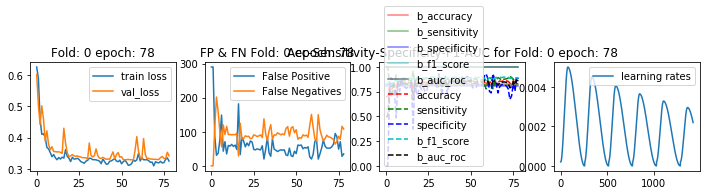

Epoch 79 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 79 completed.
Validation metrics
_________________________________________ METRICS for epoch 79 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89517   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88141   bmark:(0.8277)  sen.beaten:True
specificity      :0.79310   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83725   bmark:(1.0000)  spe.beaten:False
precision        :0.9093655589123867 
recall           :0.8814055636896047
---------------------
| tp:602  | fp:60   |
| fn:81   | tn:230  |
---------------------


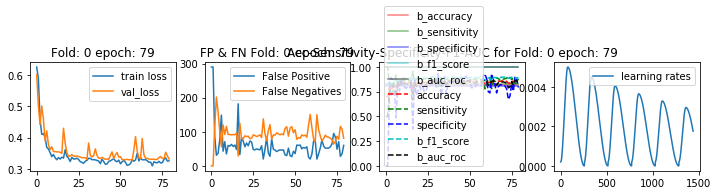

Epoch 80 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 80 completed.
Validation metrics
_________________________________________ METRICS for epoch 80 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89514   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86237   bmark:(0.8277)  sen.beaten:True
specificity      :0.84828   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85532   bmark:(1.0000)  spe.beaten:False
precision        :0.9304897314375987 
recall           :0.862371888726208
---------------------
| tp:589  | fp:44   |
| fn:94   | tn:246  |
---------------------


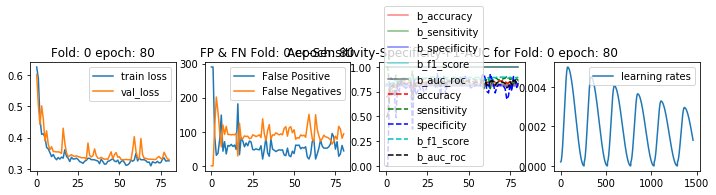

Epoch 81 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 81 completed.
Validation metrics
_________________________________________ METRICS for epoch 81 _______________________________________________________
accuracy         :0.85303   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89272   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87116   bmark:(0.8277)  sen.beaten:True
specificity      :0.81034   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84075   bmark:(1.0000)  spe.beaten:False
precision        :0.9153846153846154 
recall           :0.8711566617862372
---------------------
| tp:595  | fp:55   |
| fn:88   | tn:235  |
---------------------


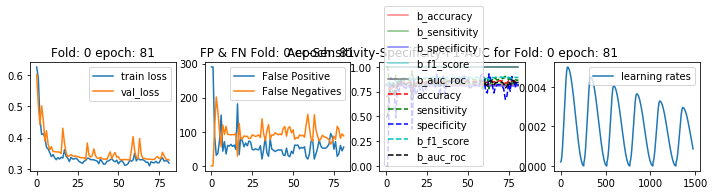

Epoch 82 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 82 completed.
Validation metrics
_________________________________________ METRICS for epoch 82 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89297   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.85505   bmark:(0.8277)  sen.beaten:True
specificity      :0.85862   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85684   bmark:(1.0000)  spe.beaten:False
precision        :0.9344 
recall           :0.8550512445095169
---------------------
| tp:584  | fp:41   |
| fn:99   | tn:249  |
---------------------


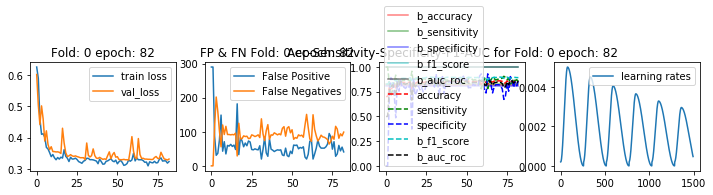

Epoch 83 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 83 completed.
Validation metrics
_________________________________________ METRICS for epoch 83 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89375   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86823   bmark:(0.8277)  sen.beaten:True
specificity      :0.82414   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84618   bmark:(1.0000)  spe.beaten:False
precision        :0.9208074534161491 
recall           :0.8682284040995608
---------------------
| tp:593  | fp:51   |
| fn:90   | tn:239  |
---------------------


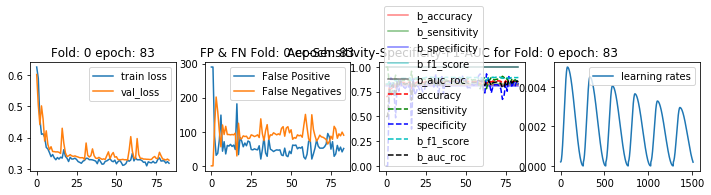

Epoch 84 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 84 completed.
Validation metrics
_________________________________________ METRICS for epoch 84 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89291   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86676   bmark:(0.8277)  sen.beaten:True
specificity      :0.82414   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84545   bmark:(1.0000)  spe.beaten:False
precision        :0.9206842923794712 
recall           :0.8667642752562226
---------------------
| tp:592  | fp:51   |
| fn:91   | tn:239  |
---------------------


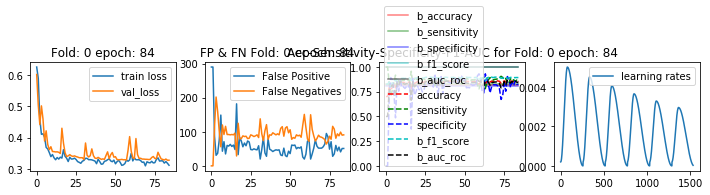

Epoch 85 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 85 completed.
Validation metrics
_________________________________________ METRICS for epoch 85 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89326   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86384   bmark:(0.8277)  sen.beaten:True
specificity      :0.83448   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84916   bmark:(1.0000)  spe.beaten:False
precision        :0.9247648902821317 
recall           :0.8638360175695461
---------------------
| tp:590  | fp:48   |
| fn:93   | tn:242  |
---------------------


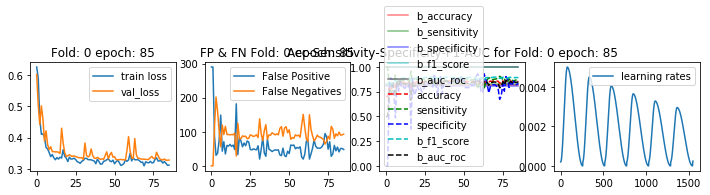

Epoch 86 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 86 completed.
Validation metrics
_________________________________________ METRICS for epoch 86 _______________________________________________________
accuracy         :0.85509   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89342   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86530   bmark:(0.8277)  sen.beaten:True
specificity      :0.83103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84817   bmark:(1.0000)  spe.beaten:False
precision        :0.9234375 
recall           :0.8653001464128843
---------------------
| tp:591  | fp:49   |
| fn:92   | tn:241  |
---------------------


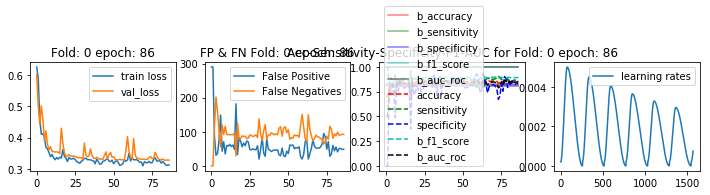

Epoch 87 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 87 completed.
Validation metrics
_________________________________________ METRICS for epoch 87 _______________________________________________________
accuracy         :0.84070   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88825   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.90190   bmark:(0.8277)  sen.beaten:True
specificity      :0.69655   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.79923   bmark:(1.0000)  spe.beaten:False
precision        :0.875 
recall           :0.9019033674963397
---------------------
| tp:616  | fp:88   |
| fn:67   | tn:202  |
---------------------


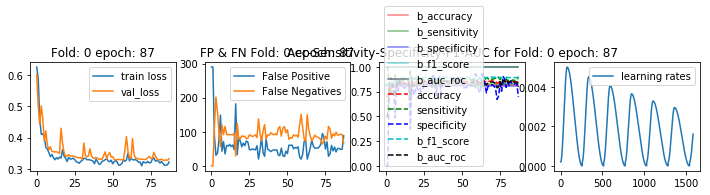

Epoch 88 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 88 completed.
Validation metrics
_________________________________________ METRICS for epoch 88 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89583   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88141   bmark:(0.8277)  sen.beaten:True
specificity      :0.79655   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83898   bmark:(1.0000)  spe.beaten:False
precision        :0.9107413010590015 
recall           :0.8814055636896047
---------------------
| tp:602  | fp:59   |
| fn:81   | tn:231  |
---------------------


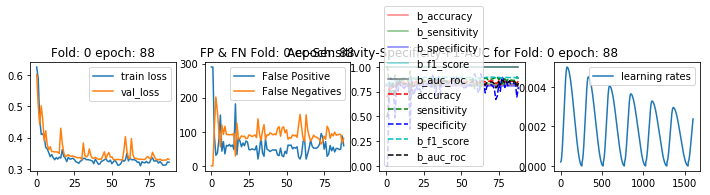

Epoch 89 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 89 completed.
Validation metrics
_________________________________________ METRICS for epoch 89 _______________________________________________________
accuracy         :0.85098   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89299   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88580   bmark:(0.8277)  sen.beaten:True
specificity      :0.76897   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.82738   bmark:(1.0000)  spe.beaten:False
precision        :0.9002976190476191 
recall           :0.8857979502196194
---------------------
| tp:605  | fp:67   |
| fn:78   | tn:223  |
---------------------


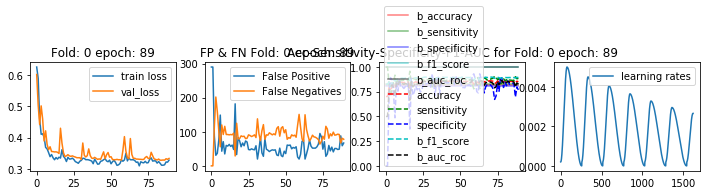

Epoch 90 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 90 completed.
Validation metrics
_________________________________________ METRICS for epoch 90 _______________________________________________________
accuracy         :0.85200   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88715   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.82870   bmark:(0.8277)  sen.beaten:True
specificity      :0.90690   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86780   bmark:(1.0000)  spe.beaten:False
precision        :0.954468802698145 
recall           :0.828696925329429
---------------------
| tp:566  | fp:27   |
| fn:117  | tn:263  |
---------------------


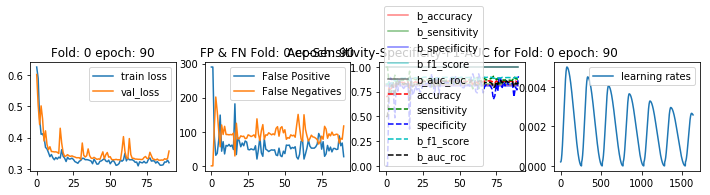

Epoch 91 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 91 completed.
Validation metrics
_________________________________________ METRICS for epoch 91 _______________________________________________________
accuracy         :0.84892   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.88434   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.82284   bmark:(0.8277)  sen.beaten:False
specificity      :0.91034   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.86659   bmark:(1.0000)  spe.beaten:False
precision        :0.95578231292517 
recall           :0.8228404099560761
---------------------
| tp:562  | fp:26   |
| fn:121  | tn:264  |
---------------------


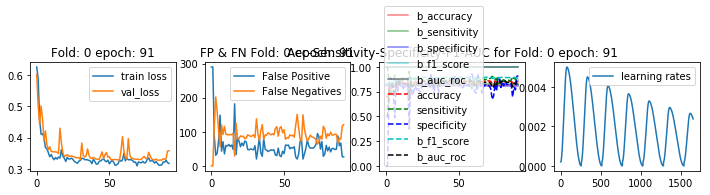

Epoch 92 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 92 completed.
Validation metrics
_________________________________________ METRICS for epoch 92 _______________________________________________________
accuracy         :0.85406   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89497   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.88580   bmark:(0.8277)  sen.beaten:True
specificity      :0.77931   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.83255   bmark:(1.0000)  spe.beaten:False
precision        :0.9043348281016442 
recall           :0.8857979502196194
---------------------
| tp:605  | fp:64   |
| fn:78   | tn:226  |
---------------------


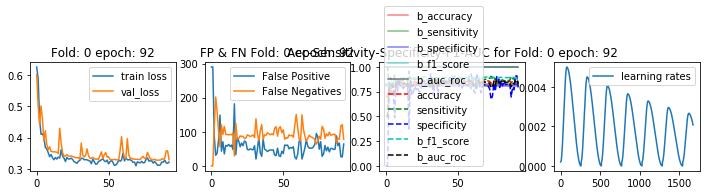

Epoch 93 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 93 completed.
Validation metrics
_________________________________________ METRICS for epoch 93 _______________________________________________________
accuracy         :0.85920   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89676   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87116   bmark:(0.8277)  sen.beaten:True
specificity      :0.83103   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85110   bmark:(1.0000)  spe.beaten:False
precision        :0.9239130434782609 
recall           :0.8711566617862372
---------------------
| tp:595  | fp:49   |
| fn:88   | tn:241  |
---------------------


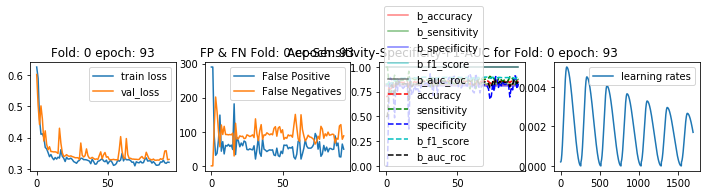

Epoch 94 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 94 completed.
Validation metrics
_________________________________________ METRICS for epoch 94 _______________________________________________________
accuracy         :0.84584   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89067   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.89458   bmark:(0.8277)  sen.beaten:True
specificity      :0.73103   bmark:(0.8060)  spe.beaten:False
auc_roc          :0.81281   bmark:(1.0000)  spe.beaten:False
precision        :0.8867924528301887 
recall           :0.8945827232796486
---------------------
| tp:611  | fp:78   |
| fn:72   | tn:212  |
---------------------


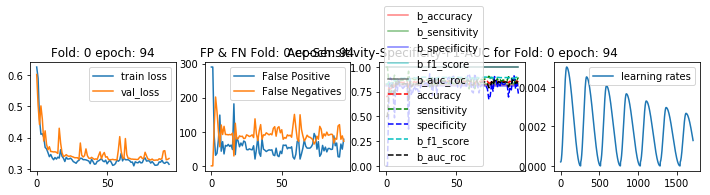

Epoch 95 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 95 completed.
Validation metrics
_________________________________________ METRICS for epoch 95 _______________________________________________________
accuracy         :0.85920   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89566   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86091   bmark:(0.8277)  sen.beaten:True
specificity      :0.85517   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85804   bmark:(1.0000)  spe.beaten:False
precision        :0.9333333333333333 
recall           :0.8609077598828697
---------------------
| tp:588  | fp:42   |
| fn:95   | tn:248  |
---------------------


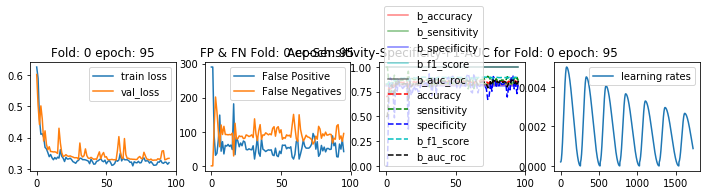

Epoch 96 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 96 completed.
Validation metrics
_________________________________________ METRICS for epoch 96 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89514   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86237   bmark:(0.8277)  sen.beaten:True
specificity      :0.84828   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85532   bmark:(1.0000)  spe.beaten:False
precision        :0.9304897314375987 
recall           :0.862371888726208
---------------------
| tp:589  | fp:44   |
| fn:94   | tn:246  |
---------------------


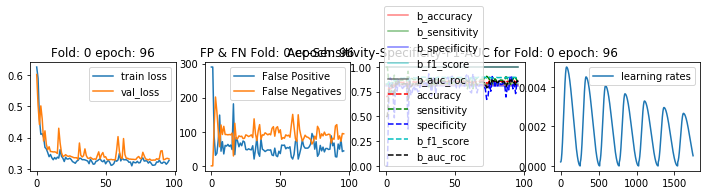

Epoch 97 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 97 completed.
Validation metrics
_________________________________________ METRICS for epoch 97 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89521   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.87555   bmark:(0.8277)  sen.beaten:True
specificity      :0.81034   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.84295   bmark:(1.0000)  spe.beaten:False
precision        :0.9157733537519143 
recall           :0.8755490483162518
---------------------
| tp:598  | fp:55   |
| fn:85   | tn:235  |
---------------------


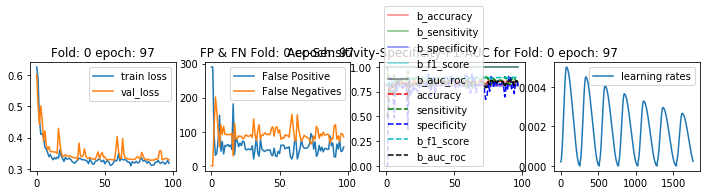

Epoch 98 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 98 completed.
Validation metrics
_________________________________________ METRICS for epoch 98 _______________________________________________________
accuracy         :0.85817   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89577   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86823   bmark:(0.8277)  sen.beaten:True
specificity      :0.83448   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85136   bmark:(1.0000)  spe.beaten:False
precision        :0.9251170046801872 
recall           :0.8682284040995608
---------------------
| tp:593  | fp:48   |
| fn:90   | tn:242  |
---------------------


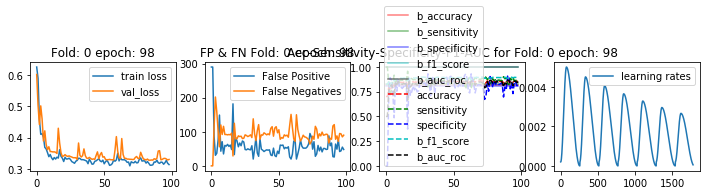

Epoch 99 started.
Training dataset size(s): 8746
Validation dataset size(s): 973



Epoch 99 completed.
Validation metrics
_________________________________________ METRICS for epoch 99 _______________________________________________________
accuracy         :0.85612   bmark:(0.8169)  accuracy beaten:True
f1_score         :0.89378   bmark:(1.0000)  f1 beaten:False
sensitivity      :0.86237   bmark:(0.8277)  sen.beaten:True
specificity      :0.84138   bmark:(0.8060)  spe.beaten:True
auc_roc          :0.85188   bmark:(1.0000)  spe.beaten:False
precision        :0.9275590551181102 
recall           :0.862371888726208
---------------------
| tp:589  | fp:46   |
| fn:94   | tn:244  |
---------------------


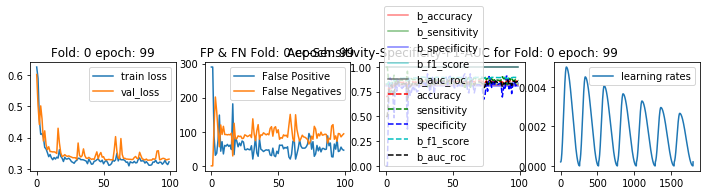

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
{'accuracy': 0.8561151079136691, 'specificity': 0.8413793103448276, 'sensitivity': 0.862371888726208, 'f1_score': 0.8937784522003034, 'auc_roc': 0.8518755995355178, 'recall': 0.8623718887262

In [39]:
init_learning_rate = 0.01    
    
## packing variable-length data in pytorch using packing and padding:
## https://github.com/HarshTrivedi/packing-unpacking-pytorch-minimal-tutorial

## https://gist.github.com/MikulasZelinka/9fce4ed47ae74fca454e88a39f8d911a

metrics_ht = Metrics(benchmark_acc = 0.8169, benchmark_f1 = 1.0, benchmark_spec = 0.8060, benchmark_sen = 0.8277, benchmark_auc = 1.0)

all_folds_last_results = []

for k in range(xval_fold_count):  # k-fold x-validation
    
    print("Fold",k)

    metrics_ht.reset_history()

    train_datasets = []
    val_datasets = []
    
    bucket_sampling_idxs = np.random.permutation(list(range(len(X_buckets))))
    
    training_seq_label_buckets = []
    val_seq_label_buckets = []
    training_num_features_buckets = []
    val_num_features_buckets = []
    
    # iterate through the buckets to create datasets and dataloaders
    for bucket_idx in bucket_sampling_idxs:

        train_idx = bucket_train_test_idxs[bucket_idx][k][0]
        val_idx = bucket_train_test_idxs[bucket_idx][k][1]
        idxs_in_bucket = np.array(idxs_buckets[bucket_idx])

        bucket_input_features = X_buckets[bucket_idx]
        bucket_labels = Y_buckets[bucket_idx]

        
        train_labels = bucket_labels[train_idx]
        val_labels = bucket_labels[val_idx]
        
        #train_data_idxs = idxs_in_bucket[train_idx]        
        #val_data_idxs = idxs_in_bucket[val_idx]
        
        if(use_features):
            train_features = (bucket_input_features[0][train_idx,:], bucket_input_features[1][train_idx,:])
            val_features = (bucket_input_features[0][val_idx], bucket_input_features[1][val_idx,:])

            training_seq_label_buckets.append( (train_features[0], train_labels) )
            val_seq_label_buckets.append( (val_features[0], val_labels) )
            
            training_num_features_buckets.append(train_features[1])
            val_num_features_buckets.append(val_features[1])
            #train_datasets.append(data_utils.TensorDataset(torch.from_numpy(train_features[0]), torch.from_numpy(train_features[1]).float(), torch.from_numpy(train_labels)))
            #val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_features[0]), torch.from_numpy(val_features[1]).float(), torch.from_numpy(val_labels)))
        else:
            train_features = bucket_input_features[train_idx,:]
            val_features = bucket_input_features[val_idx,:]

            train_datasets.append(data_utils.TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels)))
            val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels)))
            
    # normalize numerical features combining data across buckets        
    if(use_features):        
        training_num_features = np.concatenate(training_num_features_buckets, axis = 0)
        mu = np.mean(training_num_features, axis = 0)
        sd = np.std(training_num_features, axis = 0)
        training_num_features_buckets = [ (training_num_features_bucket-mu)/sd for training_num_features_bucket in training_num_features_buckets]
                
        #training_num_features = (training_num_features - mu)/sd
        #val_num_features = np.concatenate(val_num_features_buckets, axis = 0)
        #val_num_features = (val_num_features - mu)/sd
        
        val_num_features_buckets = [ (val_num_features_bucket-mu)/sd for val_num_features_bucket in val_num_features_buckets]
        
        
        for bucket_idx in bucket_sampling_idxs:
            #print(training_seq_label_buckets[bucket_idx][0].shape)
            #print(training_num_features[bucket_idx].shape)
            #print(training_seq_label_buckets[bucket_idx][1].shape)

            train_datasets.append(data_utils.TensorDataset(torch.from_numpy(training_seq_label_buckets[bucket_idx][0]), 
                                                           torch.from_numpy(training_num_features_buckets[bucket_idx]).float(), 
                                                           torch.from_numpy(training_seq_label_buckets[bucket_idx][1])))
            
            val_datasets.append(data_utils.TensorDataset(torch.from_numpy(val_seq_label_buckets[bucket_idx][0]), 
                                                         torch.from_numpy(val_num_features_buckets[bucket_idx]).float(), 
                                                         torch.from_numpy(val_seq_label_buckets[bucket_idx][1])))


        
    train_dataloaders = [data_utils.DataLoader(train_dataset, batch_size = batch_sz, shuffle = True) for train_dataset in train_datasets]
    val_dataloaders = [data_utils.DataLoader(val_dataset, batch_size = batch_sz, shuffle = False) for val_dataset in val_datasets]

    num_iter_per_epoch = np.sum([len(loader) for loader in train_dataloaders])
    
    
    training_losses = []
    val_losses = []

    # initialize the model
    #model = RNA_Net(num_DNAs, 16).cuda()
    #model = CNPPNet(num_DNAs, 16).cuda()
    if(use_features):   
        model = CNPPNet_Hybrid(num_DNAs, 16).cuda()
    else:
        model = CNNNet(num_DNAs, 16).cuda()
        
    
    print(model)
    
    # loss function, optimization algorithm, and final layer activation function
    loss_function = torch.nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).cuda() )
    activationFunc = torch.nn.LogSoftmax(dim = -1)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3,  weight_decay=0.01)
    scheduler = OneCycleCosineAnnealing(optimizer, num_iter_per_epoch*num_epochs/7, 1, max_lr = 5e-3, decay_rate =.9)
    print(num_iter_per_epoch)
    
    model = model.train()
        
    # train the network 
    for epoch in range(num_epochs):
        print("Epoch",epoch,"started.")
        
        train_dataset_sizes = [len(train_dataloader.dataset) for train_dataloader in train_dataloaders]
        val_dataset_sizes = [len(val_dataloader.dataset) for val_dataloader in val_dataloaders]
        
        print("Training dataset size(s):",*train_dataset_sizes)
        print("Validation dataset size(s):",*val_dataset_sizes)
        
        training_loss = []
        train_ys = []
        train_preds = []
            
        # train the network                
        for train_dataloader in tqdm_notebook(train_dataloaders):
            
            for x, y in train_dataloader:
            #for x, z, y in train_dataloader:
                model.zero_grad()
                optimizer.zero_grad()
                
                x = x.cuda()
                #z = z.cuda()
                
                y = y.cuda()
                x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)
                
                torch.all(x !=0)
                # compute the length of each sequence in the batch (to be used for packing)
                # pad the sequences in the batch
                 
                #logits = model(x, seq_lengths = x_lens)
                
                logits = model(x)
                #logits = model(x, z)
                preds = torch.argmax(activationFunc(logits), dim = -1)
                
                loss = loss_function(logits, y)
                training_loss.append(loss.item())
                
                train_ys.append(y.cpu().numpy())
                train_preds.append(preds.cpu().numpy())
                    
                loss.backward()
                scheduler.step()
                optimizer.step()
                
        training_losses.append(np.mean(training_loss))        
        train_ys = np.concatenate(train_ys) 
        train_preds = np.concatenate(train_preds)
        
        print("Epoch",epoch,"completed.")
        
        #print('________________________________________')
        #print('Training metrics')
        #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = False)
        #print('training_accuracy:',results['accuracy'])
        #print('________________________________________')

        model = model.eval()
        # compute validation loss, and accuracy metrics        
        with torch.no_grad():
            val_ys = []

            val_pred_probs = []            
            val_preds = []
            
            val_loss = []
            
            for val_dataloader in val_dataloaders:
                for x, y in val_dataloader:
                #for x, z, y in val_dataloader:
                    x = x.cuda()
                    #z = z.cuda()
                    y = y.cuda()
                    x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                    #logits = model(x, seq_lengths = x_lens.cpu())                
                    
                    logits = model(x)                
                    #logits = model(x, z)                
                    log_pred_probs = activationFunc(logits)
                    preds = torch.argmax(log_pred_probs, dim = -1)
                    
                    loss = loss_function(logits, y)
                    val_loss.append(loss.item())
                    
                    val_ys.append(y.cpu().numpy())
                    val_preds.append(preds.cpu().numpy())
                    val_pred_probs.append(np.exp(log_pred_probs.cpu().numpy()))
            val_losses.append(np.mean(val_loss))
        
        
        val_ys = np.concatenate(val_ys) 
        val_preds = np.concatenate(val_preds)
        val_pred_probs = np.concatenate(val_pred_probs)
        
        #val_accuracy = (val_ys==val_preds).sum()/len(val_preds) 
        #print("--- validation accuracy:", val_accuracy)   
        print('============================================================================================================')
        print('Validation metrics')
        val_results = metrics_ht.compute_metrics(val_ys, val_preds, epoch, do_print = True, store_vals = True)
        print('============================================================================================================')
        #print('Training metrics')
        #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = True, store_vals = False)
        #print('============================================================================================================')
        
        line_colors = plt.cm.tab20(np.linspace(0,1,20))
        
        tr_loss_color = line_colors[0]
        val_loss_color = line_colors[2]
        
#         plt.cla()
#         plt.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
#         plt.legend()
#         plt.show();
        
        x_data = range(epoch+1)
        
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,2))
        ax1.plot(x_data, training_losses, label="train loss", color = tr_loss_color, alpha=1.0)
        ax1.plot(x_data, val_losses, label="val_loss", color = val_loss_color, alpha=1.0)
        ax1.legend()
        ax1.set_title("Fold: "+str(k)+" epoch: "+str(epoch))
        
        #ax = fig.subplot(122), alpha=.7
        tmp = np.array(metrics_ht.tp_tn_fp_fn)
        ax2.plot(x_data, tmp[:,2], label="False Positive", color = tr_loss_color, alpha=1.0)
        ax2.plot(x_data, tmp[:,3], label="False Negatives", color = val_loss_color, alpha=1.0)
        ax2.legend()
        ax2.set_title("FP & FN Fold: "+str(k)+" epoch: "+str(epoch))
        
        
        ax3.plot(x_data, [metrics_ht.b_accuracy]*len(x_data), label="b_accuracy", color = 'r', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_sensitivity]*len(x_data), label="b_sensitivity", color = 'g', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_specificity]*len(x_data), label="b_specificity", color = 'b', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_f1]*len(x_data), label="b_f1_score", color = 'c', alpha=.5)
        ax3.plot(x_data, [metrics_ht.b_auc_roc]*len(x_data), label="b_auc_roc", color = 'k', alpha=.5)
        
        ax3.plot(x_data, metrics_ht.accuracies, '--', label="accuracy", color = 'r')
        ax3.plot(x_data, metrics_ht.sensitivity, '--',  label="sensitivity", color = 'g')
        ax3.plot(x_data, metrics_ht.specificity, '--',  label="specificity", color = 'b')
        ax3.plot(x_data, metrics_ht.f1s,  '--', label="b_f1_score", color = 'c')
        ax3.plot(x_data, metrics_ht.auc_roc,  '--', label="b_auc_roc", color = 'k')
                
        ax3.legend(loc='lower left')
        ax3.set_title("Acc-Sensitivity-Specificity-F1-AUC for Fold: "+str(k)+" epoch: "+str(epoch))
        
        ax4.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
        ax4.legend()
                
        plt.show()
        plt.close()
        
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')
    all_folds_last_results.append(val_results)

for result in all_folds_last_results:
    print(result)

# Show results and save model

In [70]:
now = datetime.now()
savefile_name = now.strftime("%H_%M_%S")+"_"+now.strftime("%m") + now.strftime("%d") + now.strftime("%Y")
# torch.save(model.state_dict(), f'./trained_model_{savefile_name}.pkl')    

# use to load and start inference:
# model.load_state_dict(torch.load(filepath))
# model.eval()

print("Test results")
for result in all_folds_last_results:
    print("accuracy:",result['accuracy'])
    print("sensitivity:",result['sensitivity'])
    print("specificity:",result['specificity'])

Test results
accuracy: 0.8561151079136691
sensitivity: 0.862371888726208
specificity: 0.8413793103448276


# Helper functions for Saliency

In [ ]:
def get_kmers(alphabet, k):
    kmers_list = []
    kmers_list.append(alphabet)
    
    for k_idx in range(k-1):
        kmers_list.append([a+b for a in kmers_list[k_idx] for b in alphabet ])

    seq_lst = list(seq)
    subs = ["".join(seq_lst[idx:idx+k]) for idx in range(len(seq)-k+1)]
    kmers = kmers_list[k-1]

    return kmers

def sequence2encodings(alphabet, sequence_lst):

    label_encodings = np.array([alphabet.index(c)+1  for seq in sequence_lst for c in seq ]).reshape(len(sequence_lst),-1)

    onehot_encodings=[(np.arange(len(alphabet)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

    onehot_encodings = np.array([np.delete(onehot,0, axis=-1) for onehot in onehot_encodings]).reshape(len(onehot_encodings),-1, len(alphabet))
        
    return label_encodings, onehot_encodings

def onehots2sequences(alphabet, onehot_encodings):

    for onehot_encoding in onehot_encodings: 
        assert onehot_encoding.shape[-1] ==len(alphabet), "One hot sequence must be batch_sz x seq_length x alphabet_sz"
    
    DNA_sequences = ["".join(seq_lst) for seq_lst in [[alphabet[i] for i in np.argmax(one_hot, axis = 1)] for one_hot in onehot_encodings ]]

    label_encodings = np.array([alphabet.index(c)+1  for seq in DNA_sequences for c in seq ]).reshape(len(DNA_sequences),-1)

    return DNA_sequences, label_encodings


def mutate_seq_for_saliencymap(sequence_to_mutate, window_sz, mutation_probs, mutation_rate_pct, stride = None, start_idx = 0, alphabet = None, include_identicals = False ):
    
    if stride is None or stride <= 0:
        stride = window_sz
        
    if alphabet is None:
        alphabet = list(sorted(list(set(list(sequence_to_mutate)))))
    
    seq_len = len(sequence_to_mutate)
    region_start_idxs = np.array(list(range(start_idx, seq_len, stride)))
    region_end_idxs = region_start_idxs + window_sz 
    #print(region_start_idxs, region_end_idxs, region_end_idxs>(seq_len))
    
    region_end_idxs[region_end_idxs>(seq_len)]=seq_len
    #print(region_start_idxs, region_end_idxs, )
    
    mutation_segments = [sequence_to_mutate[start:start+window_sz] for start in region_start_idxs]

    mutation_counts = [int(len(mutation_segment)*mutation_rate_pct) for mutation_segment in mutation_segments]
    #mutation_locations = [np.random.randint(0,len(mutation_segment), size=(1, mutation_count)) for mutation_segment,mutation_count in zip(mutation_segments, mutation_counts)]
    mutation_locations_segments = [[np.random.randint(0,len(mutation_segment), size=(1, mutation_count))] for mutation_segment, mutation_count in zip(mutation_segments, mutation_counts)]
    
    #print(alphabet, list(mutation_probs.values()))
    replacements_segments = [np.random.choice(alphabet, size = (mutation_count, ), p = list(mutation_probs.values())) for mutation_count in mutation_counts ]
    #print("mutation_locations_segments:", mutation_locations_segments)
    #print("replacements_segments:", replacements_segments)
    #print()
    mutated_segments = []
    for mutation_segment, mutation_locations_segment, replacements_segment in zip(mutation_segments, mutation_locations_segments, replacements_segments):
        #print("mutation_locations_segment",mutation_locations_segment)
        #print("replacements_segment",replacements_segment)
        mutation_locations_segment = np.array(mutation_locations_segment).reshape(1,)
        
        mutated_segment = list(mutation_segment[:]) 
        #print(mutated_segment)
        #
        for i_mloc, mloc in enumerate(np.array(mutation_locations_segment)):
            mutated_segment[mloc]=replacements_segment[i_mloc] 
        #    print("    ", mloc, replacements_segment[i_mloc] )
        #print(mutated_segment)
        mutated_segments.append("".join(mutated_segment))
        #print()
    
    mutated_sequence = sequence_to_mutate[:] # copy the sequence since strings are immutable
    
    for mutated_segment, start, end in zip(mutated_segments, region_start_idxs, region_end_idxs):
        #print(start,sequence_to_mutate, mutated_sequence[:start+1], mutated_segment, mutated_sequence[end:])
        mutated_sequence = mutated_sequence[:start] + mutated_segment + mutated_sequence[end:]
        #print(sequence_to_mutate)
        #print(mutated_sequence)
        #print()
    
    if not include_identicals:
        mutated_idxs = [i for i in range(len(sequence_to_mutate)) if sequence_to_mutate[i]!=mutated_sequence[i] ]
    else:
        mutated_idxs = list(range(len(sequence_to_mutate)))
        
    all_one_pos_change_sequences = []
    for i in mutated_idxs:
        all_one_pos_change_sequences.append("".join(list(sequence_to_mutate[:i])+list(mutated_sequence[i])+list(sequence_to_mutate[i+1:])))
    
    #return mutation_segments, mutated_segments, sequence_to_mutate, mutated_sequence, all_one_pos_change_sequences
    return sequence_to_mutate, mutated_sequence, all_one_pos_change_sequences
    
    
    
alphabet = unique_DNAs
kmers = get_kmers(alphabet, 2)

mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
                  'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
                  'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
                  'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
                  'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
                 }


# # # labelencodings, one_hots = sequence2encodings(alphabet, kmers)
# # # DNA_seqs, labelencodings_2 = onehots2sequences(alphabet, one_hots)

# # # DNA_seqs, kmers, labelencodings, labelencodings_2, one_hots
# # # "".join(list(map(chr,list(range(65,65+26)))))
# # #"".join(DNA_seqs)
# # #print(mut_segs),"".join(DNA_seqs), mutation_segments, mutated_segments
# # # print(mutation_segments)
# # # print(mutated_segments)
# # # print()

# test_seq = "AGCTATG"

# all_one_place_changes_for_all_DNA = []
# for DNA in unique_DNAs:
#     orig_seq, mut_seq, all_changed = mutate_seq_for_saliencymap(test_seq, 
#                                                                 window_sz = 1, 
#                                                                 mutation_probs = mutation_probs[DNA], 
#                                                                 mutation_rate_pct = 1., 
#                                                                 stride = 1, 
#                                                                 alphabet = unique_DNAs, 
#                                                                 include_identicals = True)
#     all_one_place_changes_for_all_DNA.extend(all_changed)
# len(all_one_place_changes_for_all_DNA), print(all_one_place_changes_for_all_DNA)


# # #[print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]    
# # #print(len(all_one_place_changes_for_all_DNA))
# # all_one_place_changes_for_all_DNA = list(sorted(list(set(all_one_place_changes_for_all_DNA))))    
# # #print(len(all_one_place_changes_for_all_DNA))
# # [print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]
# # print(orig_seq)
# # print(mut_seq)
# # print()
# # _, ohe = sequence2encodings(alphabet, mut_seq)
# # [print(c_seq) for c_seq in all_one_place_changes_for_all_DNA]


# # #print(ohe)

In [42]:
# # # np.arange(one_hot[0].shape[1])[np.where(one_hot[0])]
# # one_hots.shape

# a = np.array([np.random.choice([1,2,3], p = [.8, .2, .0]) for _ in range(50)])
# a[a==1].shape[0], a[a==2].shape[0], a[a==1].shape[0]/a.shape[0], a[a==2].shape[0]/a.shape[0]

# np.random.randint(0,1,size=(1,10))

# a = [1,2,3,4]
# b = [5,6,7,8]

# c = ['A','B','C','D']

# for i,j,k in zip(a,b,c):
#     print(i,j,k)

# Compute Saliency

In [43]:
# take the first bucket for now

bucket_idx = 0

X_onehots = val_datasets[bucket_idx][:][0]
Ys = val_datasets[bucket_idx][:][1]

X_seqs, X_label_encodings = onehots2sequences(unique_DNAs, X_onehots)
# print(len(X_seqs))

# verifying generated sequences and onehot conversion algorithm's correctness
# X_label_encodings, X_onehot_from_seq = sequence2encodings(unique_DNAs, X_seqs)
# torch.all(np.equal(X_onehot_from_seq[0], X_onehots[0])).item()

In [44]:
alphabet = unique_DNAs

# kmers = get_kmers(alphabet, 2)

mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
                  'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
                  'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
                  'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
                  'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
                 }

saliency_maps = dict()

for sample_class_label_int in [0,1]:  # for both negative and positive classes
    
    correct_classification_idxs_for_class = np.where(np.array(val_preds == val_ys) & np.array(val_ys == sample_class_label_int))[0].squeeze()

    sort_idxs = np.argsort(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int])
    best_performing_examples = correct_classification_idxs_for_class[sort_idxs]  # one with highest probability performing is at -1

    print(correct_classification_idxs_for_class.shape)
    print(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int].shape)
    print(best_performing_examples.shape)
    
    
    saliency_maps_for_class = []
    
    then = time.time() 
    for i_sample_idx, sample_idx in enumerate(best_performing_examples):
        if i_sample_idx%(len(best_performing_examples)//20) == 0:
            print(f"{i_sample_idx}/{len(best_performing_examples)}")
        sequence_to_mutate_idx = sample_idx #best_performing_examples[sample_idx] # one with highest probability performing is at -1
        sequence_to_mutate = X_seqs[sequence_to_mutate_idx]
        label_of_sequence_to_mutate = Ys[sequence_to_mutate_idx]

        #orig_seq, mut_seq, all_one_step_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 3, mutation_probs = mutation_probs[1], mutation_rate_pct = 0.5, stride = 3)

        all_one_step_changed = []
        for DNA in unique_DNAs:
            orig_seq, mut_seq, all_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 1, mutation_probs = mutation_probs[DNA], mutation_rate_pct = 1., stride = 1, alphabet = unique_DNAs,
                                                                       include_identicals=True)
            all_one_step_changed.extend(all_changed)


        _, X_onehot_mutated = sequence2encodings(unique_DNAs, [sequence_to_mutate]+all_one_step_changed)
        X_onehot_mutated.shape

        saliencyy_Xs = torch.from_numpy(X_onehot_mutated)
        saliency_Ys = torch.from_numpy(np.zeros(shape=(X_onehot_mutated.shape[0],), dtype=np.long)+label_of_sequence_to_mutate.item())
        saliency_data_idx = torch.from_numpy(np.arange(X_onehot_mutated.shape[0]))

        saliency_dataset = data_utils.TensorDataset(saliencyy_Xs, saliency_Ys, saliency_data_idx)

        len(saliency_dataset), type(saliencyy_Xs), type(saliency_Ys), saliency_Ys.shape, saliencyy_Xs.dtype, saliency_Ys.dtype

        saliency_loader_batch_sz = 512

        saliency_dataloader = data_utils.DataLoader(saliency_dataset, batch_size = saliency_loader_batch_sz, shuffle = False)


        model = model.eval()
        # compute validation loss, and accuracy metrics        
        with torch.no_grad():

            saliency_ys = []
            saliency_preds = []
            saliency_pred_probs = []
            saliency_loss = []
            saliency_losses = []

            saliency_x_idxs = []
            for saliency_x, saliency_y, saliency_x_batch_idxs in saliency_dataloader:
            #for x, z, y in val_dataloader:
                saliency_x = saliency_x.cuda()
                #z = z.cuda()
                saliency_y = saliency_y.cuda()
                #x_lens = torch.sum(torch.any(x !=0, dim = -1), dim = -1)

                #logits = model(x, seq_lengths = x_lens.cpu())                

                saliency_logits = model(saliency_x)                
                #logits = model(x, z)                
                saliency_log_pred_probs_batch = activationFunc(saliency_logits)
                saliency_preds_batch = torch.argmax(saliency_log_pred_probs_batch, dim = -1)

                #print(saleincy_logits.shape, saleincy_y.shape )
                saliency_loss_batch = loss_function(saliency_logits, saliency_y)

                saliency_loss.append(saliency_loss_batch.item())
                saliency_ys.append(saliency_y.cpu().numpy())
                saliency_pred_probs.append(np.exp(saliency_log_pred_probs_batch.cpu().numpy()))
                saliency_preds.append(saliency_preds_batch.cpu().numpy())
                saliency_x_idxs.append(saliency_x_batch_idxs)

            saliency_losses.append(np.mean(saliency_loss))


        saliency_ys = np.concatenate(saliency_ys) 
        saliency_preds = np.concatenate(saliency_preds)
        saliency_pred_probs = np.concatenate(saliency_pred_probs)
        saliency_x_idxs = np.concatenate(saliency_x_idxs)

        #sample_class_label_int
        #saliency_pred_probs[:5,sample_class_label_int], saliency_preds[:5], np.unique(saliency_ys), label_of_sequence_to_mutate, val_pred_probs[best_performing_examples[-1],sample_class_label_int]
        score_diff = saliency_pred_probs[:, sample_class_label_int] - saliency_pred_probs[0, sample_class_label_int]

        saliency_map = score_diff[1:].reshape(1,-1).reshape(len(unique_DNAs), len(orig_seq))
        score_diff
        saliency_maps_for_class.append(saliency_map)

    now = time.time()
    print(f"Time taken for class{sample_class_label_int}:{now-then} seconds")
    # plot saliency matrix
    saliency_maps[sample_class_label_int] = saliency_maps_for_class
    
    

(244,)
(244,)
(244,)
0/244
12/244
24/244
36/244
48/244
60/244
72/244
84/244
96/244
108/244
120/244
132/244
144/244
156/244
168/244
180/244
192/244
204/244
216/244
228/244
240/244
Time taken for class0:85.52754044532776 seconds
(589,)
(589,)
(589,)
0/589
29/589
58/589
87/589
116/589
145/589
174/589
203/589
232/589
261/589
290/589
319/589
348/589
377/589
406/589
435/589
464/589
493/589
522/589
551/589
580/589
Time taken for class1:207.06136560440063 seconds


# Plot Saliency maps

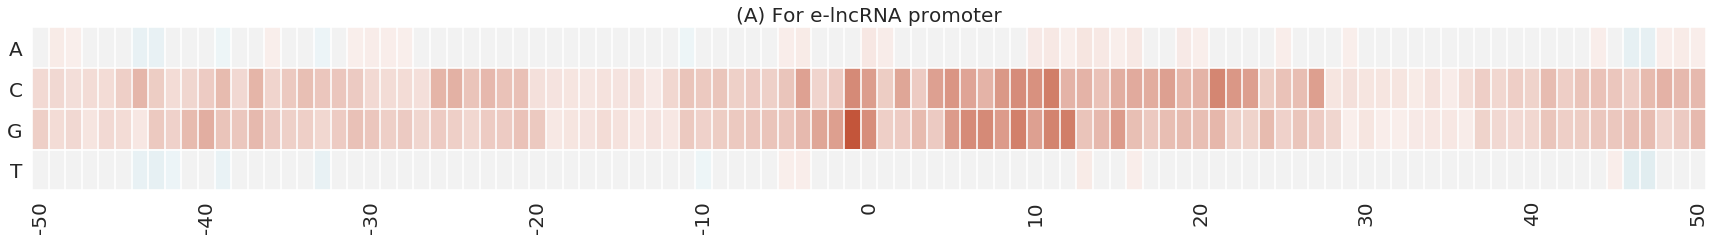

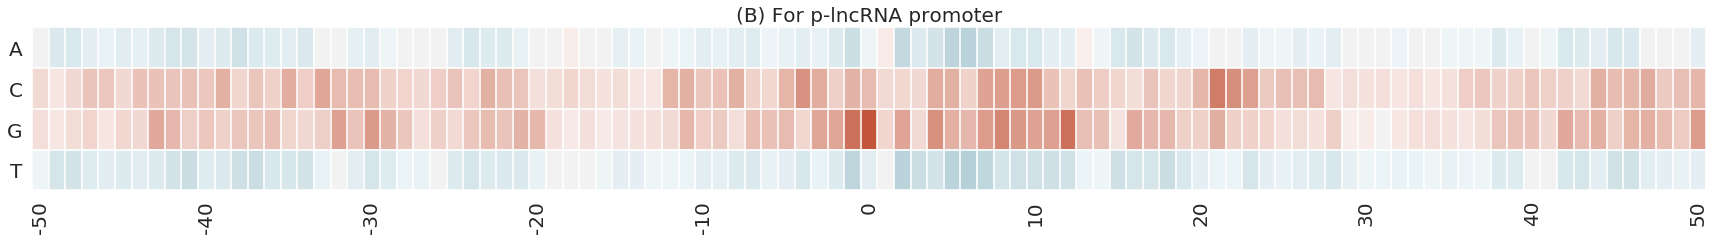

In [45]:
for sample_class_label_int in [0,1]:    
    score_multipliers = [-1.,1.]
    saliency_map = np.mean(np.array(saliency_maps[sample_class_label_int]), axis = 0) 
    saliency_map *= score_multipliers[sample_class_label_int]
    #print("saliency_map shape:", saliency_map.shape)
    #print(f'For class {class_names[sample_class_label_int]}')
    sns.set()
    #sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

    span_min = 350
    span_max = 450 + 1
    label_min = span_min - 400
    label_max = label_min + (span_max-span_min) + 1
    plt.figure(figsize=(30,3))
    # sns_cmap = sns.palplot(sns.diverging_palette(240, 10, n=9, as_cmap = True))
    ax= sns.heatmap(saliency_map[:,span_min:span_max], 
                cmap = sns.diverging_palette(220,20, n=250, as_cmap = True), 
                vmax = np.max(saliency_map[:,span_min:span_max]), 
                vmin = np.min(saliency_map[:,span_min:span_max]), 
                center = 0.0, 
                cbar=False)

    #ax.set_aspect("equal")

    plt.grid(True, color='r', linestyle='--', linewidth=2, which = 'both')
    loc = ticker.MultipleLocator(base=2)
    ax.xaxis.set_minor_locator(loc)
    ax.yaxis.set_minor_locator(loc)

    plt.xticks(np.arange(0,span_max-span_min,10)+0.5, np.arange(label_min,label_max,10), fontsize=20)
    plt.yticks(np.arange(0,saliency_map.shape[0])+0.5, unique_DNAs, fontsize=20)
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
    plt.yticks(rotation=0)
    plt.title("(" + chr(65+sample_class_label_int) + f") For {class_names[sample_class_label_int]} promoter", fontsize=20)
    # ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
    # ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())
    # ax.grid(b=True, which='major', color='w', linewidth=10.0)
    # ax.grid(b=True, which='minor', color='w', linewidth=15)
    gridlinewidth = 1.6
    ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='w', linewidth=gridlinewidth)
    ax.vlines(np.arange(0,span_max-span_min+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
    plt.show()


In [46]:
time.time()

1564945986.5382667

In [47]:
# plt.figure(figsize=(15,18))
# plt.imshow(saliency_map[:,350:450], cmap = 'Blues')
# plt.axis('off')

# Plot saliency map

In [48]:
np.arange(len(unique_DNAs)+1)+gridlinewidth/2

array([0.8, 1.8, 2.8, 3.8, 4.8])

In [49]:
# plt.imshow(saliency_map[:,:20], cmap = sns.diverging_palette(220,20, n=250, as_cmap = True))

In [50]:
# ax = sns.heatmap(saliency_map[:,:20], cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True))
# # plt.hist(saliency_map.reshape(1,-1), bins= np.linspace(np.min(saliency_map), np.max(saliency_map)))

In [51]:
# np.min(saliency_map)

In [52]:
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sbn

# x = np.linspace(0, 2 * np.pi, 100)
# y = np.sin(x)

# fig, ax = plt.subplots(1, 1)

# ax.scatter(x, y)
# ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
# ax.grid(b=True, which='major', color='w', linewidth=1.0)
# ax.grid(b=True, which='minor', color='w', linewidth=0.5)

In [53]:
# from matplotlib import pyplot as plt
# from matplotlib.ticker import MultipleLocator
# import numpy as np

# # Two example plots
# fig = plt.figure(figsize=(18,12))
# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)

# spacing = 0.5 # This can be your user specified spacing. 
# minorLocator = MultipleLocator(spacing)
# ax1.plot(9 * np.random.rand(10))
# # Set minor tick locations.
# ax1.yaxis.set_minor_locator(minorLocator)
# ax1.xaxis.set_minor_locator(minorLocator)
# # Set grid to use minor tick locations. 
# ax1.grid(which = 'minor')

# spacing = 1
# minorLocator = MultipleLocator(spacing)
# ax2.plot(9 * np.random.rand(10))
# # Set minor tick locations.
# ax2.yaxis.set_minor_locator(minorLocator)
# ax2.xaxis.set_minor_locator(minorLocator)
# # Set grid to use minor tick locations. 
# ax2.grid(which = 'minor')

# plt.show()

In [54]:
# #val_accuracy = (val_ys==val_preds).sum()/len(val_preds) 
# #print("--- validation accuracy:", val_accuracy)   
# print('============================================================================================================')
# print('Validation metrics')
# val_results = metrics_ht.compute_metrics(val_ys, val_preds, epoch, do_print = True, store_vals = True)
# print('============================================================================================================')
# #print('Training metrics')
# #results = metrics_ht.compute_metrics(train_ys, train_preds, epoch, do_print = True, store_vals = False)
# #print('============================================================================================================')

# line_colors = plt.cm.tab20(np.linspace(0,1,20))

# tr_loss_color = line_colors[0]
# val_loss_color = line_colors[2]

# #         plt.cla()
# #         plt.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
# #         plt.legend()
# #         plt.show();

# x_data = range(epoch+1)

# f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(12,2))
# ax1.plot(x_data, training_losses, label="train loss", color = tr_loss_color, alpha=1.0)
# ax1.plot(x_data, val_losses, label="val_loss", color = val_loss_color, alpha=1.0)
# ax1.legend()
# ax1.set_title("Fold: "+str(k)+" epoch: "+str(epoch))

# #ax = fig.subplot(122), alpha=.7
# tmp = np.array(metrics_ht.tp_tn_fp_fn)
# ax2.plot(x_data, tmp[:,2], label="False Positive", color = tr_loss_color, alpha=1.0)
# ax2.plot(x_data, tmp[:,3], label="False Negatives", color = val_loss_color, alpha=1.0)
# ax2.legend()
# ax2.set_title("FP & FN Fold: "+str(k)+" epoch: "+str(epoch))


# ax3.plot(x_data, [metrics_ht.b_accuracy]*len(x_data), label="b_accuracy", color = 'r', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_sensitivity]*len(x_data), label="b_sensitivity", color = 'g', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_specificity]*len(x_data), label="b_specificity", color = 'b', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_f1]*len(x_data), label="b_f1_score", color = 'c', alpha=.5)
# ax3.plot(x_data, [metrics_ht.b_auc_roc]*len(x_data), label="b_auc_roc", color = 'k', alpha=.5)

# ax3.plot(x_data, metrics_ht.accuracies, '--', label="accuracy", color = 'r')
# ax3.plot(x_data, metrics_ht.sensitivity, '--',  label="sensitivity", color = 'g')
# ax3.plot(x_data, metrics_ht.specificity, '--',  label="specificity", color = 'b')
# ax3.plot(x_data, metrics_ht.f1s,  '--', label="b_f1_score", color = 'c')
# ax3.plot(x_data, metrics_ht.auc_roc,  '--', label="b_auc_roc", color = 'k')

# ax3.legend(loc='lower left')
# ax3.set_title("Acc-Sensitivity-Specificity-F1-AUC for Fold: "+str(k)+" epoch: "+str(epoch))

# ax4.plot(range(len(scheduler.lrs)), scheduler.lrs, label="learning rates")
# ax4.legend()

# plt.show()
# plt.close()

# PWM generation step zero for PWM Exp 1 and PWM Exp 2

In [244]:
alphabet = unique_DNAs

# kmers = get_kmers(alphabet, 2)

mutation_probs = {'eq':{'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 }, 
                  'A': {'A': 1.,   'C': 0.,   'G': 0.,   'T': 0.,  },
                  'C': {'A': 0.,   'C': 1.,   'G': 0.,   'T': 0.,  },
                  'G': {'A': 0.,   'C': 0.,   'G': 1.,   'T': 0.,  },
                  'T': {'A': 0.,   'C': 0.,   'G': 0.,   'T': 1.,  },
                 }


subsequences = []

for sample_class_label_int in [0,1]:  # for both negative and positive classes
    
    correct_classification_idxs_for_class = np.where(np.array(val_preds == val_ys) & np.array(val_ys == sample_class_label_int))[0].squeeze()

    sort_idxs = np.argsort(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int])
    best_performing_examples = correct_classification_idxs_for_class[sort_idxs]  # one with highest probability performing is at -1

#     print(correct_classification_idxs_for_class.shape)
#     print(val_pred_probs[correct_classification_idxs_for_class, sample_class_label_int].shape)
#     print(best_performing_examples.shape)
    
    
    subsequences_for_class = []
    
    then = time.time() 
    for i_sample_idx, sample_idx in enumerate(best_performing_examples):
        sequence_idx = sample_idx #best_performing_examples[sample_idx] # one with highest probability performing is at -1
        sequence = X_seqs[sequence_idx]
        label_of_sequence_to_mutate = Ys[sequence_idx]

        seq_length = 7
        
        sub_seqs = [sequence[i:i+seq_length] for i in range(len(sequence)-(seq_length-1))] 
        #orig_seq, mut_seq, all_one_step_changed = mutate_seq_for_saliencymap( sequence_to_mutate, window_sz = 3, mutation_probs = mutation_probs[1], mutation_rate_pct = 0.5, stride = 3)
        #rint(len(sequence), len(sub_seqs), sub_seqs[0], sub_seqs[-1],sequence[:10],sequence[-10:])
        subsequences_for_class.append(sub_seqs)

    subsequences.append(subsequences_for_class)

print('Subsequence generation completed')


all_subsequences_class_0  = []
[all_subsequences_class_0.extend(subs) for subs in subsequences[0] ];
#all_unique_subsequences_class_0  = list(set(all_subsequences_class_0) )

all_subsequences_class_1  = []
[all_subsequences_class_1.extend(subs) for subs in subsequences[1] ];
#all_unique_subsequences_class_1  = list(set(all_subsequences_class_1) )

print('Subsequence merging completed')



Subsequence generation completed
Subsequence merging completed


# PWM Exp 1 : PWM for only unique subsequences appearing in a class, computing score, and taking the median as cut-off

In [245]:
len(all_unique_subsequences_class_0), len(all_subsequences_class_0), len(all_unique_subsequences_class_1), len(all_subsequences_class_1)

(14897, 144936, 16329, 349866)

In [264]:
from itertools import count
from collections import defaultdict

c_0 = itertools.count(0)
indexer_0 = lambda: next(c_0)
class_0_unique_subseq_indxs = []
class_0_unique_subseqs_dict = defaultdict(indexer_0)
class_0_unique_subseq_indxs = [class_0_unique_subseqs_dict[subseq] for subseq in all_subsequences_class_0]   


c_1 = itertools.count(0)
indexer_1 = lambda: next(c_1)
class_1_unique_subseq_indxs = []
class_1_unique_subseqs_dict = defaultdict(indexer_1)
class_1_unique_subseq_indxs = [class_1_unique_subseqs_dict[subseq] for subseq in all_subsequences_class_1]   

unique_subseqs_class_0 = list(class_0_unique_subseqs_dict.keys())
unique_subseqs_class_1 = list(class_1_unique_subseqs_dict.keys())

d_class_0 = dict(zip(unique_subseqs_class_0,range(len(unique_subseqs_class_0))))
d_class_1 = dict(zip(unique_subseqs_class_1,range(len(unique_subseqs_class_1))))

t0 = time.time()
#all_subsequences_only_in_class_0 = [subseq for subseq in all_subsequences_class_0 if subseq not in unique_subseqs_class_1]
all_subsequences_only_in_class_0 = [subseq for subseq in all_subsequences_class_0 if d_class_1.get(subseq) is None]
t1 = time.time()
all_subsequences_only_in_class_1 = [subseq for subseq in all_subsequences_class_1 if d_class_0.get(subseq) is None]
# all_subsequences_only_in_class_1 = [subseq for subseq in all_subsequences_class_1 if subseq not in unique_subseqs_class_0]
t2 = time.time()
common_subsequences = [subseq for subseq in all_subsequences_class_1 if not d_class_0.get(subseq) is None]
# common_subsequences = [subseq for subseq in all_subsequences_class_1 if subseq in unique_subseqs_class_0]
t3 = time.time()

print(f"{t1-t0:0.2f}")
print(f"{t2-t1:0.2f}")
print(f"{t3-t2:0.2f}")

0.01
0.03
0.04


In [265]:
len(all_subsequences_class_0), len(all_subsequences_class_1), len(unique_subseqs_class_0), len(unique_subseqs_class_1)

(144936, 349866, 14897, 16329)

In [266]:
len(all_subsequences_only_in_class_0), len(all_subsequences_only_in_class_1), len(common_subsequences)

(176, 28012, 321854)

In [267]:
len(list(set(all_subsequences_only_in_class_0))), len(list(set(all_subsequences_only_in_class_1))), len(list(set(common_subsequences)))

(43, 1475, 14854)

In [268]:
len(list(set(common_subsequences) | set(all_subsequences_only_in_class_0))),  len(list(set(common_subsequences))), len(list(set(all_subsequences_only_in_class_0)))

(14897, 14854, 43)

In [283]:
unique_subsequences_per_class__list = []
unique_subsequences_per_class__list.append(all_subsequences_only_in_class_0)
unique_subsequences_per_class__list.append(all_subsequences_only_in_class_1)


params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)


mean_activations_for_classes = []
PWMs_for_classes = []
layers_idxs_for_classes = []
filters_idxs_for_classes = []

for unique_subsequences in unique_subsequences_per_class__list:
    
    mean_activations = []
    PWMs = []
    layers_idxs = []
    filters_idxs = []

    for l in range(0,6,2): # first layer conv filters only
        param_layer = params[l]

        for i, filter_weights in enumerate(param_layer):

            if(filter_weights.shape[1] < 6):
                continue
            #print("Filter shape:",filter_weights.shape)
            filter_length = filter_weights.shape[1]
            filter_weights = filter_weights.data.permute(1,0)

            motif_sequences = unique_subsequences#get_kmers(unique_DNAs,filter_length)

            label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

            ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

            ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
            #print(ohs.shape)
            #print(filter_weights.shape)
            logits = (ohs*filter_weights.cpu())

            unique_subseq_activisions = torch.nn.functional.relu(torch.sum(torch.sum(logits,1),1)).detach().squeeze()
            #print(unique_subseq_activisions.shape)
            passed_sequences_idx = np.where(unique_subseq_activisions > max(unique_subseq_activisions)/2)[0]
            if(len(passed_sequences_idx) <=1):
                continue
            
            #print("activisions:",activisions[activisions > max(activisions)/2].shape)
            mean_activation = torch.mean(unique_subseq_activisions[unique_subseq_activisions > max(unique_subseq_activisions)/2].squeeze())
            mean_activations.append(mean_activation.item())

            
            passed_sequences_motif = [unique_subsequences[i] for i in passed_sequences_idx.squeeze() ] 
            passed_sequences_le = np.array([unique_DNAs.index(c)+1  for motif_seq in passed_sequences_motif for c in motif_seq ]).reshape(len(passed_sequences_motif),-1)
            
            #passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]
            #passed_sequences, print(passed_sequences_motif)

            arr = np.array(passed_sequences_le).squeeze().transpose(1,0)
            probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences_le) for i in np.unique(label_encodings) ]

            PWMs.append(np.array(probs).squeeze())

            layers_idxs.append(l//2)
            filters_idxs.append(i)

    mean_activations_for_classes.append(mean_activations)
    PWMs_for_classes.append(PWMs)
    layers_idxs_for_classes.append(layers_idxs)
    filters_idxs_for_classes.append(filters_idxs)



#unique_subseqs_class_1_dict = dict(zip(unique_subseqs_class_1, list(range(len(unique_subseqs_class_1))) ) )

# len(unique_subseqs_class_0), len(unique_subseqs_class_1)
# recons = [unique_subseqs_class_1[i] for i in class_1_unique_subseq_indxs]
# len(recons), len(all_subsequences_class_1)
# comps = [recons[i]==all_subsequences_class_1[i] for i in range(len(all_subsequences_class_1))]
# np.all(comps)

[torch.Size([32, 4, 7]), torch.Size([32]), torch.Size([64, 32, 5]), torch.Size([64]), torch.Size([128, 64, 3]), torch.Size([128]), torch.Size([64, 4608]), torch.Size([64]), torch.Size([16, 64]), torch.Size([16]), torch.Size([2, 16]), torch.Size([2])]
['A', 'C', 'G', 'T']


# PWM Exp 2: PWM for all subsequences appearing in a class (including duplicates), computing score for all, and taking the median as cut-off

In [161]:
all_subsequences_for_classes = []
all_subsequences_for_classes.append(all_subsequences_class_0)
all_subsequences_for_classes.append(all_subsequences_class_1)


unique_subsequences_for_classes = []
unique_subsequences_for_classes.append(unique_subseqs_class_0)
unique_subsequences_for_classes.append(unique_subseqs_class_1)

unique_subsequences_idxs_for_classes = []
unique_subsequences_idxs_for_classes.append(class_0_unique_subseq_indxs)
unique_subsequences_idxs_for_classes.append(class_1_unique_subseq_indxs)


params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)


mean_activations_for_classes = []
PWMs_for_classes = []
layers_idxs_for_classes = []
filters_idxs_for_classes = []

for unique_subsequences, unique_subsequences_idx, all_subsequences in zip(unique_subsequences_for_classes,unique_subsequences_idxs_for_classes, all_subsequences_for_classes):
    
    mean_activations = []
    PWMs = []
    layers_idxs = []
    filters_idxs = []

    unique_subsequences_idx = np.array(unique_subsequences_idx)
    for l in range(0,6,2): # first layer conv filters only
        param_layer = params[l]

        for i, filter_weights in enumerate(param_layer):

            if(filter_weights.shape[1] < 6):
                continue
            #print("Filter shape:",filter_weights.shape)
            filter_length = filter_weights.shape[1]
            filter_weights = filter_weights.data.permute(1,0)

            motif_sequences = unique_subsequences#get_kmers(unique_DNAs,filter_length)

            label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

            ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

            ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
            #print(ohs.shape)
            #print(filter_weights.shape)
            logits = (ohs*filter_weights.cpu())

            unique_subseq_activisions = torch.nn.functional.relu(torch.sum(torch.sum(logits,1),1))
            
            all_subseq_activations = np.array([unique_subseq_activisions[i].detach() for i in unique_subsequences_idx])
            
            passed_sequences_idx = np.where(all_subseq_activations > max(all_subseq_activations)/2)[0].squeeze()
            if(len(passed_sequences_idx) <=1):
                continue
            
            #print("activisions:",activisions[activisions > max(activisions)/2].shape)
            mean_activation = np.mean(all_subseq_activations[all_subseq_activations > max(all_subseq_activations)/2].squeeze())
            mean_activations.append(mean_activation.item())

            
            passed_sequences_motif = [all_subsequences[i] for i in passed_sequences_idx.squeeze() ] 
            passed_sequences_le = np.array([unique_DNAs.index(c)+1  for motif_seq in passed_sequences_motif for c in motif_seq ]).reshape(len(passed_sequences_motif),-1)
            
            
            [label_encodings[i,:] for i in unique_subsequences_idx[passed_sequences_idx.squeeze() ] ]
            #passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]
            #passed_sequences, print(passed_sequences_motif)

            arr = np.array(passed_sequences_le).squeeze().transpose(1,0)
            probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences_le) for i in np.unique(label_encodings) ]

            PWMs.append(np.array(probs).squeeze())

            layers_idxs.append(l//2)
            filters_idxs.append(i)

    mean_activations_for_classes.append(mean_activations)
    PWMs_for_classes.append(PWMs)
    layers_idxs_for_classes.append(layers_idxs)
    filters_idxs_for_classes.append(filters_idxs)


  

[torch.Size([32, 4, 7]), torch.Size([32]), torch.Size([64, 32, 5]), torch.Size([64]), torch.Size([128, 64, 3]), torch.Size([128]), torch.Size([64, 4608]), torch.Size([64]), torch.Size([16, 64]), torch.Size([16]), torch.Size([2, 16]), torch.Size([2])]
['A', 'C', 'G', 'T']


# PWM visualization for PWM Exp 1 and Exp 2

Mean activation:1.49e-16
Layer 0, filter#10

array([[0.065, 0.613, 0.774, 0.   , 0.194, 0.968, 0.032],
       [0.097, 0.129, 0.097, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.258, 0.129, 0.548, 0.   , 0.   , 0.258],
       [0.839, 0.   , 0.   , 0.452, 0.806, 0.032, 0.71 ]])



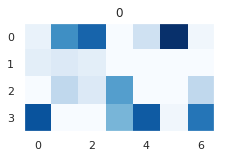

----------------------------------------------------------------------
Mean activation:2.07e-05
Layer 0, filter#0

array([[0.421, 0.   , 0.553, 0.079, 0.632, 0.211, 0.   ],
       [0.026, 0.447, 0.   , 0.   , 0.026, 0.184, 0.   ],
       [0.289, 0.184, 0.053, 0.026, 0.   , 0.026, 1.   ],
       [0.263, 0.368, 0.395, 0.895, 0.342, 0.579, 0.   ]])



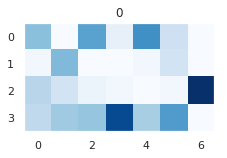

----------------------------------------------------------------------
Mean activation:0.000205
Layer 0, filter#26

array([[0.229, 0.571, 0.6  , 0.   , 0.171, 0.629, 0.343],
       [0.143, 0.029, 0.086, 0.   , 0.   , 0.029, 0.143],
       [0.   , 0.171, 0.   , 1.   , 0.114, 0.   , 0.029],
       [0.629, 0.229, 0.314, 0.   , 0.714, 0.343, 0.486]])



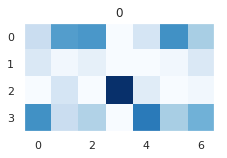

----------------------------------------------------------------------
Mean activation:0.00229
Layer 0, filter#9

array([[0.108, 0.554, 0.392, 0.459, 0.068, 0.811, 0.122],
       [0.014, 0.095, 0.108, 0.027, 0.189, 0.   , 0.189],
       [0.176, 0.176, 0.162, 0.297, 0.203, 0.081, 0.122],
       [0.703, 0.176, 0.338, 0.216, 0.541, 0.108, 0.568]])



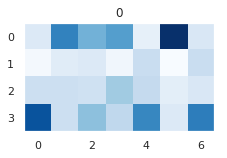

----------------------------------------------------------------------
Mean activation:0.00616
Layer 0, filter#18

array([[0.1 , 0.85, 0.1 , 0.85, 0.  , 0.55, 0.4 ],
       [0.  , 0.  , 0.  , 0.15, 0.4 , 0.  , 0.05],
       [0.05, 0.  , 0.4 , 0.  , 0.6 , 0.  , 0.  ],
       [0.85, 0.15, 0.5 , 0.  , 0.  , 0.45, 0.55]])



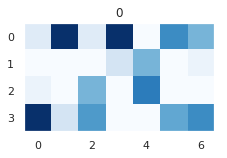

----------------------------------------------------------------------
Mean activation:0.0122
Layer 0, filter#15

array([[0.467, 0.   , 0.933, 0.   , 0.733, 0.   , 0.333],
       [0.333, 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 0.067, 0.   , 0.   , 0.267],
       [0.2  , 1.   , 0.067, 0.933, 0.267, 0.   , 0.4  ]])



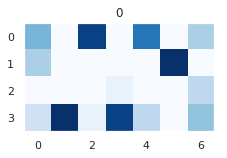

----------------------------------------------------------------------
Mean activation:0.0225
Layer 0, filter#5

array([[0.429, 0.   , 1.   , 0.   , 0.786, 0.   , 0.357],
       [0.357, 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.214],
       [0.214, 1.   , 0.   , 1.   , 0.214, 0.   , 0.429]])



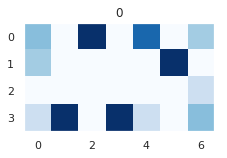

----------------------------------------------------------------------
Mean activation:0.0383
Layer 0, filter#13

array([[0.056, 0.611, 0.   , 0.667, 0.222, 0.444, 0.444],
       [0.056, 0.111, 0.   , 0.056, 0.444, 0.056, 0.167],
       [0.278, 0.   , 0.722, 0.056, 0.056, 0.   , 0.167],
       [0.611, 0.278, 0.278, 0.222, 0.278, 0.5  , 0.222]])



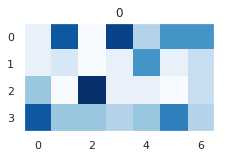

----------------------------------------------------------------------
Mean activation:0.0457
Layer 0, filter#23

array([[0.087, 0.174, 0.826, 0.   , 0.522, 0.174, 0.435],
       [0.522, 0.304, 0.   , 0.   , 0.   , 0.304, 0.478],
       [0.   , 0.   , 0.   , 0.174, 0.174, 0.304, 0.087],
       [0.391, 0.522, 0.174, 0.826, 0.304, 0.217, 0.   ]])



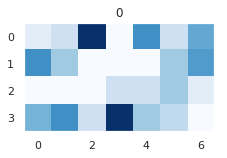

----------------------------------------------------------------------
Mean activation:0.0469
Layer 0, filter#22

array([[0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.]])



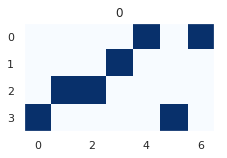

----------------------------------------------------------------------
Mean activation:0.0563
Layer 0, filter#16

array([[0.   , 0.364, 0.364, 0.091, 0.455, 0.455, 0.364],
       [0.545, 0.273, 0.091, 0.   , 0.   , 0.091, 0.364],
       [0.091, 0.   , 0.091, 0.818, 0.364, 0.   , 0.182],
       [0.364, 0.364, 0.455, 0.091, 0.182, 0.455, 0.091]])



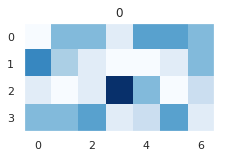

----------------------------------------------------------------------
Mean activation:0.057
Layer 0, filter#2

array([[0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [1. , 1. , 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.5, 0.5, 0.5, 0.5]])



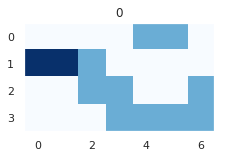

----------------------------------------------------------------------
Mean activation:0.0763
Layer 0, filter#14

array([[0.233, 0.667, 0.533, 0.   , 0.067, 0.7  , 0.267],
       [0.033, 0.033, 0.1  , 0.   , 0.   , 0.033, 0.133],
       [0.   , 0.2  , 0.   , 1.   , 0.133, 0.   , 0.033],
       [0.733, 0.1  , 0.367, 0.   , 0.8  , 0.267, 0.567]])



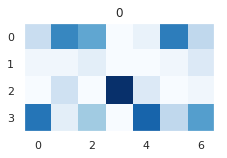

----------------------------------------------------------------------
Mean activation:0.0879
Layer 0, filter#6

array([[0.25 , 0.5  , 0.375, 0.   , 0.   , 0.75 , 0.125],
       [0.125, 0.   , 0.   , 0.5  , 0.   , 0.   , 0.625],
       [0.125, 0.   , 0.   , 0.5  , 1.   , 0.   , 0.   ],
       [0.5  , 0.5  , 0.625, 0.   , 0.   , 0.25 , 0.25 ]])



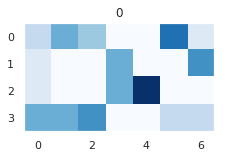

----------------------------------------------------------------------
Mean activation:0.102
Layer 0, filter#25

array([[0.19 , 0.476, 0.405, 0.262, 0.048, 0.786, 0.19 ],
       [0.024, 0.024, 0.19 , 0.   , 0.   , 0.024, 0.238],
       [0.262, 0.286, 0.   , 0.738, 0.095, 0.   , 0.024],
       [0.524, 0.214, 0.405, 0.   , 0.857, 0.19 , 0.548]])



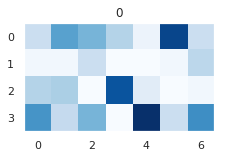

----------------------------------------------------------------------
Mean activation:0.114
Layer 0, filter#7

array([[0.467, 0.   , 0.   , 0.333, 0.133, 0.4  , 0.533],
       [0.067, 0.067, 0.533, 0.   , 0.   , 0.067, 0.333],
       [0.333, 0.4  , 0.   , 0.667, 0.   , 0.   , 0.067],
       [0.133, 0.533, 0.467, 0.   , 0.867, 0.533, 0.067]])



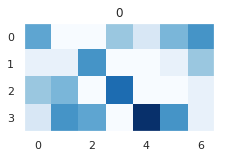

----------------------------------------------------------------------
Mean activation:0.127
Layer 0, filter#8

array([[0.   , 0.   , 0.   , 0.   , 0.667, 0.333, 0.667],
       [0.333, 0.333, 1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.667, 0.667, 0.   , 0.   , 0.333, 0.667, 0.333]])



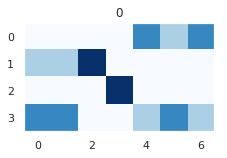

----------------------------------------------------------------------
Mean activation:0.147
Layer 0, filter#11

array([[0.   , 0.   , 0.333, 0.   , 0.667, 0.333, 1.   ],
       [1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.667, 1.   , 0.333, 0.667, 0.   ]])



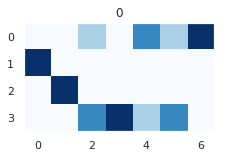

----------------------------------------------------------------------
Mean activation:0.165
Layer 0, filter#31

array([[0.   , 0.   , 0.   , 0.   , 0.667, 0.333, 0.667],
       [0.333, 0.333, 1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.667, 0.667, 0.   , 0.   , 0.333, 0.667, 0.333]])



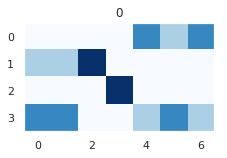

----------------------------------------------------------------------
Mean activation:0.165
Layer 0, filter#1

array([[0.286, 0.   , 0.   , 0.714, 0.286, 1.   , 0.   ],
       [0.   , 0.286, 1.   , 0.   , 0.   , 0.   , 0.714],
       [0.714, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.714, 0.   , 0.286, 0.714, 0.   , 0.286]])



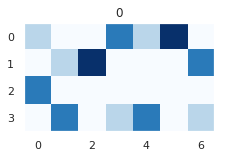

----------------------------------------------------------------------
Mean activation:0.18
Layer 0, filter#4

array([[0.444, 0.444, 0.444, 0.222, 0.333, 0.   , 0.111],
       [0.   , 0.   , 0.   , 0.   , 0.667, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.111],
       [0.556, 0.556, 0.556, 0.778, 0.   , 0.   , 0.778]])



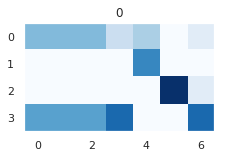

----------------------------------------------------------------------
Mean activation:0.196
Layer 0, filter#12

array([[0.   , 0.   , 0.833, 0.   , 0.917, 0.083, 1.   ],
       [1.   , 0.   , 0.   , 0.   , 0.   , 0.417, 0.   ],
       [0.   , 0.25 , 0.   , 0.333, 0.   , 0.   , 0.   ],
       [0.   , 0.75 , 0.167, 0.667, 0.083, 0.5  , 0.   ]])



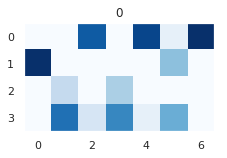

----------------------------------------------------------------------
Mean activation:0.199
Layer 0, filter#28

array([[0.   , 0.273, 0.   , 0.091, 0.909, 0.364, 0.545],
       [0.091, 0.182, 0.   , 0.545, 0.   , 0.   , 0.   ],
       [0.091, 0.545, 1.   , 0.   , 0.   , 0.   , 0.182],
       [0.818, 0.   , 0.   , 0.364, 0.091, 0.636, 0.273]])



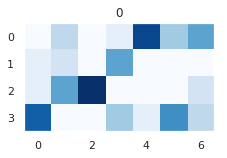

----------------------------------------------------------------------
Mean activation:0.213
Layer 0, filter#21

array([[0.   , 0.   , 0.111, 0.667, 0.222, 0.778, 0.333],
       [0.333, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.667, 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.889, 0.333, 0.778, 0.222, 0.667]])



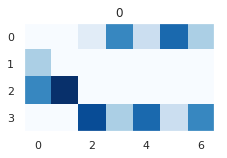

----------------------------------------------------------------------
Mean activation:0.232
Layer 0, filter#20

array([[0.5 , 0.  , 0.75, 0.  , 0.  , 0.5 , 0.25],
       [0.25, 0.  , 0.  , 1.  , 0.  , 0.  , 0.25],
       [0.25, 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.25, 0.  , 0.  , 0.5 , 0.5 ]])



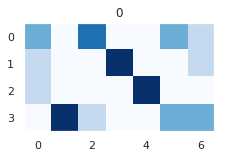

----------------------------------------------------------------------
Mean activation:0.252
Layer 0, filter#3

array([[0.   , 0.231, 0.385, 0.308, 0.692, 0.538, 0.385],
       [0.077, 0.769, 0.   , 0.   , 0.   , 0.   , 0.231],
       [0.077, 0.   , 0.385, 0.   , 0.   , 0.   , 0.154],
       [0.846, 0.   , 0.231, 0.692, 0.308, 0.462, 0.231]])



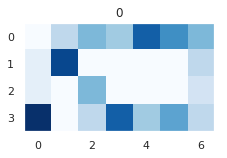

----------------------------------------------------------------------
Mean activation:0.283
Layer 0, filter#24

array([[0.   , 0.   , 0.385, 0.077, 0.923, 0.077, 0.846],
       [0.077, 0.538, 0.   , 0.462, 0.   , 0.   , 0.   ],
       [0.077, 0.462, 0.615, 0.   , 0.   , 0.   , 0.154],
       [0.846, 0.   , 0.   , 0.462, 0.077, 0.923, 0.   ]])



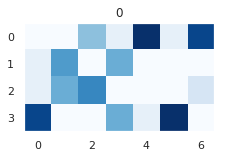

----------------------------------------------------------------------
Mean activation:0.286
Layer 0, filter#17

array([[0.118, 0.765, 0.176, 0.529, 0.   , 0.882, 0.059],
       [0.059, 0.   , 0.   , 0.235, 0.   , 0.   , 0.294],
       [0.059, 0.   , 0.   , 0.235, 1.   , 0.   , 0.   ],
       [0.765, 0.235, 0.824, 0.   , 0.   , 0.118, 0.647]])



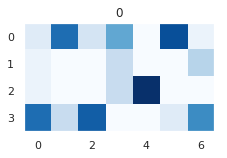

----------------------------------------------------------------------
Mean activation:0.359
Layer 0, filter#27

array([[0.  , 0.  , 0.  , 0.5 , 0.25, 0.5 , 0.  ],
       [0.5 , 1.  , 0.25, 0.  , 0.  , 0.25, 0.  ],
       [0.5 , 0.  , 0.5 , 0.25, 0.  , 0.  , 0.75],
       [0.  , 0.  , 0.25, 0.25, 0.75, 0.25, 0.25]])



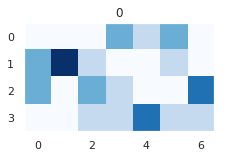

----------------------------------------------------------------------
Mean activation:0.4
Layer 0, filter#29

array([[0. , 0. , 0. , 0.5, 0.5, 0.5, 0. ],
       [0.5, 1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 1. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0.5, 0.5, 0.5, 0. ]])



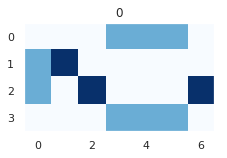

----------------------------------------------------------------------
Mean activation:0.449
Layer 0, filter#19

array([[0.   , 0.   , 0.   , 0.   , 0.667, 0.333, 0.667],
       [0.333, 0.333, 1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.667, 0.667, 0.   , 0.   , 0.333, 0.667, 0.333]])



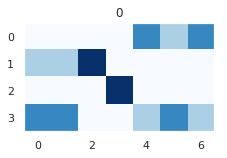

----------------------------------------------------------------------
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[10  0 26  9 18 15  5 13 23 22 16  2 14  6 25  7  8 11 30  1  4 12 28 21
 20  3 24 17 27 29 19]
Mean activation:1.99e-16
Layer 0, filter#10

array([[0.021, 0.035, 0.082, 0.   , 0.139, 0.151, 0.047],
       [0.748, 0.274, 0.785, 0.209, 0.469, 0.43 , 0.441],
       [0.086, 0.649, 0.133, 0.712, 0.322, 0.322, 0.394],
       [0.146, 0.042, 0.   , 0.079, 0.071, 0.097, 0.119]])



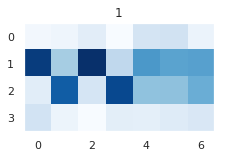

----------------------------------------------------------------------
Mean activation:1.62e-05
Layer 0, filter#0

array([[0.146, 0.104, 0.12 , 0.107, 0.099, 0.076, 0.   ],
       [0.471, 0.36 , 0.403, 0.424, 0.346, 0.636, 0.   ],
       [0.257, 0.425, 0.361, 0.377, 0.435, 0.248, 1.   ],
       [0.126, 0.111, 0.116, 0.091, 0.12 , 0.039, 0.   ]])



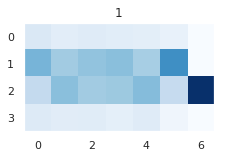

----------------------------------------------------------------------
Mean activation:0.000206
Layer 0, filter#26

array([[0.12 , 0.097, 0.067, 0.   , 0.133, 0.114, 0.147],
       [0.462, 0.35 , 0.712, 0.   , 0.535, 0.347, 0.348],
       [0.277, 0.432, 0.172, 1.   , 0.213, 0.425, 0.403],
       [0.141, 0.121, 0.048, 0.   , 0.119, 0.114, 0.102]])



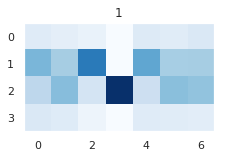

----------------------------------------------------------------------
Mean activation:0.00314
Layer 0, filter#9

array([[0.193, 0.096, 0.087, 0.12 , 0.002, 0.138, 0.056],
       [0.388, 0.412, 0.45 , 0.135, 0.992, 0.279, 0.189],
       [0.269, 0.391, 0.384, 0.587, 0.001, 0.473, 0.571],
       [0.15 , 0.101, 0.079, 0.158, 0.006, 0.11 , 0.184]])



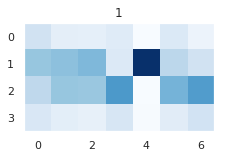

----------------------------------------------------------------------
Mean activation:0.0151
Layer 0, filter#15

array([[0.098, 0.34 , 0.08 , 0.134, 0.202, 0.   , 0.627],
       [0.276, 0.332, 0.501, 0.277, 0.19 , 1.   , 0.067],
       [0.366, 0.214, 0.356, 0.553, 0.444, 0.   , 0.225],
       [0.259, 0.114, 0.063, 0.036, 0.164, 0.   , 0.08 ]])



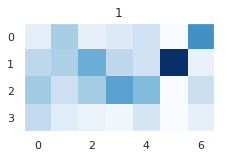

----------------------------------------------------------------------
Mean activation:0.0185
Layer 0, filter#18

array([[0.108, 0.039, 0.044, 0.318, 0.   , 0.339, 0.196],
       [0.802, 0.061, 0.   , 0.643, 0.213, 0.277, 0.403],
       [0.09 , 0.844, 0.832, 0.   , 0.787, 0.   , 0.131],
       [0.   , 0.056, 0.123, 0.039, 0.   , 0.384, 0.271]])



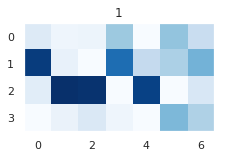

----------------------------------------------------------------------
Mean activation:0.0201
Layer 0, filter#5

array([[0.4 , 0.34, 0.16, 0.48, 0.66, 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.46, 0.  , 0.  , 0.  , 1.  ],
       [0.6 , 0.66, 0.36, 0.52, 0.34, 0.  , 0.  ]])



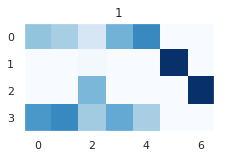

----------------------------------------------------------------------
Mean activation:0.0385
Layer 0, filter#30

array([[0.02 , 0.286, 0.064, 0.321, 0.03 , 0.148, 0.   ],
       [0.805, 0.284, 0.448, 0.234, 0.228, 0.631, 0.009],
       [0.108, 0.203, 0.416, 0.302, 0.714, 0.093, 0.966],
       [0.067, 0.228, 0.071, 0.144, 0.028, 0.128, 0.025]])



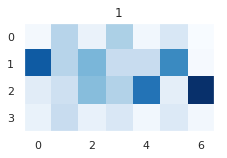

----------------------------------------------------------------------
Mean activation:0.041
Layer 0, filter#22

array([[0.168, 0.012, 0.088, 0.001, 0.003, 0.084, 0.176],
       [0.509, 0.017, 0.527, 0.973, 0.05 , 0.657, 0.291],
       [0.187, 0.954, 0.246, 0.021, 0.947, 0.187, 0.4  ],
       [0.136, 0.018, 0.139, 0.005, 0.   , 0.072, 0.133]])



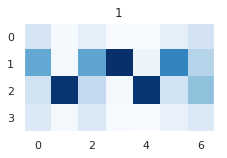

----------------------------------------------------------------------
Mean activation:0.0693
Layer 0, filter#13

array([[0.071, 0.171, 0.   , 0.189, 0.097, 0.122, 0.065],
       [0.67 , 0.036, 0.   , 0.468, 0.398, 0.638, 0.127],
       [0.173, 0.539, 0.986, 0.203, 0.366, 0.132, 0.662],
       [0.087, 0.254, 0.014, 0.141, 0.139, 0.108, 0.147]])



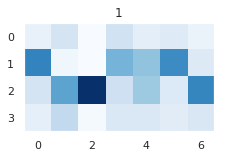

----------------------------------------------------------------------
Mean activation:0.0772
Layer 0, filter#23

array([[0.088, 0.061, 0.2  , 0.067, 0.028, 0.127, 0.051],
       [0.444, 0.533, 0.455, 0.084, 0.058, 0.642, 0.546],
       [0.38 , 0.32 , 0.207, 0.755, 0.839, 0.138, 0.377],
       [0.088, 0.086, 0.139, 0.094, 0.074, 0.094, 0.026]])



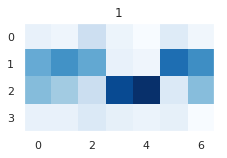

----------------------------------------------------------------------
Mean activation:0.0892
Layer 0, filter#16

array([[0.024, 0.145, 0.032, 0.062, 0.045, 0.001, 0.027],
       [0.887, 0.785, 0.469, 0.071, 0.511, 0.467, 0.414],
       [0.086, 0.032, 0.244, 0.859, 0.319, 0.461, 0.525],
       [0.003, 0.038, 0.254, 0.008, 0.125, 0.071, 0.035]])



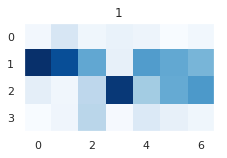

----------------------------------------------------------------------
Mean activation:0.116
Layer 0, filter#6

array([[0.141, 0.133, 0.108, 0.001, 0.031, 0.03 , 0.17 ],
       [0.472, 0.366, 0.234, 0.97 , 0.   , 0.72 , 0.278],
       [0.313, 0.37 , 0.445, 0.029, 0.968, 0.152, 0.473],
       [0.074, 0.13 , 0.213, 0.   , 0.001, 0.099, 0.079]])



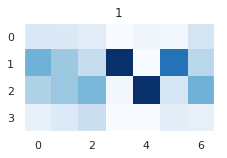

----------------------------------------------------------------------
Mean activation:0.134
Layer 0, filter#14

array([[0.087, 0.095, 0.055, 0.   , 0.075, 0.134, 0.093],
       [0.479, 0.307, 0.851, 0.   , 0.587, 0.389, 0.332],
       [0.318, 0.505, 0.04 , 1.   , 0.234, 0.356, 0.49 ],
       [0.115, 0.092, 0.054, 0.   , 0.103, 0.121, 0.085]])



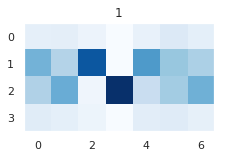

----------------------------------------------------------------------
Mean activation:0.141
Layer 0, filter#4

array([[0.467, 0.666, 0.336, 0.34 , 0.004, 0.   , 0.085],
       [0.087, 0.054, 0.187, 0.305, 0.932, 0.18 , 0.29 ],
       [0.056, 0.008, 0.112, 0.019, 0.044, 0.82 , 0.465],
       [0.39 , 0.272, 0.365, 0.336, 0.019, 0.   , 0.16 ]])



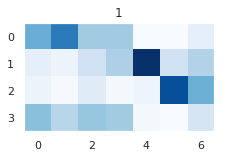

----------------------------------------------------------------------
Mean activation:0.143
Layer 0, filter#8

array([[0.086, 0.032, 0.   , 0.   , 0.125, 0.133, 0.139],
       [0.534, 0.315, 1.   , 0.   , 0.545, 0.297, 0.383],
       [0.234, 0.52 , 0.   , 1.   , 0.242, 0.446, 0.368],
       [0.146, 0.133, 0.   , 0.   , 0.088, 0.123, 0.11 ]])



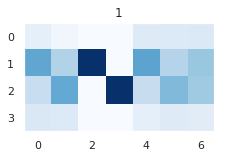

----------------------------------------------------------------------
Mean activation:0.144
Layer 0, filter#1

array([[0.244, 0.153, 0.   , 0.231, 0.022, 0.088, 0.049],
       [0.197, 0.166, 1.   , 0.507, 0.328, 0.593, 0.177],
       [0.38 , 0.58 , 0.   , 0.   , 0.583, 0.269, 0.637],
       [0.18 , 0.101, 0.   , 0.262, 0.068, 0.051, 0.137]])



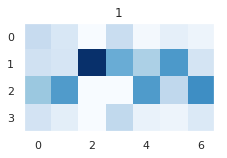

----------------------------------------------------------------------
Mean activation:0.147
Layer 0, filter#25

array([[1.209e-01, 1.046e-01, 0.000e+00, 8.090e-04, 1.166e-01, 1.425e-01,
        1.342e-01],
       [4.447e-01, 3.061e-01, 9.962e-01, 0.000e+00, 5.040e-01, 3.307e-01,
        3.481e-01],
       [2.761e-01, 4.580e-01, 0.000e+00, 9.992e-01, 2.606e-01, 4.285e-01,
        4.062e-01],
       [1.583e-01, 1.313e-01, 3.775e-03, 0.000e+00, 1.188e-01, 9.829e-02,
        1.115e-01]])



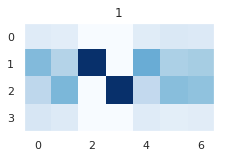

----------------------------------------------------------------------
Mean activation:0.15
Layer 0, filter#7

array([[0.163, 0.12 , 0.   , 0.006, 0.096, 0.185, 0.198],
       [0.304, 0.298, 0.995, 0.   , 0.492, 0.502, 0.111],
       [0.334, 0.357, 0.   , 0.988, 0.244, 0.247, 0.531],
       [0.199, 0.225, 0.005, 0.005, 0.168, 0.065, 0.16 ]])



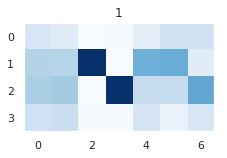

----------------------------------------------------------------------
Mean activation:0.158
Layer 0, filter#31

array([[0.111, 0.108, 0.   , 0.   , 0.137, 0.133, 0.14 ],
       [0.482, 0.29 , 1.   , 0.   , 0.516, 0.309, 0.366],
       [0.258, 0.467, 0.   , 1.   , 0.245, 0.437, 0.385],
       [0.149, 0.135, 0.   , 0.   , 0.103, 0.121, 0.109]])



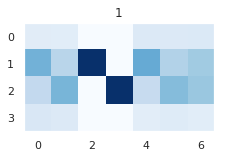

----------------------------------------------------------------------
Mean activation:0.163
Layer 0, filter#11

array([[0.   , 0.   , 0.149, 0.128, 0.118, 0.137, 0.132],
       [1.   , 0.   , 0.553, 0.351, 0.36 , 0.45 , 0.318],
       [0.   , 1.   , 0.207, 0.423, 0.429, 0.302, 0.413],
       [0.   , 0.   , 0.091, 0.097, 0.094, 0.111, 0.137]])



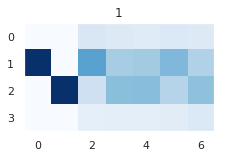

----------------------------------------------------------------------
Mean activation:0.174
Layer 0, filter#2

array([[0.048, 0.   , 0.   , 0.019, 0.05 , 0.057, 0.096],
       [0.467, 0.929, 0.251, 0.522, 0.507, 0.361, 0.472],
       [0.386, 0.071, 0.713, 0.444, 0.388, 0.532, 0.365],
       [0.099, 0.   , 0.036, 0.015, 0.055, 0.05 , 0.067]])



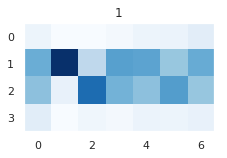

----------------------------------------------------------------------
Mean activation:0.186
Layer 0, filter#21

array([[0.   , 0.   , 0.187, 0.335, 0.216, 0.285, 0.22 ],
       [1.   , 0.   , 0.353, 0.369, 0.294, 0.318, 0.286],
       [0.   , 1.   , 0.267, 0.1  , 0.301, 0.221, 0.1  ],
       [0.   , 0.   , 0.193, 0.195, 0.189, 0.176, 0.395]])



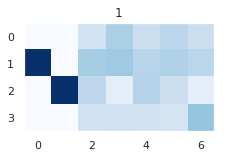

----------------------------------------------------------------------
Mean activation:0.273
Layer 0, filter#28

array([[0.09 , 0.   , 0.   , 0.177, 0.228, 0.352, 0.269],
       [0.167, 1.   , 0.   , 0.549, 0.182, 0.264, 0.307],
       [0.454, 0.   , 1.   , 0.158, 0.383, 0.178, 0.188],
       [0.288, 0.   , 0.   , 0.116, 0.207, 0.206, 0.236]])



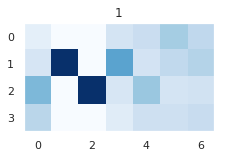

----------------------------------------------------------------------
Mean activation:0.283
Layer 0, filter#20

array([[0.158, 0.099, 0.114, 0.   , 0.   , 0.143, 0.151],
       [0.489, 0.363, 0.306, 1.   , 0.   , 0.532, 0.249],
       [0.244, 0.425, 0.453, 0.   , 1.   , 0.239, 0.455],
       [0.109, 0.113, 0.128, 0.   , 0.   , 0.086, 0.145]])



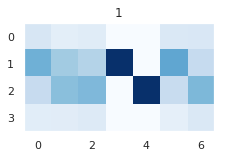

----------------------------------------------------------------------
Mean activation:0.299
Layer 0, filter#12

array([[0.029, 0.02 , 0.133, 0.084, 0.148, 0.114, 0.212],
       [0.868, 0.051, 0.83 , 0.073, 0.656, 0.188, 0.544],
       [0.1  , 0.878, 0.031, 0.785, 0.156, 0.564, 0.149],
       [0.002, 0.051, 0.006, 0.058, 0.039, 0.134, 0.095]])



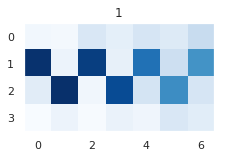

----------------------------------------------------------------------
Mean activation:0.319
Layer 0, filter#19

array([[0.14 , 0.082, 0.   , 0.   , 0.277, 0.288, 0.289],
       [0.463, 0.215, 1.   , 0.   , 0.382, 0.203, 0.319],
       [0.239, 0.508, 0.   , 1.   , 0.204, 0.245, 0.17 ],
       [0.157, 0.195, 0.   , 0.   , 0.137, 0.264, 0.221]])



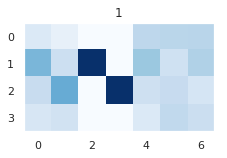

----------------------------------------------------------------------
Mean activation:0.358
Layer 0, filter#17

array([[0.422, 0.242, 0.138, 0.   , 0.   , 0.297, 0.296],
       [0.13 , 0.249, 0.28 , 1.   , 0.   , 0.339, 0.24 ],
       [0.168, 0.276, 0.252, 0.   , 1.   , 0.214, 0.218],
       [0.281, 0.234, 0.33 , 0.   , 0.   , 0.151, 0.246]])



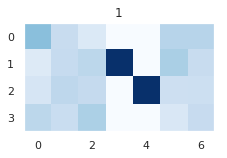

----------------------------------------------------------------------
Mean activation:0.364
Layer 0, filter#27

array([[0.095, 0.003, 0.002, 0.124, 0.148, 0.132, 0.153],
       [0.377, 0.992, 0.04 , 0.543, 0.351, 0.38 , 0.335],
       [0.39 , 0.   , 0.956, 0.241, 0.352, 0.388, 0.377],
       [0.138, 0.005, 0.001, 0.092, 0.15 , 0.1  , 0.135]])



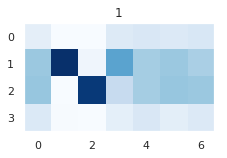

----------------------------------------------------------------------
Mean activation:0.364
Layer 0, filter#3

array([[0.098, 0.   , 0.   , 0.233, 0.332, 0.274, 0.264],
       [0.203, 1.   , 0.   , 0.409, 0.201, 0.312, 0.35 ],
       [0.372, 0.   , 1.   , 0.197, 0.186, 0.189, 0.146],
       [0.327, 0.   , 0.   , 0.161, 0.28 , 0.225, 0.24 ]])



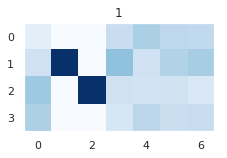

----------------------------------------------------------------------
Mean activation:0.366
Layer 0, filter#24

array([[1.203e-01, 4.081e-04, 1.496e-03, 1.132e-01, 1.413e-01, 1.449e-01,
        1.554e-01],
       [3.304e-01, 9.978e-01, 0.000e+00, 5.954e-01, 3.877e-01, 3.497e-01,
        3.640e-01],
       [3.863e-01, 1.768e-03, 9.946e-01, 1.989e-01, 3.395e-01, 4.077e-01,
        3.514e-01],
       [1.630e-01, 0.000e+00, 3.945e-03, 9.250e-02, 1.314e-01, 9.767e-02,
        1.292e-01]])



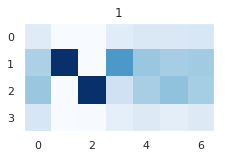

----------------------------------------------------------------------
Mean activation:0.406
Layer 0, filter#29

array([[0.092, 0.   , 0.   , 0.116, 0.139, 0.151, 0.162],
       [0.338, 1.   , 0.   , 0.611, 0.371, 0.351, 0.372],
       [0.399, 0.   , 1.   , 0.19 , 0.355, 0.402, 0.337],
       [0.17 , 0.   , 0.   , 0.082, 0.134, 0.096, 0.13 ]])



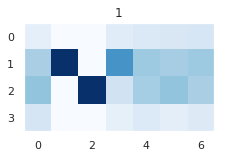

----------------------------------------------------------------------
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[10  0 26  9 15 18  5 30 22 13 23 16  6 14  4  8  1 25  7 31 11  2 21 28
 20 12 19 17 27  3 24 29]


In [284]:
np.set_printoptions(precision=3)
for j in range(len(mean_activations_for_classes)):
    
    mean_activations = mean_activations_for_classes[j]
    PWMs = PWMs_for_classes[j]
    layers_idxs = layers_idxs_for_classes[j]
    filters_idxs = filters_idxs_for_classes[j]

    
    sorted_idxs = np.argsort(mean_activations)

    for i in sorted_idxs:
        mean_activation = mean_activations[i]
        PWM = PWMs[i]
        layer_idx = layers_idxs[i]
        filter_idx = filters_idxs[i]

        print(f"Mean activation:{mean_activation:.3}")
        print(f"Layer {layer_idx}, filter#{filter_idx}\n")
        print(f"{repr(PWM)}")
        print()
        plt.figure(figsize=(12,2))
        ax = plt.imshow(PWM, cmap = plt.get_cmap('Blues') )

        plt.grid(False)

        gridlinewidth = 1.6

        plt.title(str(j))
        plt.show()
        
        print("----------------------------------------------------------------------")
        
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(sorted_idxs)

# PWM Exp 3: PWM for all subsequences

# Motif (PWM) generation from Conv1 layers n_dictxL filter weights*all L-length subsequences, keeping the ones that leads to activations greater than half of the maximum activation, and computing the probability # of each nucleotide at each of L position of the subsequence. Only consider motifs of length 6 or greater

[torch.Size([32, 4, 7]), torch.Size([32]), torch.Size([64, 32, 5]), torch.Size([64]), torch.Size([128, 64, 3]), torch.Size([128]), torch.Size([64, 4608]), torch.Size([64]), torch.Size([16, 64]), torch.Size([16]), torch.Size([2, 16]), torch.Size([2])]
['A', 'C', 'G', 'T']
Mean activation: 1.843963065252928e-16
Layer 0, filter#10
 [[0.042 0.127 0.259 0.    0.332 0.435 0.075]
 [0.541 0.364 0.559 0.185 0.341 0.293 0.351]
 [0.076 0.37  0.183 0.501 0.172 0.114 0.248]
 [0.341 0.138 0.    0.313 0.155 0.158 0.326]]



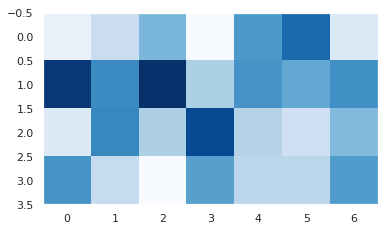

----------------------------------------------------------------------
Mean activation: 1.799224082787987e-05
Layer 0, filter#0
 [[0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 1.  ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.  ]]



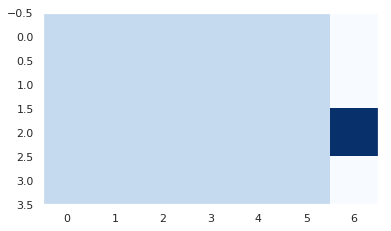

----------------------------------------------------------------------
Mean activation: 0.0002053396456176415
Layer 0, filter#26
 [[0.25 0.25 0.25 0.   0.25 0.25 0.25]
 [0.25 0.25 0.25 0.   0.25 0.25 0.25]
 [0.25 0.25 0.25 1.   0.25 0.25 0.25]
 [0.25 0.25 0.25 0.   0.25 0.25 0.25]]



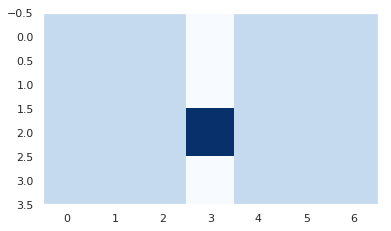

----------------------------------------------------------------------
Mean activation: 0.003801209619268775
Layer 0, filter#9
 [[0.334 0.245 0.231 0.252 0.007 0.461 0.126]
 [0.186 0.27  0.23  0.182 0.979 0.127 0.175]
 [0.236 0.281 0.317 0.276 0.007 0.132 0.354]
 [0.243 0.205 0.222 0.289 0.007 0.28  0.346]]



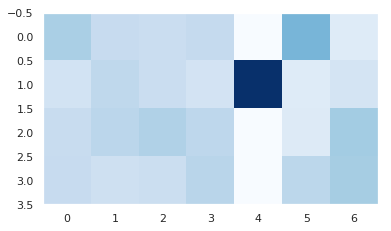

----------------------------------------------------------------------
Mean activation: 0.018198059871792793
Layer 0, filter#15
 [[0.236 0.347 0.258 0.259 0.252 0.    0.867]
 [0.201 0.201 0.246 0.189 0.232 1.    0.028]
 [0.293 0.221 0.264 0.321 0.231 0.    0.022]
 [0.269 0.231 0.231 0.231 0.285 0.    0.082]]



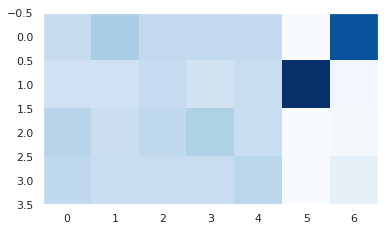

----------------------------------------------------------------------
Mean activation: 0.01945214718580246
Layer 0, filter#18
 [[0.409 0.188 0.08  0.617 0.    0.473 0.198]
 [0.294 0.026 0.    0.319 0.284 0.073 0.393]
 [0.259 0.719 0.725 0.    0.716 0.    0.096]
 [0.038 0.067 0.195 0.064 0.    0.454 0.313]]



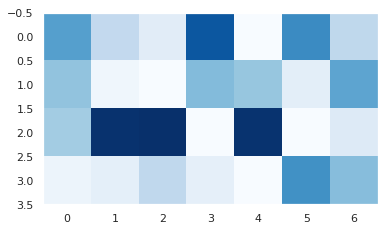

----------------------------------------------------------------------
Mean activation: 0.022102689370512962
Layer 0, filter#5
 [[0.306 0.306 0.361 0.369 0.678 0.008 0.443]
 [0.016 0.    0.102 0.    0.008 0.643 0.243]
 [0.008 0.    0.176 0.    0.008 0.051 0.157]
 [0.671 0.694 0.361 0.631 0.306 0.298 0.157]]



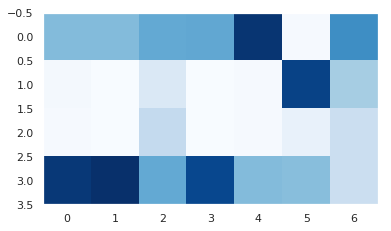

----------------------------------------------------------------------
Mean activation: 0.042298559099435806
Layer 0, filter#22
 [[0.213 0.023 0.155 0.102 0.151 0.191 0.368]
 [0.052 0.007 0.305 0.759 0.139 0.335 0.204]
 [0.141 0.945 0.206 0.021 0.591 0.209 0.191]
 [0.594 0.025 0.335 0.119 0.119 0.266 0.237]]



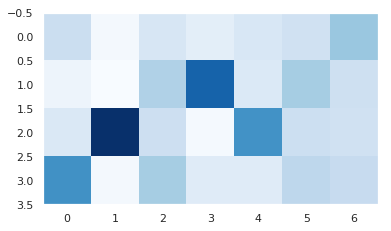

----------------------------------------------------------------------
Mean activation: 0.05868460237979889
Layer 0, filter#30
 [[0.043 0.544 0.14  0.409 0.049 0.351 0.009]
 [0.768 0.116 0.363 0.069 0.374 0.095 0.067]
 [0.146 0.022 0.351 0.103 0.533 0.09  0.858]
 [0.043 0.318 0.146 0.419 0.043 0.465 0.067]]



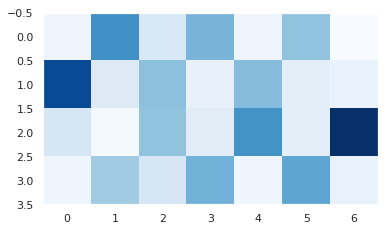

----------------------------------------------------------------------
Mean activation: 0.08102580159902573
Layer 0, filter#13
 [[1.823e-01 3.230e-01 8.137e-04 1.945e-01 2.091e-01 2.734e-01 1.945e-01]
 [4.101e-01 8.137e-04 0.000e+00 3.328e-01 3.808e-01 3.206e-01 2.392e-01]
 [2.897e-01 4.475e-02 9.943e-01 2.791e-01 1.326e-01 1.473e-01 3.255e-01]
 [1.180e-01 6.314e-01 4.882e-03 1.937e-01 2.775e-01 2.587e-01 2.408e-01]]



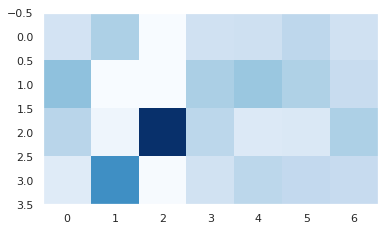

----------------------------------------------------------------------
Mean activation: 0.11015603691339493
Layer 0, filter#16
 [[0.014 0.438 0.119 0.103 0.211 0.119 0.123]
 [0.85  0.452 0.058 0.052 0.144 0.323 0.297]
 [0.125 0.03  0.103 0.731 0.444 0.211 0.345]
 [0.011 0.081 0.72  0.114 0.202 0.347 0.234]]



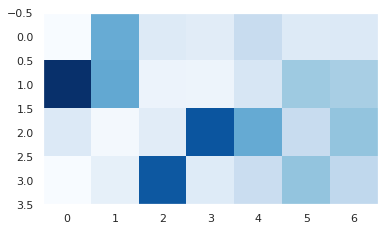

----------------------------------------------------------------------
Mean activation: 0.11223297566175461
Layer 0, filter#23
 [[0.112 0.116 0.556 0.09  0.02  0.114 0.193]
 [0.277 0.6   0.072 0.01  0.008 0.502 0.6  ]
 [0.446 0.122 0.07  0.494 0.958 0.169 0.1  ]
 [0.165 0.161 0.301 0.406 0.014 0.215 0.106]]



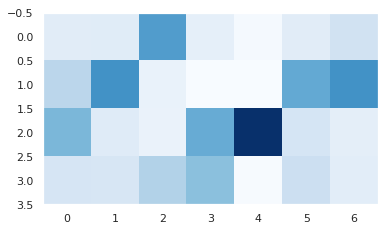

----------------------------------------------------------------------
Mean activation: 0.1163671687245369
Layer 0, filter#6
 [[0.25  0.382 0.167 0.018 0.16  0.064 0.38 ]
 [0.284 0.193 0.078 0.807 0.02  0.467 0.352]
 [0.324 0.174 0.191 0.152 0.745 0.173 0.159]
 [0.142 0.25  0.565 0.023 0.074 0.296 0.109]]



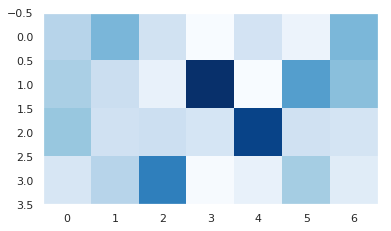

----------------------------------------------------------------------
Mean activation: 0.12832365930080414
Layer 0, filter#14
 [[0.137 0.248 0.128 0.002 0.109 0.356 0.153]
 [0.262 0.248 0.516 0.    0.48  0.311 0.236]
 [0.396 0.371 0.042 0.996 0.223 0.06  0.409]
 [0.205 0.132 0.314 0.003 0.188 0.273 0.203]]



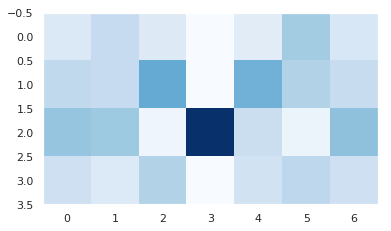

----------------------------------------------------------------------
Mean activation: 0.13084465265274048
Layer 0, filter#8
 [[0.207 0.081 0.    0.    0.224 0.272 0.259]
 [0.312 0.304 1.    0.    0.281 0.262 0.263]
 [0.226 0.327 0.    1.    0.264 0.205 0.214]
 [0.255 0.287 0.    0.    0.231 0.262 0.264]]



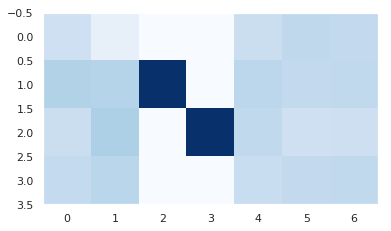

----------------------------------------------------------------------
Mean activation: 0.14721928536891937
Layer 0, filter#25
 [[0.241 0.216 0.008 0.206 0.177 0.317 0.236]
 [0.144 0.286 0.887 0.    0.187 0.255 0.236]
 [0.383 0.251 0.    0.783 0.245 0.238 0.256]
 [0.231 0.247 0.105 0.011 0.392 0.19  0.272]]



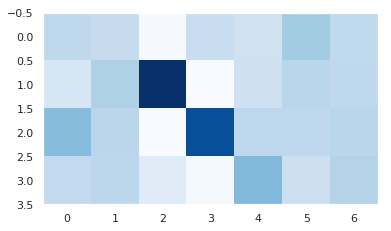

----------------------------------------------------------------------
Mean activation: 0.14871852099895477
Layer 0, filter#4
 [[0.533 0.724 0.492 0.52  0.127 0.052 0.145]
 [0.049 0.007 0.106 0.105 0.551 0.189 0.155]
 [0.015 0.    0.04  0.009 0.095 0.547 0.292]
 [0.403 0.269 0.362 0.366 0.227 0.213 0.408]]



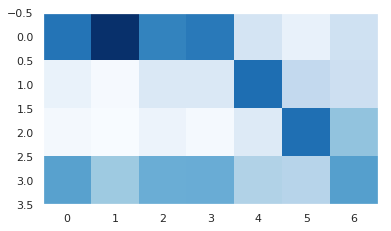

----------------------------------------------------------------------
Mean activation: 0.15021057426929474
Layer 0, filter#7
 [[0.309 0.148 0.005 0.283 0.139 0.27  0.331]
 [0.11  0.186 0.958 0.004 0.279 0.43  0.127]
 [0.318 0.244 0.015 0.686 0.206 0.163 0.243]
 [0.263 0.422 0.022 0.027 0.375 0.137 0.299]]



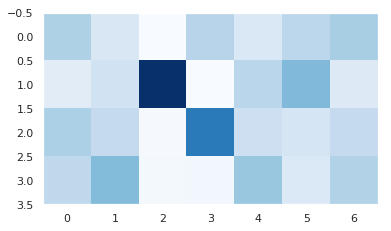

----------------------------------------------------------------------
Mean activation: 0.15525762736797333
Layer 0, filter#31
 [[0.251 0.246 0.    0.    0.251 0.251 0.25 ]
 [0.246 0.251 1.    0.    0.251 0.251 0.25 ]
 [0.251 0.251 0.    1.    0.251 0.247 0.249]
 [0.251 0.251 0.    0.    0.246 0.25  0.25 ]]



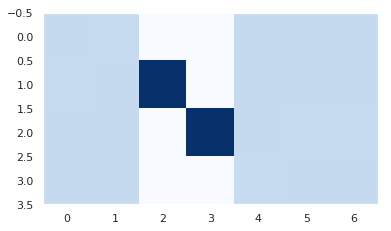

----------------------------------------------------------------------
Mean activation: 0.15947535634040833
Layer 0, filter#11
 [[0.   0.   0.25 0.25 0.25 0.25 0.25]
 [1.   0.   0.25 0.25 0.25 0.25 0.25]
 [0.   1.   0.25 0.25 0.25 0.25 0.25]
 [0.   0.   0.25 0.25 0.25 0.25 0.25]]



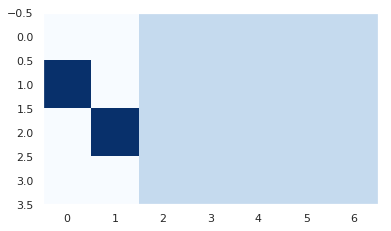

----------------------------------------------------------------------
Mean activation: 0.16901186108589172
Layer 0, filter#1
 [[0.26  0.203 0.    0.528 0.067 0.303 0.14 ]
 [0.051 0.276 1.    0.068 0.311 0.216 0.24 ]
 [0.448 0.279 0.    0.    0.387 0.308 0.367]
 [0.241 0.242 0.    0.404 0.235 0.173 0.252]]



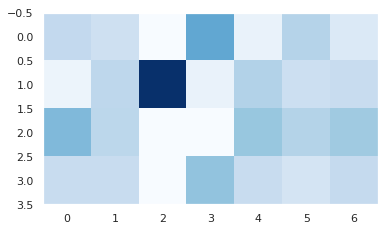

----------------------------------------------------------------------
Mean activation: 0.1704464703798294
Layer 0, filter#2
 [[0.076 0.025 0.042 0.025 0.074 0.109 0.132]
 [0.469 0.826 0.121 0.225 0.315 0.413 0.464]
 [0.35  0.078 0.775 0.703 0.542 0.379 0.219]
 [0.105 0.071 0.062 0.047 0.069 0.098 0.185]]



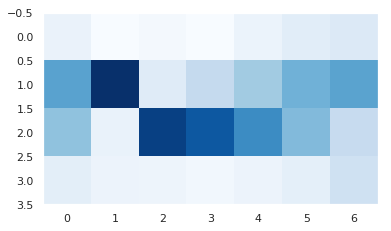

----------------------------------------------------------------------
Mean activation: 0.19154119491577148
Layer 0, filter#21
 [[0.038 0.013 0.222 0.425 0.303 0.31  0.254]
 [0.756 0.01  0.218 0.204 0.156 0.198 0.195]
 [0.055 0.975 0.198 0.094 0.169 0.193 0.064]
 [0.151 0.002 0.361 0.277 0.372 0.299 0.487]]



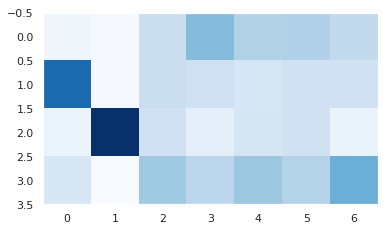

----------------------------------------------------------------------
Mean activation: 0.2614290714263916
Layer 0, filter#20
 [[0.251 0.247 0.237 0.    0.    0.251 0.252]
 [0.254 0.244 0.254 1.    0.    0.254 0.252]
 [0.251 0.254 0.254 0.    1.    0.254 0.246]
 [0.243 0.254 0.254 0.    0.    0.24  0.249]]



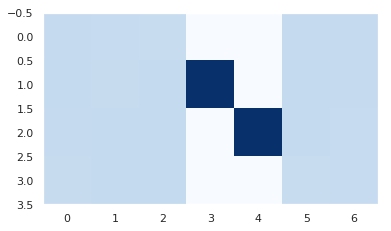

----------------------------------------------------------------------
Mean activation: 0.27495700120925903
Layer 0, filter#12
 [[0.05  0.039 0.268 0.175 0.364 0.157 0.495]
 [0.861 0.025 0.634 0.145 0.507 0.152 0.309]
 [0.077 0.809 0.073 0.482 0.07  0.389 0.043]
 [0.011 0.127 0.025 0.198 0.059 0.302 0.152]]



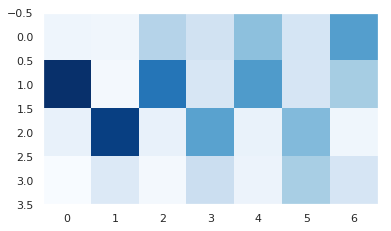

----------------------------------------------------------------------
Mean activation: 0.2902345657348633
Layer 0, filter#28
 [[0.195 0.003 0.    0.297 0.314 0.339 0.307]
 [0.211 0.997 0.001 0.248 0.162 0.172 0.219]
 [0.26  0.    0.999 0.212 0.225 0.172 0.166]
 [0.333 0.    0.    0.243 0.3   0.318 0.308]]



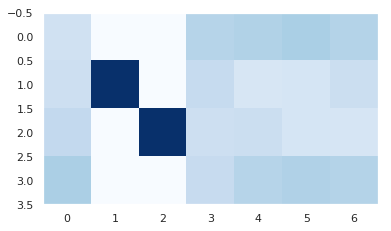

----------------------------------------------------------------------
Mean activation: 0.33069801330566406
Layer 0, filter#27
 [[0.114 0.19  0.043 0.31  0.277 0.213 0.243]
 [0.498 0.702 0.048 0.144 0.142 0.264 0.196]
 [0.262 0.    0.813 0.312 0.26  0.266 0.243]
 [0.126 0.108 0.095 0.233 0.32  0.257 0.318]]



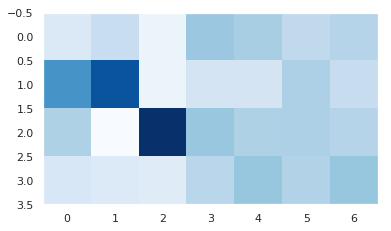

----------------------------------------------------------------------
Mean activation: 0.33670690655708313
Layer 0, filter#24
 [[0.184 0.004 0.136 0.184 0.367 0.243 0.249]
 [0.237 0.952 0.    0.281 0.268 0.241 0.294]
 [0.297 0.016 0.778 0.301 0.183 0.178 0.235]
 [0.281 0.028 0.086 0.234 0.183 0.338 0.222]]



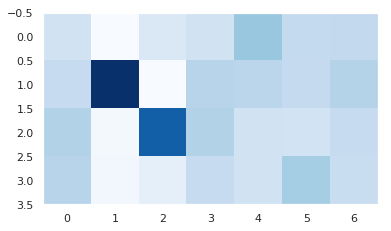

----------------------------------------------------------------------
Mean activation: 0.34213986992836
Layer 0, filter#19
 [[0.291 0.195 0.    0.    0.311 0.317 0.317]
 [0.25  0.232 1.    0.    0.22  0.185 0.206]
 [0.215 0.272 0.    1.    0.198 0.177 0.177]
 [0.244 0.3   0.    0.    0.271 0.321 0.3  ]]



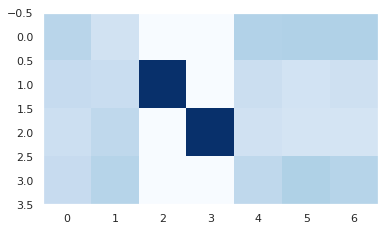

----------------------------------------------------------------------
Mean activation: 0.37057259678840637
Layer 0, filter#17
 [[0.361 0.336 0.192 0.003 0.    0.319 0.32 ]
 [0.151 0.179 0.241 0.993 0.009 0.225 0.21 ]
 [0.159 0.204 0.213 0.004 0.991 0.21  0.163]
 [0.329 0.28  0.354 0.    0.    0.247 0.307]]



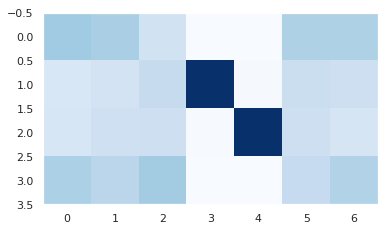

----------------------------------------------------------------------
Mean activation: 0.38709479570388794
Layer 0, filter#3
 [[0.199 0.    0.    0.306 0.334 0.325 0.301]
 [0.235 1.    0.008 0.232 0.183 0.183 0.239]
 [0.241 0.    0.992 0.211 0.158 0.177 0.155]
 [0.325 0.    0.    0.251 0.325 0.314 0.304]]



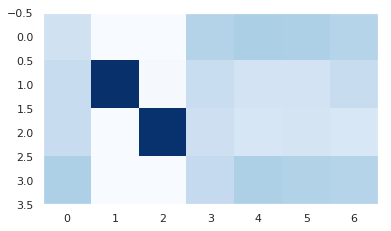

----------------------------------------------------------------------
Mean activation: 0.40062862634658813
Layer 0, filter#29
 [[0.213 0.    0.    0.259 0.259 0.266 0.261]
 [0.259 0.996 0.    0.265 0.238 0.251 0.25 ]
 [0.264 0.004 1.    0.249 0.258 0.231 0.237]
 [0.264 0.    0.    0.227 0.245 0.252 0.252]]



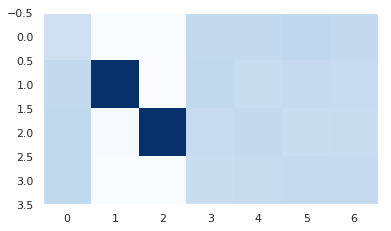

----------------------------------------------------------------------


In [58]:

params = list(model.parameters())
print([param.shape for param in params])

# params[0][0]
print(unique_DNAs)

mean_activations = []
PWMs = []
layers_idxs = []
filters_idxs = []

for l in range(0,6,2): # first layer conv filters only
    param_layer = params[l]

    for i, filter_weights in enumerate(param_layer):

        if(filter_weights.shape[1] < 6):
            continue
        #print("Filter shape:",filter_weights.shape)
        filter_length = filter_weights.shape[1]
        filter_weights = filter_weights.data.permute(1,0)

        motif_sequences = get_kmers(unique_DNAs,filter_length)

        label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

        ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

        ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
        #print(ohs.shape)
        #print(filter_weights.shape)
        vals = (ohs*filter_weights.cpu())

        activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))
        #activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2
        
        #print("activisions:",activisions[activisions > max(activisions)/2].shape)
        mean_activation = torch.mean(activisions[activisions > max(activisions)/2].squeeze())
        mean_activations.append(mean_activation.item())
        
        passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
        if(len(passed_sequences_idx) <=1):
            continue
        passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
        passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

        #passed_sequences, print(passed_sequences_motif)

        arr = np.array(passed_sequences).squeeze().transpose(1,0)
        probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences) for i in np.unique(label_encodings) ]
        
        PWMs.append(np.array(probs).squeeze())
        
        layers_idxs.append(l//2)
        filters_idxs.append(i)
        
#         print("Mean activation:",mean_activation.item())
#         print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#         print()
#         ax = plt.imshow(np.array(probs).squeeze(), cmap = plt.get_cmap('Blues') )
        
#         plt.grid(False)
        
#         #plt.grid(True, color='w', linestyle='-', linewidth=2, which = 'both')
#         #loc = ticker.MultipleLocator(base=2)
#         #ax.xaxis.set_minor_locator(loc)
#         #ax.yaxis.set_minor_locator(loc)

#         #plt.xticks(np.arange(0,filter_weights.shape[0])+0.5, np.arange(1,filter_weights.shape[0] + 1), fontsize=20)
#         #plt.yticks(np.arange(0,filter_weights.shape[1])+0.5, unique_DNAs, fontsize=20)
#         #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
#         #plt.yticks(rotation=0)
#         gridlinewidth = 1.6
#         #ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='r', linewidth=gridlinewidth)
#         #ax.vlines(np.arange(0,filter_weights.shape[0]+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
#         plt.show()
#         print("----------------------------------------------------------------------")


sorted_idxs = np.argsort(mean_activations)

for i in sorted_idxs:
    mean_activation = mean_activations[i]
    PWM = PWMs[i]
    layer_idx = layers_idxs[i]
    filter_idx = filters_idxs[i]
    
    print("Mean activation:",mean_activation)
    print(f"Layer {layer_idx}, filter#{filter_idx}\n",PWM)
    print()
    ax = plt.imshow(PWM, cmap = plt.get_cmap('Blues') )

    plt.grid(False)

    #plt.grid(True, color='w', linestyle='-', linewidth=2, which = 'both')
    #loc = ticker.MultipleLocator(base=2)
    #ax.xaxis.set_minor_locator(loc)
    #ax.yaxis.set_minor_locator(loc)

    #plt.xticks(np.arange(0,filter_weights.shape[0])+0.5, np.arange(1,filter_weights.shape[0] + 1), fontsize=20)
    #plt.yticks(np.arange(0,filter_weights.shape[1])+0.5, unique_DNAs, fontsize=20)
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=0)x sssssssssdem  n
    #plt.yticks(rotation=0)
    gridlinewidth = 1.6
    #ax.hlines(np.arange(len(unique_DNAs)+1), *ax.get_xlim(), color='r', linewidth=gridlinewidth)
    #ax.vlines(np.arange(0,filter_weights.shape[0]+1), *ax.get_ylim(), color='w', linewidth=gridlinewidth)
    plt.show()
    print("----------------------------------------------------------------------")












# params = list(model.parameters())
# print([param.shape for param in params])

# # params[0][0]
# print(unique_DNAs)



# for l in range(0,6,2): # first layer conv filters only
#     param_layer = params[l]

#     for i, filter_weights in enumerate(param_layer):

#         if(filter_weights.shape[1] < 6):
#             continue
#         print("Filter shape:",filter_weights.shape)
#         filter_length = filter_weights.shape[1]
#         filter_weights = filter_weights.data.permute(1,0)

#         motif_sequences = get_kmers(unique_DNAs,filter_length)

#         label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

#         ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

#         ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
#         #print(ohs.shape)
#         #print(filter_weights.shape)
#         vals = (ohs*filter_weights.cpu())


#         activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))

#         #activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2
        
#         passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
#         if(len(passed_sequences_idx) ==0):
#             continue
#         passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
#         passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

#         #passed_sequences, print(passed_sequences_motif)

#         arr = np.array(passed_sequences).squeeze().transpose(1,0)
#         probs = [np.sum(arr==i, axis = 1, keepdims=True)/len(passed_sequences) for i in np.unique(label_encodings) ]
#         print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#         print()
#         plt.imshow(np.array(probs).squeeze(), cmap = plt.get_cmap('jet') )
#         plt.grid('off')
        
#         plt.show()
        

In [59]:
passed_sequences_idx

array([  384,   385,   386, ..., 15805, 15806, 15807])

In [60]:
# params = list(model.parameters())
# [param.shape for param in params]
# params[0][0]
# print(unique_DNAs)

# l = 0
# param_layer = params[l]

# for i, filter_weights in enumerate(param_layer):
#     print("Filter shape:",filter_weights.shape)
#     filter_length = filter_weights.shape[1]
#     filter_weights = filter_weights.data.permute(1,0)
    
#     motif_sequences = get_kmers(unique_DNAs,filter_length)

#     label_encodings = np.array([unique_DNAs.index(c)+1  for motif_seq in motif_sequences for c in motif_seq ]).reshape(len(motif_sequences),-1)

#     ohs=[(np.arange(len(unique_DNAs)+1) == label_encoding[:,None]).astype(dtype='float32') for label_encoding in label_encodings]#one_hot

#     ohs = torch.Tensor(np.array([np.delete(oh,0, axis=-1) for oh in ohs]).reshape(len(ohs),-1, len(unique_DNAs)))
#     #print(ohs.shape)
#     #print(filter_weights.shape)
    
#     activisions = torch.nn.functional.relu(torch.sum(torch.sum(vals,1),1))

#     activisions[np.where(activisions > max(activisions)/2)], max(activisions)/2

#     passed_sequences_idx = np.where(activisions > max(activisions)/2)[0]
#     passed_sequences = [label_encodings[i] for i in passed_sequences_idx.squeeze()]
#     passed_sequences_motif = [motif_sequences[i] for i in passed_sequences_idx.squeeze()]

#     #passed_sequences, print(passed_sequences_motif)

#     arr = np.array(passed_sequences).squeeze().transpose(1,0)
#     probs = [np.sum(arr==i, axis = 1)/len(passed_sequences) for i in np.unique(label_encodings) ]
#     print(f"Layer {l//2}, filter#{i}\n",np.array(probs).squeeze())
#     print()

In [61]:
# torch.cuda.is_available(), logits.shape

In [62]:
# accuracy =  [result['accuracy'] for result in all_folds_last_results]
# np.mean(accuracy)    

In [63]:
# sensitivity =  [result['sensitivity'] for result in all_folds_last_results]
# np.mean(sensitivity)    

In [64]:
# specificity =  [result['specificity'] for result in all_folds_last_results]
# np.mean(specificity)    

In [65]:
# from tqdm import trange
# from random import random, randint
# from time import sleep

# with trange(10) as t:
#     for i in t:
#         # Description will be displayed on the left
#         t.set_description('GEN %i' % i)
#         # Postfix will be displayed on the right,
#         # formatted automatically based on argument's datatype
#         t.set_postfix(loss=random(), gen=randint(1,999), str='h',
#                       lst=[1, 2])
#         sleep(0.1)

# with tqdm(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
#           postfix=["Batch", dict(value=0)]) as t:
#     for i in range(10):
#         sleep(0.1)
#         t.postfix[1]["value"] = i / 2
#         t.update()

In [66]:
# from tqdm import tqdm
# for i in tqdm(range(100000000)):
#     pass

In [67]:
# from tqdm import tnrange, tqdm_notebook
# from time import sleep

# for i in tnrange(3, desc='1st loop'):
#     for j in tqdm_notebook(range(100), desc='2nd loop'):
#         sleep(0.01)

In [68]:
# from tqdm import trange
# from random import random, randint
# from time import sleep

# with trange(10) as t:
#     for i in t:
#         # Description will be displayed on the left
#         t.set_description('GEN %i' % i)
#         # Postfix will be displayed on the right,
#         # formatted automatically based on argument's datatype
#         t.set_postfix(loss=random(), gen=randint(1,999), str='h',
#                       lst=[1, 2])
#         sleep(0.1)

# with tqdm_notebook(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
#           postfix=["Batch", dict(value=0)]) as t:
#     for i in range(10):
#         sleep(0.1)
#         t.postfix[1]["value"] = i / 2
#         t.update()

In [69]:
# len(val_dataloader.dataset)